## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#%matplotlib qt
def calibration():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('camera_cal/calibration*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None, None) 
    return mtx, dist
mtx, dist = calibration()

In [2]:
def process_image(image):
    s_thresh=(120, 255)
    sx_thresh=(20, 100)
    undist = cv2.undistort(image, mtx, dist, None, None)
    img = np.copy(undist)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary,undist


print("camera calibration")

camera calibration


## And so on and so forth...

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


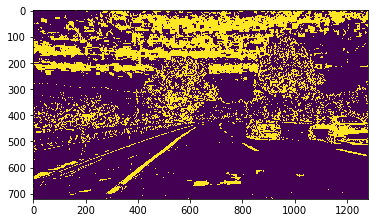

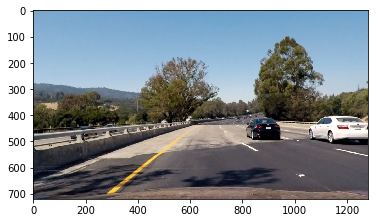

In [3]:
image = mpimg.imread('test_images/test4.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
result,undist = process_image(image)
plt.imshow(result)
plt.show()
undist_2 = cv2.undistort(image, mtx, dist, None, None)
plt.imshow(undist_2)
plt.show()

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


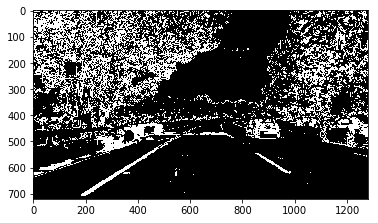

In [4]:
image = mpimg.imread('test_images/test5.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
binaryI,ss = process_image(image)
plt.imshow(binaryI, cmap='gray')
plt.show()

In [5]:
def get_perspective_transform(image):
    
    src = np.array([[585, 455],
                    [705, 455],
                    [1120, 720],
                    [190, 720]], np.float32)
    dst = np.array([[300 , 100],
                    [1000, 100],
                    [1000, 720],
                    [300, 720]], np.float32)
        
    m = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    return m, minv

(720, 1280)


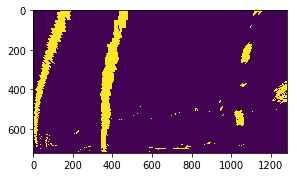

In [6]:

m , minv = get_perspective_transform(result)
warp = cv2.warpPerspective(result, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.rcParams['figure.figsize'] = figsize=(10,6)
print(warp.shape)
plt.subplot(1, 2, 2)
plt.imshow(warp)

plt.show()

In [7]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.ploty = None
        self.base = None
    def addXFit(self,xfit, plotY,fit):
        if len(self.recent_xfitted) > 10:
            self.recent_xfitted.pop(0)
        self.recent_xfitted.append(xfit)
        self.bestx = sum(self.recent_xfitted)/len(self.recent_xfitted)
        self.detected = True
        self.current_fit = fit
        self.plotY = plotY
print("Class")

Class


358
1049
969 1129
987 1107
982 1192
980 1190
980 1190
1000 1120
1007 1127
1017 1137
1017 1137
(32838,)


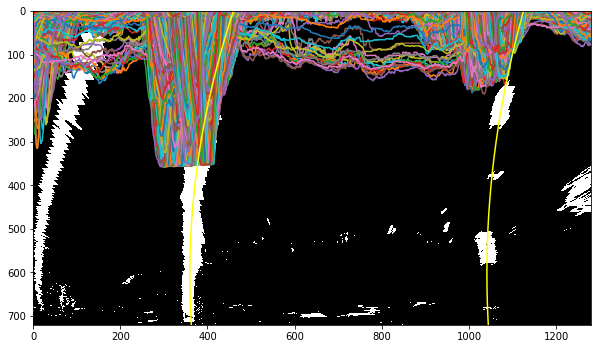

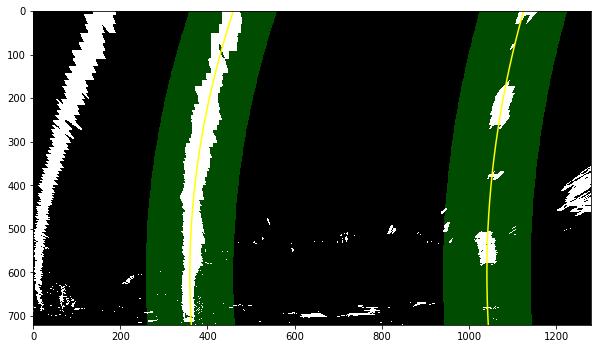

In [16]:
binary_warped= warp
out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
nonzero = binary_warped.nonzero()
nonzeroy2 = np.array(nonzero[1])
nonzerox2 = np.array(nonzero[1])
left_lane_inds2 = []
right_lane_inds2 = []
margin = 100
def find_lane(binary_warped, prevLeft, prevRight, scratch):
    if scratch == True:
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        print(leftx_base)
        print(rightx_base)
        plt.plot(histogram)
        left.base = leftx_base
        right.base = rightx_base
    else:
        leftx_base = prevLeft
        rightx_base = prevRight

# Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines

# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 80
    margin2 = 80
    margin3 = 80
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        if window == 1:
            margin = 60
            margin2 = 60
            margin3 = 60
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin3
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin2
        print(win_xright_low,win_xright_high)
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            if np.int(np.mean(nonzerox[good_left_inds])) < leftx_current:
                margin3 = max(margin + leftx_current - np.int(np.mean(nonzerox[good_left_inds])), 150)
            else:
                margin3 = 60

            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            if np.int(np.mean(nonzerox[good_right_inds])) < rightx_current:
                margin2 = max(margin + rightx_current - np.int(np.mean(nonzerox[good_right_inds])), 150)
            else:
                margin2 = 60
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img2 = out_img
    nonzerox2 = nonzerox
    nonzeroy2 = nonzeroy
    left_lane_inds2 = left_lane_inds
    right_lane_inds2 = right_lane_inds
    return leftx, lefty, rightx, righty, left_fit, right_fit
left = Line()
right = Line()
leftx, lefty, rightx, righty, left_fit, right_fit = find_lane(binary_warped,None, None, True)
print(leftx.shape)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]
plt.imshow(out_img2)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img2)
# Color in left and right line pixels
out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

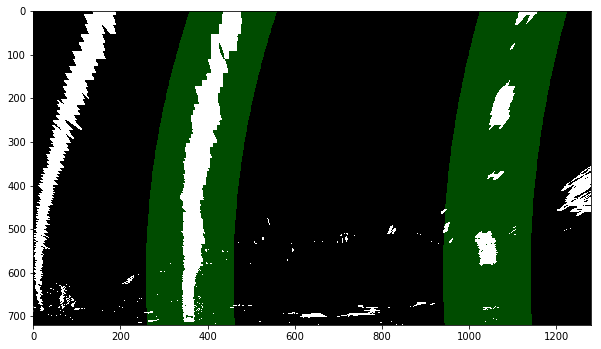

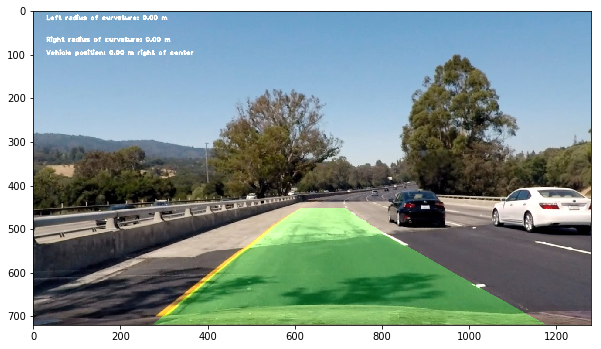

In [17]:
i = 0
def draw(left_fitx, right_fitx, result, minv,undist,left,right,center, detected):
    color_warp = np.zeros_like(result).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
    final = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(final,'Left radius of curvature: %.2f m'%(left),(30,20), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final,'Right radius of curvature: %.2f m'%(right),(30,70), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final,'Vehicle position: %.2f m %s of center'%(abs(center), 'left' if center < 0 else 'right'),(30,100), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)

    return final
plt.imshow(result)
plt.show()
final = draw(left_fitx, right_fitx, image, minv,undist,0,0,0,0)
plt.imshow(final)
plt.show()

In [18]:
left = Line()
right = Line()
def process(image):
    result, undist = process_image(image)
    m , minv = get_perspective_transform(result)
    warp = cv2.warpPerspective(result, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    scratch = True
    if left.detected > 3 or right.detected > 3:
        scratch =  False
    leftx, lefty, rightx, righty, left_fit, right_fit = find_lane(warp, left.base,right.base, scratch)
    ploty = np.linspace(0, warp.shape[0]-1, warp.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]
    middle = (leftx[-1] + rightx[-1])//2
    pos = image.shape[1]//2
    center = (pos - middle)*xm_per_pix
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
    if left_curverad/right_curverad > 7 or right_curverad/left_curverad > 7 or rightx[-1] - leftx[-1] > 900 or rightx[-1] - leftx[-1] < 500 or leftx[-1] < 10:
        left.detected =  left.detected + 1
        right.detected = right.detected + 1
        left_fitx = left.current_fit
        right_fitx = right.current_fit
        ploty = left.ploty
        print("wrong")
    else:
        left.detected =  0
        right.detected = 0
        left.addXFit(leftx[-1],ploty,left_fitx)
        right.addXFit(rightx[-1],ploty,right_fitx)
        print("right")
    
    
    print(left_curverad, 'm', right_curverad, 'm')
    print(rightx[-1], leftx[-1])
    
    return draw(left_fitx, right_fitx, image, minv,undist,left_curverad,right_curverad,center,left.detected)
    

In [19]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

359
1037
957 1117
991 1111
978 1188
971 1181
948 1158
910 1120
897 1107
854 1064
808 1018
right
731.076325626 m 1163.44428851 m
820.008841903 188.369051893
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

359

  0%|          | 1/1261 [00:00<03:15,  6.44it/s]


1037
957 1117
991 1111
978 1188
971 1181
948 1158
910 1120
897 1107
854 1064
808 1018
right
731.076325626 m 1163.44428851 m
820.008841903 188.369051893
362
1041
961 1121
987 1107
978 1188
943 1153
942 1152
908 1118
892 1102
855 1065
810 1020
right
735.412120993 m 1434.98581465 m

  0%|          | 2/1261 [00:00<03:17,  6.38it/s]


820.031064413 185.035828607
361
1043
963 1123
988 1108
980 1190
953 1163
916 1126
907 1117
863 1073
823 1033
798 1008
right
702.604046001 m 

  0%|          | 3/1261 [00:00<03:20,  6.26it/s]

1201.94118371 m
796.586408962 183.710683027
361
1049
969 1129
989 1109
982 1192
956 1166
921 1131
909 1119
866 1076
821 1031
804 1014
right
734.401968437 m

  0%|          | 4/1261 [00:00<03:16,  6.41it/s]

 1327.98433489 m
797.632253494 183.424740331
363
988
908 1068
989 1109
989 1109
962 1172
925 1135
916 1126
873 1083
829 1039
810 1020
right
762.882823362 m 1249.64072603

  0%|          | 6/1261 [00:00<03:13,  6.47it/s]

 m
799.697823165 183.612866582
365
991
911 1071
991 1111
963 1173
937 1147
924 1134
893 1103
866 1076
827 1037
792 1002
right
753.313451612 m 1189.55691553 m
786.361509892 181.124980707
363
987
907 1067
991 1111
972 1182
941 1151
930 1140
886 1096
841 1051
828 1038


  1%|          | 7/1261 [00:01<03:17,  6.34it/s]

781 991
right
810.707445377 m 1184.45733132 m
784.635872674 179.939091223
365
993
913 1073
974 1094
975 1095
942 1152
930 1140
890 1100
849 1059
834 

  1%|          | 8/1261 [00:01<03:19,  6.29it/s]

1044
785 995
right
809.626193078 m 1106.23602267 m
777.238214527 177.490442598
365
1012
932 1092
952 1072
981 1101
948 1158
936 1146
897 1107
855 1065
842 1052
796 1006


  1%|          | 9/1261 [00:01<03:17,  6.33it/s]

right
921.897720511 m 1731.84077418 m
794.987548866 179.977902475
365
1012
932 1092
986 1106
959 1169
950 1160
930 1140
905 1115
864 1074
844 1054
801 1011
right
916.664699073 m 1508.67695383

  1%|          | 10/1261 [00:01<03:17,  6.34it/s]

 m
794.801413153 175.493994597
366
1014
934 1094
990 1110
963 1173
952 1162
910 1120
865 1075
857 1067
811 1021
775 985
right
972.40635566 m 1574.28076682 

  1%|          | 11/1261 [00:01<03:18,  6.29it/s]

m
778.159642534 176.249431541
363
1025
945 1105
990 1110
970 1180
961 1171
922 1132
881 1091
871 1081
827 1037
801

  1%|          | 12/1261 [00:01<03:20,  6.23it/s]

 1011
right
997.906942466 m 1766.21418684 m
805.350289291 169.258099099
364
1029
949 1109
969 1089
972 1092
961 1171
924 1134

  1%|          | 13/1261 [00:02<03:24,  6.09it/s]


886 1096
875 1085
829 1039
781 991
right
1019.35937546 m 1489.64117304 m
795.628959571 168.523859359
364
1034
954 1114
983 1103
973 1183
973 1183
931 1141
891 1101
882 1092


  1%|          | 14/1261 [00:02<03:25,  6.06it/s]

837 1047
790 1000
right
973.921292449 m 1349.04674586 m
793.62059401 166.309533333
364
1034
954 1114
982 1102
971 1181
931 1141
890 1100
884 1094
838 1048
804 

  1%|          | 15/1261 [00:02<03:26,  6.03it/s]

1014
772 982
right
931.083731825 m 1411.01279482 m
765.611602006 167.206572061
368
1035
955 1115
980 1100
969 1179
929 1139
894 1104
883 1093
839 1049


  1%|▏         | 16/1261 [00:02<03:27,  6.01it/s]

793 1003
772 982
right
905.235309891 m 1387.61135396 m
756.590647336 169.227050315
365
1040
960 1120
981 1101
971 1181
934 1144
898 1108
888 1098
845 1055
800 1010
773

  1%|▏         | 17/1261 [00:02<03:26,  6.04it/s]

 983
right
933.197096333 m 1345.07820988 m
754.420175868 167.676118344
364
964
884 1044
974 1094
937 1147
931 1141
899 1109
872 1082
845 1055
801 1011
753 963
right


  2%|▏         | 19/1261 [00:03<03:18,  6.26it/s]

931.793573825 m 1257.00039845 m
754.873731239 167.865927798
363
976
896 1056
982 1102
947 1157
915 1125
906 1116
862 1072
826 1036
801 1011
750 960
right
967.127433469 m 1125.05052921 m
746.360514976 164.525340972


  2%|▏         | 20/1261 [00:03<03:15,  6.35it/s]

364
985
905 1065
980 1100
956 1166
924 1134
913 1123
873 1083
831 1041
810 1020
765 975
right
1004.32810177 m 1149.76076544 m
759.609546162 163.368896171


  2%|▏         | 21/1261 [00:03<03:12,  6.46it/s]

360
996
916 1076
974 1094
964 1174
931 1141
922 1132
883 1093
842 1052
820 1030
772 982
right
1076.50556714 m 1095.70990978 m
768.706550618 163.165656404
361
1004
924 1084
978 1098
972 1182
939 1149
930 1140
897 1107
854 1064
833 1043
787 997
right
1148.91376757 m 1057.79947865

  2%|▏         | 23/1261 [00:03<03:09,  6.53it/s]

 m
782.653531208 162.759070588
337
1006
926 1086
977 1097
952 1162
944 1154
944 1154
908 1118
866 1076
846 1056
801 1011
right
1121.24622647 m 997.378739145 m
795.060949722 160.341729489


  2%|▏         | 24/1261 [00:03<03:08,  6.57it/s]

351
1008
928 1088
979 1099
955 1165
947 1157
913 1123
868 1078
859 1069
828 1038
804 1014
right
1061.52445308 m 1480.5748991 m
793.486633246 161.548753456


  2%|▏         | 25/1261 [00:03<03:07,  6.60it/s]

353
1013
933 1093
983 1103
958 1168
948 1158
918 1128
878 1088
859 1069
813 1023
765 975
right
951.227738361 m 1087.71112204 m
771.667949764 160.119460076
346
1023
943 1103
963 1083
964 1084
956 1166
927 1137
889 1099
873 1083
828 1038
778 988


  2%|▏         | 26/1261 [00:04<03:10,  6.48it/s]

right
982.768635208 m 1127.24187341 m
790.948173196 159.002649874
348
1029
949 1109
975 1095
968 1178
968 1178
936 1146
898 1108
881 1091
838 1048
790 1000
right
857.695361267 m 1128.974756 m
797.255917195 155.342576164

  2%|▏         | 27/1261 [00:04<03:09,  6.52it/s]


343
1037
957 1117
981 1101
974 1184
947 1157
947 1157
909 1119
897 1107
856 1066
809 1019
right


  2%|▏         | 28/1261 [00:04<03:11,  6.44it/s]

926.804261803 m 1116.06587893 m
816.711210037 157.680109752
348
1039
959 1119
983 1103
976 1186
949 1159
914 1124
904 1114
860 1070
835 1045
800 1010
right
859.625545355 m 1290.78395664 

  2%|▏         | 29/1261 [00:04<03:11,  6.43it/s]

m
804.528205721 157.576009866
347
1039
959 1119
982 1102
977 1187
951 1161
916 1126
905 1115
863 1073
817 1027
792 1002

  2%|▏         | 30/1261 [00:04<03:13,  6.37it/s]


right
787.865698884 m 1090.55080294 m
785.09033769 156.495876396
347
969
889 1049
979 1099
951 1161
959 1079
919 1129
908 1118
868 1078
823 1033
793 1003
right
741.978968126 m 870.681324978 m
772.524425876 155.49091586


  2%|▏         | 31/1261 [00:04<03:12,  6.40it/s]

347
968
888 1048
977 1097
958 1168
924 1134
916 1126
870 1080
833 1043
807 1017
764 974


  3%|▎         | 32/1261 [00:05<03:13,  6.36it/s]

right
681.296531921 m 956.683902248 m
752.833056751 154.803386517
344
992
912 1072
981 1101
966 1176
934 1144
923 1133
883 1093
838 1048
819 1029
768 978
right
668.299885245 m 1006.68182745 m
766.122428711

  3%|▎         | 33/1261 [00:05<03:13,  6.36it/s]

 152.488034876
346
1000
920 1080
940 1060
969 1089
936 1146
926 1136
889 1099
845 1055
823 1033
774 984
right
637.791320066 m 962.58947681 m

  3%|▎         | 35/1261 [00:05<03:09,  6.48it/s]


760.834866468 148.729826244
347
1005
925 1085
974 1094
974 1094
940 1150
935 1145
896 1106
852 1062
828 1038
782 992
right
629.939659141 m 927.00752524 m
761.539756414 147.741282889


  3%|▎         | 36/1261 [00:05<03:08,  6.51it/s]

349
1006
926 1086
977 1097
953 1163
941 1151
901 1111
855 1065
843 1053
794 1004
746 956
right
632.201822476 m 1004.05152116 m
742.113714246 148.065281057


  3%|▎         | 37/1261 [00:05<03:05,  6.60it/s]

351
1009
929 1089
979 1099
954 1164
944 1154
907 1117
863 1073
845 1055
798 1008
746 956
right
638.746414562 m 913.932854054 m
736.516695214 147.561185957
352
1014
934 1094
954 1074
956 1076
947 1157
913 1123
869 1079
852 1062
806 1016
756 966
right
613.677415227 m 815.941860205 m
733.650146011

  3%|▎         | 38/1261 [00:05<03:06,  6.54it/s]

 144.394492858
354
1019
939 1099
959 1079
957 1167
912 1122
909 1119
869 1079
834 1044
809 1019
758 968

  3%|▎         | 40/1261 [00:06<03:07,  6.50it/s]


right
590.58432125 m 1066.22731675 m
736.59592035 140.594647572
354
1024
944 1104
971 1091
961 1171
926 1136
882 1092
872 1082
823 1033
778 988
743 953
right
605.614209527 m 831.094558483 m
716.140107824 139.181175804
354
1029
949 1109
974 1094
964 1174
930 1140
890 1100
875 1085
830 1040
781 991


  3%|▎         | 41/1261 [00:06<03:08,  6.47it/s]

749 959
right
620.816861223 m 862.860404806 m
719.723699872 138.99847438
355
955
875 1035
967 1087
968 1088
939 1149
899

  3%|▎         | 42/1261 [00:06<03:13,  6.29it/s]

 1109
883 1093
840 1050
790 1000
757 967
right
629.092420697 m 755.232465246 m
722.594794646 138.385273026
356
957
877 1037
970 1090
970 1090
945 1155
906 1116
891

  3%|▎         | 43/1261 [00:06<03:17,  6.16it/s]

 1101
849 1059
801 1011
766 976
right
685.57936464 m 790.694894504 m
736.024297408 139.87806089
356
975
895 1055
982 1102
955 1165
919 1129
911 1121
881 1091
860 1070
812 1022
783 993
right
698.286043485 

  3%|▎         | 44/1261 [00:06<03:19,  6.10it/s]

m 1055.53049541 m
760.231062323 137.032754577
356
985
905 1065
985 1105
963 1173
929 1139
917 1127
870 1080
833 1043
805 1015
758 968
right
739.662132934 m 1061.92684465 m

  4%|▎         | 45/1261 [00:07<03:15,  6.22it/s]


750.821324676 138.029023229
356
994
914 1074
969 1089
967 1177
933 1143
922 1132
880 1090
835 1045
810 1020
759 969
right


  4%|▎         | 46/1261 [00:07<03:15,  6.22it/s]

765.116716071 m 877.320172806 m
747.563419431 137.453058405
355
1001
921 1081
966 1086
973 1093
940 1150
929 1139
887 1097
843 1053
819 1029
771 981
right
781.172506521 m 923.420112994 m
754.931086626 137.147827041

  4%|▎         | 47/1261 [00:07<03:13,  6.28it/s]


355
1006
926 1086
973 1093
952 1162
940 1150
907 1117
890 1100
847 1057
823 1033
777 987
right
834.867965107 m 903.870399216 m
750.907638912 138.525230197

  4%|▍         | 48/1261 [00:07<03:10,  6.36it/s]


355
1016
936 1096
980 1100
958 1168
947 1157
903 1113
870 1080
847 1057
826 1036
783 993
right
903.17308011 m 1335.86677323 m


  4%|▍         | 49/1261 [00:07<03:09,  6.40it/s]

764.769331013 138.387696061
356
1022
942 1102
983 1103
961 1171
950 1160
913 1123
870 1080
850 1060
800 1010
748 958
right


  4%|▍         | 50/1261 [00:07<03:10,  6.35it/s]

962.561229888 m 886.900912295 m
744.730908587 138.718147994
356
1028
948 1108
968 1088
963 1173
954 1164
919 1129
876 1086
857 1067


  4%|▍         | 51/1261 [00:08<03:14,  6.22it/s]

810 1020
757 967
right
993.953120383 m 906.923290696 m
749.276098882 138.623931125
357
1030
950 1110
972 1092
963 1173
963 1173
924 1134
880 1090
858 1068
812 1022
760 970
right
959.876023035

  4%|▍         | 53/1261 [00:08<03:09,  6.38it/s]

 m 870.319335712 m
740.930497321 139.892625641
357
1027
947 1107
974 1094
964 1174
930 1140
887 1097
874 1084
823 1033
786 996
750 960
right
988.397761713 m 985.327816966 m
731.7929189 143.268344499


  4%|▍         | 54/1261 [00:08<03:07,  6.45it/s]

357
1039
959 1119
976 1096
967 1177
933 1143
893 1103
876 1086
830 1040
781 991
749 959
right
964.979554294 m 907.352399019 m
722.809558193 141.986764737


  4%|▍         | 55/1261 [00:08<03:03,  6.57it/s]

357
954
874 1034
966 1086
975 1095
939 1149
899 1109
882 1092
837 1047
789 999
758 968
right
1011.57296415 m 881.292288891 m
732.678167751 141.917376538


  4%|▍         | 56/1261 [00:08<02:59,  6.73it/s]

356
959
879 1039
971 1091
944 1154
950 1070
908 1118
892 1102
850 1060
801 1011
770 980
right
1052.45690153 m 797.583258389 m
739.504213612 143.564213571


  5%|▍         | 57/1261 [00:08<03:00,  6.68it/s]

356
967
887 1047
977 1097
952 1162
917 1127
906 1116
860 1070
831 1041
794 1004
742 952
right
1041.63787586 m 962.982195257 m
734.887234142 144.630802194


  5%|▍         | 58/1261 [00:09<02:58,  6.75it/s]

354
979
899 1059
977 1097
960 1170
923 1133
911 1121
869 1079
821 1031
795 1005
747 957
right
1052.82025033 m 1033.25701975 m
733.913056895 145.999612691


  5%|▍         | 59/1261 [00:09<02:58,  6.73it/s]

355
983
903 1063
923 1043
960 1080
923 1133
909 1119
869 1079
822 1032
796 1006
749 959
right
972.338106093 m 1028.62143636 m
725.050101959 148.745912598


  5%|▍         | 60/1261 [00:09<02:55,  6.83it/s]

356
984
904 1064
963 1083
931 1141
921 1131
880 1090
856 1066
815 1025
768 978
719 929
right
926.267296195 m 1022.34293452 m
707.013385314 151.076728204


  5%|▍         | 61/1261 [00:09<02:55,  6.86it/s]

354
990
910 1070
966 1086
938 1148
923 1133
881 1091
838 1048
813 1023
767 977
718 928
right
975.810078014 m 1389.99698994 m
708.456741831 155.915526778


  5%|▍         | 62/1261 [00:09<02:55,  6.84it/s]

343
997
917 1077
971 1091
938 1148
925 1135
886 1096
840 1050
816 1026
771 981
721 931
right
957.129611169 m 1265.88332649 m
703.46350581 159.482986304


  5%|▍         | 63/1261 [00:09<02:54,  6.85it/s]

341
1005
925 1085
945 1065
943 1153
931 1141
895 1105
849 1059
823 1033
787 997
738 948
right
989.612625733 m 1401.85094432 m
724.559488363 161.15092615


  5%|▌         | 64/1261 [00:09<02:57,  6.75it/s]

348
1010
930 1090
955 1075
945 1155
899 1109
884 1094
846 1056
800 1010
761 971
727 937
right
971.895588641 m 1093.54013799 m
702.285684426 165.783027514


  5%|▌         | 65/1261 [00:10<02:57,  6.74it/s]

346
1018
938 1098
959 1079
949 1159
911 1121
866 1076
854 1064
810 1020
763 973
738 948
right
948.608802112 m 1137.07469738 m
714.756119413 165.689072188


  5%|▌         | 66/1261 [00:10<02:53,  6.89it/s]

349
919
839 999
859 979
859 979
907 1027
868 1078
855 1065
815 1025
769 979
745 955
right
920.313954282 m 864.085449888 m
716.779588162 167.564160902
347
927
847 1007
937 1057
952 1072
922 1132
879 1089
863 1073
824 1034
777 987
745 955
right
956.472514018 m 1134.14027061 m
726.585552718 

  5%|▌         | 67/1261 [00:10<02:56,  6.78it/s]

170.389332521
346
944
864 1024
956 1076
956 1076
929 1139
886 1096
866 1076
837 1047
791 1001
737 947
right
1006.34988953 m 791.653940214 m
720.589583762 170.436809224


  5%|▌         | 68/1261 [00:10<02:59,  6.66it/s]

345
940
860 1020
951 1071
934 1144
892 1102
883 1093
841 1051
798 1008
779 989
731 941
right
999.847684941 m 814.161906874 m
704.950550443 

  6%|▌         | 70/1261 [00:10<02:57,  6.69it/s]

173.393264824
343
951
871 1031
963 1083
942 1152
902 1112
891 1101
852 1062
809 1019
792 1002
746 956
right
1044.00266761 m 1002.4939771 m
727.878096726 171.479245447


  6%|▌         | 71/1261 [00:11<02:56,  6.74it/s]

341
957
877 1037
897 1017
940 1060
904 1114
894 1104
860 1070
816 1026
789 999
750 960
right
1052.74403216 m 848.193597162 m
723.752110577 173.31385723
340
964
884 1044
948 1068
954 1074
912 1122
901 1111
868 1078
824 1034
791 1001
762 972
right
1128.64174483 m 949.784560512 m
735.383901668 174.797192172


  6%|▌         | 72/1261 [00:11<02:58,  6.68it/s]

338
978
898 1058
956 1076
922 1132
915 1125
874 1084
851 1061
822 1032
776 986
728 938
right
1141.76264281 m 885.476865212 m
724.293126763

  6%|▌         | 73/1261 [00:11<03:00,  6.59it/s]

 174.181172704
339
983
903 1063
957 1077
927 1137
918 1128
884 1094
841 1051
826 1036
781 991
734

  6%|▌         | 74/1261 [00:11<03:03,  6.48it/s]

 944
right
1201.1480523 m 973.781440624 m
727.174077394 174.922623967
337
984
904 1064
961 1081
933 1143
923 1133
894 1104
851 1061
835 1045
791 1001
746 956
right
1253.3035763 m 995.415647165 m

  6%|▌         | 75/1261 [00:11<03:04,  6.42it/s]


740.024158477 171.136877428
338
1001
921 1081
941 1061
935 1145
928 1138
899 1109
858 1068
840 1050
798 1008
751 961
right


  6%|▌         | 77/1261 [00:11<03:02,  6.48it/s]

1232.49945905 m 912.2452355 m
738.340186103 173.040695562
336
1004
924 1084
950 1070
942 1152
942 1152
912 1122
870 1080
853 1063
814 1024
767 977
right
1295.03090128 m 958.330430755 m
760.916840355 169.769192238


  6%|▌         | 78/1261 [00:12<02:59,  6.58it/s]

335
1009
929 1089
953 1073
946 1156
917 1127
877 1087
871 1081
840 1050
814 1024
772 982
right
1369.13130112 m 1152.00349272 m
770.005320949 170.128639677
334
1013
933 1093
956 1076
950 1160
926 1136
888 1098
879 1089
835 1045
794 1004
769 979
right
1358.31595733 m 968.09902118 m


  6%|▋         | 80/1261 [00:12<02:58,  6.63it/s]

760.998142762 168.814016765
334
944
864 1024
953 1073
954 1074
929 1139
893 1103
883 1093
842 1052
798 1008
778 988
right
1272.67826505 m 1030.26205169 m
769.128215305 168.773283472


  6%|▋         | 81/1261 [00:12<02:56,  6.69it/s]

333
947
867 1027
955 1075
929 1139
933 1053
895 1105
885 1095
846 1056
803 1013
783 993
right
1278.45298853 m 1053.28376529 m
765.45351689 171.697908066
327
962
882 1042
959 1079
938 1148
904 1114
899 1109
862 1072
837 1047
804 1014
771 981
right
1244.84984773 m 1167.83064839 m
767.029103167 171.517732688


  7%|▋         | 82/1261 [00:12<02:59,  6.58it/s]

329
965
885 1045
959 1079
944 1154
913 1123
903 1113
866 1076
823 1033
807 1017
764 974
right
1199.64353335 m 1033.79615565 m
761.810314837 

  7%|▋         | 84/1261 [00:13<02:57,  6.61it/s]

170.116755197
326
979
899 1059
919 1039
951 1071
924 1134
913 1123
880 1090
837 1047
825 1035
779 989
right
1238.35880309 m 1034.58819845 m
784.206533244 165.746183342


  7%|▋         | 85/1261 [00:13<02:55,  6.69it/s]

305
992
912 1072
954 1074
954 1074
926 1136
919 1129
886 1096
845 1055
830 1040
786 996
right
1138.56085823 m 1075.07542768 m
785.673302935 165.747326693
306
992
912 1072
959 1079
935 1145
929 1139
929 1139
895 1105
852 1062
836 1046
792 1002
right


  7%|▋         | 87/1261 [00:13<02:57,  6.60it/s]

1072.4738893 m 1066.83980215 m
786.664028228 166.22718428
317
990
910 1070
958 1078
937 1147
928 1138
894 1104
851 1061
841 1051
800 1010
754 964
right
928.380568247 m 1015.10763083 m
756.504825806 171.995452982
323
993
913 1073
933 1053
936 1056
928 1138
897 1107
855 1065
841 1051
800 1010
754 964
right
840.742452741 m 1141.72007162 m
751.705116481 173.139651044


  7%|▋         | 88/1261 [00:13<02:56,  6.64it/s]

324
997
917 1077
937 1057
937 1057
935 1145
899 1109
857 1067
836 1046
805 1015
759

  7%|▋         | 89/1261 [00:13<03:01,  6.47it/s]

 969
right
782.357569849 m 1347.00779837 m
754.234673916 174.205804883
327
999
919 1079
946 1066
937 1147
902 1112
859 1069
854 1064
810 1020
765 975
743 953
right
721.704373525 m 1068.14889694 

  7%|▋         | 90/1261 [00:13<03:02,  6.42it/s]

m
721.961693933 176.342975322
326
1006
926 1086
950 1070
942 1152
909 1119
871 1081
863 1073
821 1031
777 987
754 964
right

  7%|▋         | 91/1261 [00:14<03:04,  6.36it/s]


722.544177854 m 1172.70031919 m
738.167773425 175.541917229
326
928
848 1008
942 1062
946 1066
919 1129
879 1089
869 1079
830

  7%|▋         | 92/1261 [00:14<03:07,  6.24it/s]

 1040
785 995
762 972
right
747.021242325 m 1012.00066455 m
741.081441518 176.038355586
328
933

  7%|▋         | 93/1261 [00:14<03:20,  5.83it/s]


853 1013
946 1066
946 1066
922 1132
883 1093
869 1079
837 1047
793 1003
748 958
right
729.455865272 m 1006.92116529 m
745.5994055 176.258969209
330
949
869 1029
955 1075

  8%|▊         | 95/1261 [00:14<03:20,  5.82it/s]


929 1139
893 1103
885 1095
842 1052
804 1014
784 994
737 947
right
722.122442196 m 1016.96129958 m
724.938481961 176.155419724
328
948
868 1028
955 1075
932 1142
900 1110
891 1101
853 1063
812 1022
795 1005
750 960
right
753.943837183 m 1026.97728747 m
739.716168519 175.241737241


  8%|▊         | 96/1261 [00:14<03:11,  6.10it/s]

328
956
876 1036
896 1016
936 1056
904 1114
896 1106
863 1073
821 1031
802 1012
756 966
right
758.502073924 m 905.140624037 m
741.78586232 174.977605583
329
961
881 1041
901 1021
940 1060
908 1118
902 1112
870 1080
828 1038
805 1015
763 973
right
770.721123683 

  8%|▊         | 98/1261 [00:15<03:08,  6.16it/s]

m 916.376741891 m
746.442343226 175.04674479
328
970
890 1050
947 1067
924 1134
915 1125
878 1088
869 1079
833 1043
802 1012
772 982
right
800.457379281 m 1164.08882091 m
761.141308127 173.951737499
331
977
897 1057
951 1071
926 1136
917 1127
885 1095
845 1055
832 1042
787 997
741 951
right
797.465868363 m 887.56667869 m
738.42804074 175.423297767


  8%|▊         | 101/1261 [00:15<02:58,  6.51it/s]

331
981
901 1061
955 1075
930 1140
922 1132
894 1104
855 1065
841 1051
797 1007
752 962
right
808.568284286 m 951.122874817 m
751.25521976 174.800300164
332
990
910 1070
930 1050
934 1054
927 1137
900 1110
860 1070
846 1056
802 1012
757 967
right
745.56681294 m 1003.60215989 m
753.331503805 169.698777107


  8%|▊         | 102/1261 [00:15<02:59,  6.44it/s]

334
994
914 1074
942 1062
935 1145
898 1108
904 1024
864 1074
839 1049
809 1019
764 974
right
742.409417225 m 1028.38857715 m
757.038477263 172.244646522
334
1001
921 1081
946 1066
940 1150
911 1121
877 1087
868 1078
823 1033
783 993
757 967
right
740.186727203 m 833.719900791 m
738.551427231 173.494165604

  8%|▊         | 104/1261 [00:16<03:00,  6.41it/s]


336
1005
925 1085
949 1069
943 1153
916 1126
884 1094
871 1081
831 1041
788 998
763 973
right
751.257422687 m 904.104175083 m
745.694994371 174.807196613
335
948
868 1028
953 1073
949 

  8%|▊         | 105/1261 [00:16<03:09,  6.09it/s]

1159
927 1137
894 1104
883 1093
845 1055
803 1013
782 992
right
768.899524059 m 955.549915773 m
767.132344486 172.012075752
336
960
880 1040
958 1078
958 1078
935 1145
902 1112
892 1102
858 1068
816 1026
792 1002


  8%|▊         | 107/1261 [00:16<03:35,  5.35it/s]

right
758.258801896 m 984.075391807 m
779.715186435 169.377346836
337
975
895 1055
963 1083
944 1154
918 1128
910 1120
906 1116
869 1079
827 1037
805 1015
right
802.741679503 m 1002.11962388 m
791.222822429 170.646879688
339
968
888 1048
965 1085
947 1157
922 1132
910 1120
874 1084
833 1043
818 1028
769 

  9%|▊         | 109/1261 [00:17<03:19,  5.77it/s]

979
right
760.693743047 m 818.188663663 m
764.333783461 170.968279522
339
975
895 1055
915 1035
951 1071
925 1135
913 1123
883 1093
842 1052
824 1034
776 986
right
764.930946369 m 788.648453746 m
767.405109112 172.005567361
338
981
901 1061
958 1078
958 1078
930 1140
921 1131
891 1101
851 1061
834 1044
787 997
right
753.233865925 m 805.947445928 m
775.080845926 171.773192102


  9%|▉         | 111/1261 [00:17<03:12,  5.96it/s]

340
986
906 1066
964 1084
940 1150
932 1142
892 1102
895 1015
855 1065
835 1045
794 1004
right
750.839239086 m 926.640535653 m
779.5864651 172.259747968
338
998
918 1078
969 1089
950 1160
940 1150
909 

  9%|▉         | 113/1261 [00:17<03:11,  6.00it/s]

1119
884 1094
861 1071
836 1046
806 1016
right
803.856590459 m 1126.55135763 m
795.978660755 172.288530765
341
1001
921 1081
971 1091
950 1160
940 1150
914 1124
875 1085
862 1072
816 1026
770 980
right
749.889927963 m 733.100684001 m
762.700237556 171.463324735
344
1019
939 1099
959 1079
952 1162
944 1154
921 1131
882 1092
868 1078
823 1033

  9%|▉         | 115/1261 [00:18<03:09,  6.06it/s]


777 987
right
753.834950368 m 775.514701456 m
767.408718507 172.981086981
343
1015
935 1095
962 1082
953 1163
918 1128
928 1048
886 1096
858 1068
828 1038
782 992
right
689.508694851 m 799.690997839 m
763.65662159 170.699971743
344
1019
939 1099
963 1083
954 1164
929 1139
889 1099
882 1092
836 1046
793 1003
763 973
right
687.807054603 

  9%|▉         | 117/1261 [00:18<03:05,  6.17it/s]

m 737.027870991 m
739.389923521 172.004041791
344
1024
944 1104
965 1085
957 1167
935 1145
898 1108
887 1097
844 1054
800 1010
771 981
right
664.306408182 m 801.728708788 m
748.533112893 167.575081528
345
958
878 1038
964 1084
964 1084
937 1147
902 1112
893 1103
850 1060
806 1016
779 989
right
675.210561311 m 

  9%|▉         | 119/1261 [00:18<03:02,  6.26it/s]

809.272689116 m
750.719179733 166.629179893
347
968
888 1048
969 1089
941 1151
948 1068
909 1119
890 1100
860 1070
815 1025
783 993
right
683.750707313 m 829.559323025 m
756.78598052 166.912215425
348
965
885 1045
970 1090
947 1157
917 1127
908 1118
866 1076


 10%|▉         | 121/1261 [00:19<03:04,  6.17it/s]

822 1032
801 1011
751 961
right
654.270494327 m 722.098863306 m
722.503303696 164.290013651
349
975
895 1055
970 1090
955 1165
925 1135
915 1125
874 1084
832 1042
808 1018
760 970
right
672.352697357 m 780.424678374 m
734.864564949 164.444937207
351
986

 10%|▉         | 122/1261 [00:19<03:21,  5.66it/s]


906 1066
926 1046
960 1080
928 1138
919 1129
881 1091
838 1048
813 1023
765 975
right
666.274586434 m 765.817094961 m
734.392957801 162.555924801
352
985
905 1065
961 1081
961 1081
929 1139
898 1108
873 1083
835 1045


 10%|▉         | 124/1261 [00:19<03:08,  6.04it/s]

782 992
731 941
right
660.933528047 m 665.479455651 m
712.412863509 162.968429258
353
997
917 1077
969 1089
943 1153
934 1144
894 1104
851 1061
834 1044
790 1000
737 947
right
665.900016141 m 856.132121426 m
718.926713906 163.336054026


 10%|▉         | 125/1261 [00:19<02:59,  6.31it/s]

354
1008
928 1088
970 1090
946 1156
937 1147
903 1113
861 1071
838 1048
795 1005
745 955
right
671.189935567 m 823.364337912 m
718.255242545 163.584525322
355
1017
937 1097
957 1077
953 1163
945 1155
912 1122
871 1081
852 1062
809 1019
760 970
right
725.720019144 m 852.786022332 m
738.082696585 

 10%|█         | 127/1261 [00:20<02:55,  6.44it/s]

163.974807493
355
1010
930 1090
950 1070
956 1076
956 1076
918 1128
875 1085
839 1049
810 1020
763 973
right
701.845901743 m 877.900182773 m
738.339131265 163.470458053
356
1024
944 1104
969 1089
961 1171
926 1136
889 1099
876 1086
829 1039
782 992
750 960
right
723.224175033 m 816.670570607 m
726.340466041 162.720835141


 10%|█         | 130/1261 [00:20<02:50,  6.62it/s]

358
935
855 1015
875 995
875 995
921 1041
888 1098
875 1085
830 1040
782 992
754 964
right
698.870146615 m 670.617998109 m
713.00828777 161.846973792
358
951
871 1031
962 1082
965 1085
935 1145
896 1106
881 1091
839 1049
792 1002
762 972
right
740.956110722 m 832.967457532 m
728.561549515 164.707595198


 10%|█         | 131/1261 [00:20<02:50,  6.62it/s]

359
960
880 1040
969 1089
969 1089
942 1152
903 1113
875 1085
847 1057
801 1011
801 1011
right
769.372501656 m 861.310172412 m
735.83271585 166.197640785
361
961
881 1041
969 1089
946 1156
914 1124
901 1111
856 1066
811 1021
785 995
739 949
right
758.768132257 m 

 11%|█         | 133/1261 [00:20<02:54,  6.47it/s]

818.768854203 m
709.834762827 166.804022657
360
975
895 1055
977 1097
951 1161
922 1132
909 1119
867 1077
822 1032
799 1009
754 964
right
777.162771051 m 857.613797582 m
724.527275137 168.258668612
362
985
905 1065
925 1045
955 1075
925 1135
912 1122
873 1083
827 1037
799 1009
759 969
right
810.995809659 m 963.409621215 m


 11%|█         | 135/1261 [00:21<02:53,  6.49it/s]

730.617755991 171.132243786
364
993
913 1073
954 1074
965 1085
931 1141
922 1132
885 1095
839 1049
800 1010
756 966
right
812.534751239 m 803.702177442 m
734.151008034 170.75026736
365
1002
922 1082
967 1087
949 1159
937 1147
893 1103
860 1070
836 1046
789 999
742 952
right
865.318423541 m 1175.92333302 m

 11%|█         | 138/1261 [00:21<02:50,  6.59it/s]


738.822950974 174.176704382
365
1006
926 1086
975 1095
955 1165
943 1153
905 1115
862 1072
845 1055
800 1010
752 962
right
895.194274942 m 1198.79539839 m
749.779691406 175.155452526
364
1025
945 1105
981 1101
961 1171
949 1159
916 1126
873 1083
856 1066
814 1024
769 979
right
948.676327081 m 1243.07385375 m
768.522710512 177.152437428


 11%|█         | 139/1261 [00:21<02:57,  6.34it/s]

362
1025
945 1105
965 1085
964 1174
954 1164
927 1137
884 1094
863 1073
822 1032
779 989
right
942.635067863 m 1298.36645197 m
777.120731589 177.818157082
360
1032
952 1112
977 1097
969 1179
969 1179
936 1146
894 1104
872 1082
836 1046
792 1002
right
998.015582348

 11%|█         | 141/1261 [00:22<02:57,  6.32it/s]

 m 1315.20765373 m
792.581387941 178.782002544
360
1037
957 1117
980 1100
971 1181
940 1150
896 1106
889 1099
847 1057
815 1025
785 995
right
990.67513146 m 1369.85854501 m
781.989255579 179.268466836
360
1041
961 1121
982 1102
974 1184
948 1158
908 1118
894 1104
851 1061
809 1019


 11%|█▏        | 143/1261 [00:22<02:55,  6.37it/s]

789 999
right
1027.56500286 m 1286.20901593 m
780.555405972 183.523998639
360
966
886 1046
975 1095
971 1181
947 1157
909 1119
893 1103
854 1064
812 1022
785 995
right
986.441579371 m 1058.56492492 m
766.599679388 185.753999199
360
971
891 1051
979 1099
949 1159
960 1080
916 1126
894 1104
863 1073
821 1031
772 982
right
983.5965554 m 876.311011542 m

 11%|█▏        | 145/1261 [00:22<02:52,  6.49it/s]


762.792395781 185.280241955
359
972
892 1052
980 1100
957 1167
924 1134
914 1124
872 1082
831 1041
815 1025
768 978
right
977.972417932 m 1048.28387984 m
761.094391809 185.946211941
358
985
905 1065
983 1103
963 1173
927 1137
916 1126
879 1089
838 1048
819 1029
775 985
right
906.982262851 m 

 12%|█▏        | 147/1261 [00:23<02:50,  6.52it/s]

1226.59179925 m
764.73892448 186.829737176
358
987
907 1067
927 1047
967 1087
933 1143
922 1132
889 1099
849 1059
828 1038
786 996
right
938.544411328 m 1048.96258431 m
772.420048621 187.422714558
359
996
916 1076
970 1090
970 1090
932 1142
891 1101
864 1074
838 1048
792 1002
746 956
right
834.258992487 m

 12%|█▏        | 149/1261 [00:23<02:55,  6.34it/s]

 955.777617903 m
736.092955954 188.935046968
359
1005
925 1085
974 1094
948 1158
935 1145
898 1108
859 1069
844 1054
800 1010
754 964
right
843.703300447 m 1138.01916655 m
746.428571724 191.801954275
360
1003
923 1083
977 1097
953 1163
941 1151
909 1119
870 1080
855 1065
811 1021
768 978
right
887.37824593 m 1146.07328559 m


 12%|█▏        | 151/1261 [00:23<02:52,  6.45it/s]

760.868271696 191.062351635
359
1021
941 1101
961 1081
956 1166
945 1155
917 1127
878 1088
861 1071
818 1028
774 984
right
921.869502806 m 1000.35522713 m
763.429696271 191.892679313
354
1021
941 1101
961 1081
960 1170
960 1170
923 1133
885 1095


 12%|█▏        | 153/1261 [00:24<02:54,  6.36it/s]

858 1068
825 1035
782 992
right
888.596151155 m 1035.29623471 m
772.253155028 188.481834339
358
1020
940 1100
970 1090
960 1170
925 1135
891 1101
881 1091
835 1045
792 1002
770 980
right
874.199623869 m 918.736015509 m
746.012149279 189.509886546
356
1031
951 1111
975 1095
965 1175
934 1144
902 1112
892 1102
849 1059
806 1016
783 993
right
921.635411585 m 

 12%|█▏        | 155/1261 [00:24<02:55,  6.29it/s]

988.398022674 m
765.825979503 187.601597157
355
958
878 1038
969 1089
968 1178
943 1153
910 1120
897 1107
855 1065
813 1023
794 1004
right
922.622801671 m 994.147974565 m
776.688534251 181.938798964
355
965
885 1045
973 1093
973 1093
946 1156
913 1123
902 1112
861 1071
818

 12%|█▏        | 157/1261 [00:24<02:56,  6.27it/s]

 1028
789 999
right
923.947426407 m 1021.3922675 m
775.834199917 180.980582196
355
976
896 1056
979 1099
951 1161
923 1133
915 1125
870 1080
842 1052
812 1022
774 984
right
882.804954083 m 1055.3969353 m
765.018942664 175.682007785
354
977
897 1057
978 1098
952 1162
925 1135
912 1122
870 1080
828 1038
811 1021
764 974
right
832.840983263 m 1117.95253975 m


 13%|█▎        | 160/1261 [00:25<02:47,  6.58it/s]

752.0486428 174.595809132
351
986
906 1066
926 1046
957 1077
929 1139
917 1127
877 1087
836 1046
818 1028
773 983
right
865.16274978 m 1146.73032355 m
759.136705923 174.155428853
349
990
910 1070
930 1050
961 1081
929 1139
920 1130
883 1093
840 1050
804 1014
768 978
right
819.484390997 m 948.264481886 m
749.474971781 169.824456775


 13%|█▎        | 162/1261 [00:25<02:43,  6.72it/s]

347
1000
920 1080
968 1088
947 1157
936 1146
892 1102
865 1075
841 1051
801 1011
760 970
right
851.857117958 m 1280.77943334 m
757.841905734 165.262139404
346
1002
922 1082
972 1092
951 1161
939 1149
899 1109
859 1069
848 1058
801 1011
756 966
right
843.565286645 m 1117.29031919 m
754.610053646 160.53847289


 13%|█▎        | 164/1261 [00:25<02:39,  6.87it/s]

344
1011
931 1091
973 1093
956 1166
945 1155
909 1119
867 1077
858 1068
814 1024
768 978
right
842.24924825 m 1194.70793532 m
769.585941084 157.971862448
344
1018
938 1098
958 1078
956 1166
945 1155
911 1121
870 1080
859 1069
818 1028
771 981
right
793.017406321 m 1425.32561702 m
768.303344461 154.60189051


 13%|█▎        | 166/1261 [00:26<02:39,  6.85it/s]

344
1015
935 1095
965 1085
954 1164
912 1122
875 1085
865 1075
820 1030
778 988
749 959
right
762.019291326 m 1001.46922982 m
727.449781959 156.044151974
344
1021
941 1101
968 1088
957 1167
919 1129
881 1091
870 1080
828 1038
785 995
759 969
right
782.554378345 m 1100.69450095 m
737.114598409 152.880950851


 13%|█▎        | 168/1261 [00:26<02:41,  6.76it/s]

344
932
852 1012
946 1066
958 1078
924 1134
885 1095
872 1082
834 1044
790 1000
760 970
right
748.26814959 m 1360.62579037 m
745.580877824 152.255170887
344
947
867 1027
959 1079
959 1079
932 1142
894 1104
884 1094
847 1057
803 1013
776 986
right
857.464951697 m 1048.16682023 m
757.965498595 152.374858286


 13%|█▎        | 170/1261 [00:26<02:38,  6.87it/s]

343
948
868 1028
961 1081
939 1149
939 1149
901 1111
878 1088
854 1064
811 1021
782 992
right
833.254130997 m 950.495137781 m
763.069596998 146.298351003
341
963
883 1043
972 1092
946 1156
916 1126
907 1117
864 1074
832 1042
808 1018
755 965
right
947.172637963 m 784.395639708 m
743.099465762 149.587819452


 14%|█▎        | 172/1261 [00:26<02:38,  6.89it/s]

339
971
891 1051
973 1093
949 1159
922 1132
912 1122
877 1087
836 1046
814 1024
760 970
right
928.748450799 m 627.253310805 m
737.728994214 145.999157432
338
993
913 1073
933 1053
954 1074
925 1135
916 1126
883 1093
842 1052
820 1030
768 978
right
891.742018537 m 542.188040656 m
733.205367148 142.177627345


 14%|█▍        | 174/1261 [00:27<02:36,  6.93it/s]

338
995
915 1075
955 1075
955 1075
926 1136
923 1133
888 1098
844 1054
816 1026
761 971
right
834.517251677 m 543.400782696 m
722.980687841 139.557326202
337
996
916 1076
955 1075
935 1145
925 1135
889 1099
847 1057
830 1040
778 988
725 935
right
791.129182954 m 535.107559334 m
683.835151616 139.161388931


 14%|█▍        | 176/1261 [00:27<02:36,  6.93it/s]

338
989
909 1069
957 1077
937 1147
927 1137
896 1106
854 1064
834 1044
785 995
733 943
right
772.083547279 m 551.260692646 m
684.468718445 139.700750181
336
998
918 1078
938 1058
940 1060
931 1141
901 1111
859 1069
837 1047
791 1001
737 947
right
708.596928443 m 533.424797268 m
680.732103876 134.109080131


 14%|█▍        | 178/1261 [00:27<02:39,  6.81it/s]

335
1008
928 1088
951 1071
947 1157
947 1157
914 1124
872 1082
844 1054
804 1014
750 960
right
749.053274736 m 561.443559065 m
703.73144435 134.088836283
334
1016
936 1096
959 1079
952 1162
923 1133
884 1094
872 1082
822 1032
771 981
736 946
right
748.928422828 m 541.641109656 m
687.501981724 133.497964419


 14%|█▍        | 179/1261 [00:27<02:40,  6.75it/s]

334
1023
943 1103
964 1084
957 1167
930 1140
894 1104
878 1088
830 1040
779 989
743 953
right
727.552700796 m 576.417518946 m
696.353324677 132.732369383
328
957
877 1037
965 1085
964 1174
939 1149
904 1114
888 1098
843 1053
795 1005
758 968
right
725.433767358 m

 14%|█▍        | 182/1261 [00:28<02:41,  6.68it/s]

 576.053636197 m
711.196286943 133.507211664
335
963
883 1043
969 1089
969 1089
947 1157
908 1118
889 1099
846 1056
797 1007
797 1007
right
677.708182855 m 563.410910499 m
698.686612339 133.019339474
332
976
896 1056
975 1095
953 1163
923 1133
912 1122
866 1076
826 1036
791 1001
734 944
right
678.443522831 m 640.724285686 m
707.119620474 133.177775525


 15%|█▍        | 184/1261 [00:28<02:39,  6.75it/s]

332
980
900 1060
975 1095
957 1167
927 1137
914 1124
868 1078
821 1031
788 998
743 953
right
644.020343519 m 612.297633311 m
691.380010938 135.133011861
333
984
904 1064
924 1044
960 1080
928 1138
913 1123
869 1079
822 1032
796 1006
751 961
right
599.388304151 m 963.538417162 m
707.698656441 133.313080813


 15%|█▍        | 186/1261 [00:28<02:38,  6.77it/s]

334
991
911 1071
963 1083
963 1083
929 1139
898 1108
865 1075
823 1033
823 1033
823 1033
right
581.4164542 m 623.40143028 m
673.713692303 136.999975013
337
992
912 1072
961 1081
940 1150
926 1136
881 1091
836 1046
809 1019
760 970
709 919
right
513.289031538 m 654.591498 m
646.529310089 130.156425273


 15%|█▍        | 188/1261 [00:29<02:35,  6.89it/s]

334
996
916 1076
966 1086
944 1154
930 1140
887 1097
841 1051
817 1027
771 981
717 927
right
512.616031275 m 711.732768676 m
658.53771119 128.694086173
336
1001
921 1081
941 1061
944 1064
931 1141
893 1103
847 1057
789 999
734 944
693 903
wrong
504.980639682 m 566.616329096 m
627.393348503 128.91570654


 15%|█▌        | 190/1261 [00:29<02:35,  6.88it/s]

337
1013
933 1093
958 1078
949 1159
903 1113
865 1075
842 1052
792 1002
741 951
703 913
right
506.086489691 m 825.256664534 m
649.671589544 131.602219888
341
1023
943 1103
964 1084
953 1163
910 1120
868 1078
847 1057
799 1009
750 960
750 960
right
519.870256183 m 863.353871242 m
659.169590606 129.585554287


 15%|█▌        | 192/1261 [00:29<02:35,  6.87it/s]

344
923
843 1003
863 983
863 983
907 1027
869 1079
852 1062
806 1016
755 965
755 965
wrong
516.523956865 m 443.276187672 m
628.675181862 128.999378315
345
935
855 1015
947 1067
958 1078
922 1132
880 1090
848 1058
819 1029
767 977
767 977
right
556.9504183 m 708.614281758 m
666.884142658 132.082804619


 15%|█▌        | 194/1261 [00:30<02:37,  6.78it/s]

349
941
861 1021
954 1074
928 1138
900 1110
879 1089
832 1042
782 992
750 960
704 914
right
555.600282073 m 629.779628232 m
638.921563103 131.783198983
351
952
872 1032
963 1083
937 1147
900 1110
885 1095
839 1049
790 1000
761 971
718 928
right
585.471741758 m 705.212798696 m
657.781613761 135.770512281


 16%|█▌        | 196/1261 [00:30<02:34,  6.90it/s]

352
962
882 1042
970 1090
944 1154
906 1116
890 1100
844 1054
797 1007
774 984
774 984
right
605.26268214 m 865.702284516 m
673.867762493 137.147185537
349
976
896 1056
916 1036
953 1073
919 1129
905 1115
864 1074
818 1028
793 1003
745 955
right
686.190927357 m 746.161623876 m
703.142345852 138.525865641


 16%|█▌        | 198/1261 [00:30<02:34,  6.89it/s]

346
994
914 1074
934 1054
968 1088
932 1142
920 1130
879 1089
836 1046
812 1022
765 975
right
803.213938319 m 909.991088555 m
739.966019783 140.611496208
342
1006
926 1086
972 1092
953 1163
941 1151
941 1151
900 1110
856 1066
831 1041
783 993
right
893.719507514 m 893.453034347 m
769.630904667 137.224398918


 16%|█▌        | 200/1261 [00:30<02:35,  6.82it/s]

340
1010
930 1090
979 1099
962 1172
951 1161
909 1119
917 1037
873 1083
850 1060
802 1012
right
962.063799387 m 875.342237639 m
794.230294131 132.482889666
339
1015
935 1095
983 1103
963 1173
952 1162
917 1127
873 1083
862 1072
831 1041
802 1012
right
943.343092854 m 1356.70573377 m
791.137840733 131.592583979


 16%|█▌        | 202/1261 [00:31<02:37,  6.74it/s]

337
1021
941 1101
961 1081
966 1086
956 1166
925 1135
886 1096
870 1080
821 1031
792 1002
right
936.209261144 m 1129.07835946 m
791.19911165 131.406038524
333
1024
944 1104
975 1095
964 1174
964 1174
925 1135
885 1095
867 1077
823 1033
772 982
right
875.362578046 m 911.664164951 m
766.056294825 131.99634809


 16%|█▌        | 204/1261 [00:31<02:34,  6.84it/s]

334
1027
947 1107
974 1094
964 1174
930 1140
889 1099
879 1089
840 1050
818 1028
772 982
right
826.571857778 m 1128.29374842 m
761.90782652 132.486175743
333
1032
952 1112
976 1096
966 1176
936 1146
899 1109
883 1093
838 1048
789 999
759 969
right
804.092279229 m 895.184762748 m
742.742430025 130.381372608


 16%|█▋        | 206/1261 [00:31<02:34,  6.83it/s]

334
949
869 1029
961 1081
961 1081
938 1148
900 1110
883 1093
840 1050
793 1003
757 967
right
769.378018358 m 662.387890039 m
722.113962744 131.06362969
335
962
882 1042
971 1091
943 1153
943 1153
904 1114
881 1091
845 1055
799 1009
764 974
right
746.336830559 m 823.61474874 m
732.088013318 131.112055423


 16%|█▋        | 208/1261 [00:32<02:34,  6.82it/s]

337
964
884 1044
971 1091
944 1154
910 1120
897 1107
853 1063
805 1015
774 984
724 934
right
675.134535846 m 794.337809847 m
691.64100679 131.045415849
338
965
885 1045
905 1025
943 1063
912 1122
897 1107
855 1065
809 1019
779 989
732 942
right
654.877526929 m 736.837009507 m
690.293007778 131.283885351


 17%|█▋        | 210/1261 [00:32<02:33,  6.85it/s]

339
979
899 1059
919 1039
956 1076
920 1130
906 1116
865 1075
820 1030
790 1000
745 955
right
699.352625546 m 827.806585788 m
707.555666861 132.528912695
338
992
912 1072
959 1079
959 1079
926 1136
894 1104
870 1080
827 1037
797 1007
758 968
right
726.349338067 m 1029.46273727 m
729.134683261 132.7182151


 17%|█▋        | 212/1261 [00:32<02:33,  6.83it/s]

337
1001
921 1081
963 1083
948 1158
936 1146
892 1102
861 1071
834 1044
789 999
761 971
right
760.599343565 m 1301.4847345 m
747.229100657 129.500826596
338
1003
923 1083
963 1083
950 1160
937 1147
897 1107
856 1066
834 1044
786 996
734 944
right
724.711211961 m 1001.64020728 m
729.595164244 127.257813384


 17%|█▋        | 214/1261 [00:33<02:32,  6.87it/s]

337
1008
928 1088
948 1068
952 1072
941 1151
902 1112
862 1072
839 1049
792 1002
743 953
right
727.430765715 m 1197.21158829 m
738.080813886 128.799088482
337
1020
940 1100
962 1082
953 1163
953 1163
911 1121
868 1078
843 1053
799 1009
751 961
right
715.2018641 m 1044.04739959 m
736.465632234 127.67979683


 17%|█▋        | 216/1261 [00:33<02:35,  6.72it/s]

335
1016
936 1096
964 1084
953 1163
913 1123
871 1081
860 1070
812 1022
771 981
737 947
right
705.935715912 m 1136.14004012 m
721.049038691 124.314311241
334
926
846 1006
866 986
866 986
910 1030
877 1087
862 1072
816 1026
769 979
738 948
right
718.751682975 m 793.047089664 m
713.999599599 122.776198937


 17%|█▋        | 218/1261 [00:33<02:31,  6.90it/s]

333
939
859 1019
951 1071
955 1075
923 1133
883 1093
864 1074
821 1031
774 984
746 956
right
745.448139709 m 955.193269344 m
717.823584732 122.480273859
331
949
869 1029
959 1079
924 1134
933 1053
892 1102
876 1086
834 1044
786 996
758 968
right
791.057654471 m 930.165986785 m
732.282407147 120.670618466


 17%|█▋        | 220/1261 [00:33<02:31,  6.87it/s]

331
951
871 1031
960 1080
931 1141
898 1108
885 1095
839 1049
792 1002
769 979
721 931
right
765.787375964 m 1011.93155212 m
704.603352585 120.341766863
329
962
882 1042
961 1081
936 1146
907 1117
892 1102
848 1058
804 1014
784 994
736 946
right
854.588244208 m 1024.5156914 m
723.893885621 119.51581953


 18%|█▊        | 221/1261 [00:34<02:31,  6.86it/s]

331
968
888 1048
932 1052
948 1068
911 1121
895 1105
855 1065
812 1022
791 1001
744 954
right
848.896193566 m 1071.41236138 m
727.450045283 116.65113469
332
977
897 1057
946 1066
946 1066
914 1124
904 1114
863 1073
820 1030
800 1010
754 964
right
885.043469558 m 1062.37831534

 18%|█▊        | 224/1261 [00:34<02:38,  6.55it/s]

 m
734.928704006 117.683826885
332
983
903 1063
949 1069
932 1142
918 1128
875 1085
845 1055
816 1026
787 997
762 972
right
913.888288068 m 1770.52948241 m
743.223379044 118.098454971
335
986
906 1066
950 1070
930 1140
915 1125
876 1086
833 1043
815 1025
769 979
720 930
right
881.402891739 m 1050.20119557 m
708.644106364 121.306851741


 18%|█▊        | 226/1261 [00:34<02:36,  6.63it/s]

334
996
916 1076
941 1061
934 1144
920 1130
885 1095
843 1053
824 1034
782 992
732 942
right
882.596168877 m 1076.43914868 m
720.618895696 120.611790825
333
998
918 1078
944 1064
933 1143
933 1143
892 1102
847 1057
815 1025
782 992
735 945
right
844.074899563 m 1041.43116609 m
714.634226921 123.096678907


 18%|█▊        | 228/1261 [00:35<02:34,  6.70it/s]

332
1004
924 1084
948 1068
936 1146
898 1108
854 1064
845 1055
801 1011
756 966
728 938
right
878.501130056 m 1059.70965917 m
707.227366413 122.879570045
332
1010
930 1090
951 1071
938 1148
903 1113
864 1074
852 1062
810 1020
764 974
736 946
right
920.860819992 m 1115.26458956 m
717.637471938 122.719175618


 18%|█▊        | 230/1261 [00:35<02:31,  6.80it/s]

328
922
842 1002
936 1056
940 1060
909 1119
870 1080
856 1066
817 1027
773 983
743 953
right
943.574493273 m 933.698387973 m
720.461235544 122.057076425
326
933
853 1013
944 1064
944 1064
916 1126
878 1088
865 1075
831 1041
785 995
756 966
right
1029.66386372 m 974.152451345 m
736.605200242 121.652678793


 18%|█▊        | 232/1261 [00:35<02:32,  6.73it/s]

326
936
856 1016
947 1067
921 1131
886 1096
879 1089
835 1045
808 1018
775 985
722 932
right
991.307287387 m 821.749397141 m
710.65998367 120.867127687
323
955
875 1035
953 1073
927 1137
896 1106
885 1095
845 1055
802 1012
782 992
730 940
right
1057.43311909 m 823.679457933 m
716.343440765 119.139759838


 19%|█▊        | 234/1261 [00:36<02:32,  6.73it/s]

322
950
870 1030
890 1010
929 1049
899 1109
888 1098
851 1061
809 1019
786 996
741 951
right
1040.02408927 m 742.04763673 m
717.027746459 118.626448708
321
957
877 1037
933 1053
933 1053
901 1111
891 1101
858 1068
815 1025
792 1002
745 955
right
1001.408863 m 739.157438991 m
718.10371432 116.267073558


 19%|█▊        | 236/1261 [00:36<02:28,  6.88it/s]

319
969
889 1049
937 1057
916 1126
904 1114
863 1073
850 1060
814 1024
776 986
732 942
right
957.569252972 m 797.486479186 m
712.88455711 114.774208497
319
969
889 1049
941 1061
915 1125
903 1113
868 1078
827 1037
804 1014
758 968
709 919
right
925.35875347 m 745.619615538 m
681.232487915 118.37493817


 19%|█▉        | 238/1261 [00:36<02:27,  6.92it/s]

317
982
902 1062
922 1042
919 1129
906 1116
876 1086
835 1045
811 1021
768 978
718 928
right
872.356286401 m 743.62335977 m
686.710632003 115.351718903
317
982
902 1062
922 1042
921 1131
921 1131
880 1090
837 1047
802 1012
775 985
724 934
right
829.672177578 m 774.803004339 m
688.472115246 114.618359618


 19%|█▉        | 240/1261 [00:36<02:28,  6.86it/s]

315
985
905 1065
932 1052
922 1132
886 1096
844 1054
833 1043
787 997
737 947
700 910
right
779.533578076 m 679.610361986 m
659.306427355 114.120313044
315
997
917 1077
936 1056
927 1137
893 1103
854 1064
838 1048
791 1001
744 954
709 919
right
770.218994645 m 742.435068436 m
668.405958864 112.90966475


 19%|█▉        | 242/1261 [00:37<02:29,  6.82it/s]

315
909
829 989
923 1043
928 1048
899 1109
860 1070
844 1054
800 1010
753 963
717 927
right
830.844388516 m 713.59687335 m
676.082153533 116.635937787
311
921
841 1001
933 1053
933 1053
909 1119
870 1080
855 1065
814 1024
767 977
728 938
right
856.876897621 m 703.775561238 m
691.50270663 114.060918835


 19%|█▉        | 244/1261 [00:37<02:29,  6.80it/s]

312
926
846 1006
937 1057
913 1123
878 1088
868 1078
824 1034
777 987
745 955
700 910
right
787.476215265 m 661.469546225 m
656.368893807 114.924168928
310
936
856 1016
943 1063
921 1131
887 1097
874 1084
832 1042
786 996
755 965
710 920
right
799.494968632 m 757.031948252 m
673.078539907 115.327716191


 20%|█▉        | 246/1261 [00:37<02:26,  6.91it/s]

310
941
861 1021
881 1001
920 1040
886 1096
874 1084
837 1047
789 999
752 962
752 962
right
769.253804886 m 675.908992726 m
662.785036765 117.575523354
310
945
865 1025
924 1044
924 1044
889 1099
871 1081
845 1055
797 1007
750 960
691 901
right
758.404995715 m 546.794276859 m
651.71954707 118.497327496


 20%|█▉        | 247/1261 [00:37<02:28,  6.83it/s]

308
963
883 1043
928 1048
907 1117
894 1104
853 1063
809 1019
785 995
738 948
691 901
right
766.951615689 m 842.996746592 m
661.77639922 118.079874046
309
957
877 1037
930 1050
907 1117
894 1104
857 1067
813 1023
785 995
743 953
695 905
right
757.882675682 m 826.158829074 m
655.648475142 121.871452371


 20%|█▉        | 250/1261 [00:38<02:28,  6.82it/s]

307
966
886 1046
906 1026
912 1032
901 1111
869 1079
825 1035
795 1005
757 967
708 918
right
802.339738664 m 810.204202407 m
673.192262292 122.537104199
307
972
892 1052
912 1032
915 1035
908 1118
877 1087
830 1040
789 999
735 945
697 907
right
776.761051454 m 605.129807294 m
653.579369593 124.205241042


 20%|█▉        | 252/1261 [00:38<02:29,  6.75it/s]

305
983
903 1063
926 1046
920 1130
885 1095
843 1053
827 1037
784 994
737 947
705 915
right
797.926310632 m 769.224749426 m
669.149391624 124.778569775
306
988
908 1068
932 1052
924 1134
894 1104
852 1062
834 1044
790 1000
746 956
716 926
right
820.044428302 m 846.147913065 m
682.046395289 126.314197597


 20%|██        | 254/1261 [00:38<02:29,  6.73it/s]

306
907
827 987
919 1039
926 1046
899 1109
858 1068
839 1049
799 1009
755 965
717 927
right
840.902080327 m 815.8929815 m
687.609189723 129.557425212
306
919
839 999
930 1050
930 1050
906 1116
866 1076
848 1058
815 1025
770 980
733 943
right
889.140772377 m 842.392512117 m
708.525312634 130.452138525


 20%|██        | 256/1261 [00:39<02:26,  6.84it/s]

308
922
842 1002
931 1051
910 1120
876 1086
864 1074
829 1039
785 995
758 968
709 919
right
875.450777467 m 714.049340363 m
678.872416692 136.277995433
307
933
853 1013
935 1055
914 1124
884 1094
870 1080
831 1041
790 1000
767 977
721 931
right
870.089124272 m 822.272685271 m
693.177390958 137.60257301


 20%|██        | 258/1261 [00:39<02:26,  6.85it/s]

308
942
862 1022
906 1026
916 1036
887 1097
873 1083
839 1049
797 1007
767 977
728 938
right
850.22784176 m 672.084458995 m
688.766684381 142.023949453
308
949
869 1029
917 1037
917 1037
890 1100
874 1084
845 1055
804 1014
752 962
700 910
right
834.161994665 m 584.4120211 m
676.250431807 146.523708542


 21%|██        | 260/1261 [00:39<02:28,  6.76it/s]

307
958
878 1038
920 1040
905 1115
895 1105
865 1075
823 1033
805 1015
759 969
711 921
right
837.573464169 m 762.293945471 m
694.33079123 148.633557476
310
963
883 1043
921 1041
911 1121
899 1109
865 1075
826 1036
809 1019
765 975
719 929
right
819.893131202 m 820.28064079 m
693.978843881 153.114312951


 21%|██        | 262/1261 [00:40<02:25,  6.88it/s]

309
977
897 1057
925 1045
918 1128
907 1117
878 1088
841 1051
823 1033
781 991
737 947
right
899.690678114 m 1021.48071485 m
727.916949565 154.934053228
311
979
899 1059
919 1039
922 1042
913 1123
888 1098
848 1058
820 1030
781 991
741 951
right
862.941321785 m 742.432450129 m
715.989085904 159.293757776


 21%|██        | 264/1261 [00:40<02:24,  6.88it/s]

312
986
906 1066
933 1053
925 1135
897 1107
862 1072
852 1062
805 1015
762 972
740 950
right
862.363490734 m 776.655815892 m
712.431964634 160.980720608
312
994
914 1074
938 1058
930 1140
904 1114
872 1082
860 1070
815 1025
773 983
750 960
right
885.71685618 m 826.957707191 m
723.996262173 164.58054963


 21%|██        | 266/1261 [00:40<02:25,  6.82it/s]

312
1002
922 1082
941 1061
933 1143
910 1120
878 1088
865 1075
825 1035
782 992
756 966
right
884.971746487 m 936.630336496 m
736.991204483 165.882571727
310
1001
921 1081
945 1065
939 1149
919 1129
888 1098
875 1085
839 1049
796 1006
766 976
right
919.147077376 m 953.087844931 m
753.17403107 163.276667494


 21%|██        | 267/1261 [00:40<02:28,  6.69it/s]

311
951
871 1031
946 1066
924 1134
924 1134
891 1101
857 1067
825 1035
793 1003
747 957
right
890.101170081 m 862.059721715 m
739.177542903 167.083302849
309
960
880 1040
948 1068
928 1138
907 1117
896 1106
856 1066
816 1026
801 1011
756 966
right
909.640198335 m 961.858654576 m
749.630793744 169.232187481

 21%|██▏       | 270/1261 [00:41<02:27,  6.73it/s]


307
970
890 1050
951 1071
936 1146
914 1124
903 1113
867 1077
828 1038
814 1024
768 978
right
954.198393439 m 995.704517266 m
763.141865764 168.54367242
308
978
898 1058
918 1038
937 1057
917 1127
906 1116
875 1085
835 1045
820 1030
777 987
right
923.307655367 m 1043.36007509 m
769.212828951 170.688211854


 22%|██▏       | 272/1261 [00:41<02:28,  6.67it/s]

309
984
904 1064
938 1058
923 1133
918 1128
875 1085
858 1068
833 1043
793 1003
749 959
right
944.834981579 m 1098.60421162 m
755.449917659 176.079946115
311
982
902 1062
938 1058
928 1138
916 1126
883 1093
845 1055
830 1040
787 997
745 955
right
933.084023686 m 1103.63087246 m
738.067570666 184.192161366


 22%|██▏       | 274/1261 [00:41<02:26,  6.75it/s]

313
988
908 1068
942 1062
930 1140
920 1130
890 1100
852 1062
836 1046
797 1007
755 965
right
997.98935403 m 1033.78609891 m
743.581116707 189.106701285
315
995
915 1075
935 1055
930 1140
927 1137
892 1102
853 1063
813 1023
768 978
745 955
right
942.977887626 m 931.129186195 m
725.544132879 196.132886809


 22%|██▏       | 276/1261 [00:42<02:25,  6.77it/s]

318
998
918 1078
943 1063
935 1145
902 1112
868 1078
859 1069
815 1025
775 985
752 962
right
966.303399943 m 1116.66068063 m
738.079315149 196.681792996
316
1005
925 1085
949 1069
939 1149
912 1122
878 1088
869 1079
826 1036
788 998
764 974
right
1028.89057513 m 1171.07225887 m
754.336770102 197.326090806


 22%|██▏       | 278/1261 [00:42<02:26,  6.73it/s]

320
928
848 1008
939 1059
943 1063
916 1126
885 1095
875 1085
839 1049
799 1009
769 979
right
1090.09119335 m 1055.60725957 m
762.363581584 199.260518462
316
941
861 1021
949 1069
949 1069
924 1134
893 1103
886 1096
851 1061
811 1021
777 987
right
1125.34416127 m 1039.8027879 m
774.79963008 199.742181368


 22%|██▏       | 280/1261 [00:42<02:26,  6.68it/s]

321
957
877 1037
953 1073
928 1138
899 1109
896 1106
855 1065
822 1032
810 1020
764 974
right
1181.95969337 m 1127.18218907 m
762.742252294 208.742528515
322
964
884 1044
953 1073
931 1141
910 1120
900 1110
865 1075
827 1037
812 1022
774 984
right
1151.80139488 m 1252.10064022 m
771.156239195 210.766062229


 22%|██▏       | 282/1261 [00:43<02:27,  6.64it/s]

320
979
899 1059
919 1039
938 1058
915 1125
905 1115
873 1083
836 1046
818 1028
781 991
right
1282.70870092 m 1339.85228662 m
779.216746391 217.175957906
331
982
902 1062
930 1050
943 1063
916 1126
910 1120
878 1088
840 1050
801 1011
758 968
right
1218.97019505 m 1018.90348953 m
764.048662879 222.305104004


 23%|██▎       | 284/1261 [00:43<02:26,  6.68it/s]

323
988
908 1068
943 1063
930 1140
924 1134
885 1095
862 1072
848 1058
808 1018
769 979
right
1346.44090352 m 1310.58992778 m
780.853255959 224.461329041
325
994
914 1074
947 1067
936 1146
928 1138
899 1109
864 1074
855 1065
816 1026
776 986
right
1267.41940787 m 1240.27859893 m
781.424850311 227.552813812


 23%|██▎       | 286/1261 [00:43<02:26,  6.65it/s]

326
1000
920 1080
947 1067
942 1152
935 1145
908 1118
874 1084
867 1077
828 1038
791 1001
right
1436.91753114 m 1249.72514743 m
797.346378951 231.241792853
326
1010
930 1090
950 1070
949 1159
941 1151
918 1128
885 1095
879 1089
842 1052
806 1016
right
1464.61450543 m 1532.56381595 m
817.453076844 232.197082147


 23%|██▎       | 287/1261 [00:43<02:25,  6.69it/s]

327
1015
935 1095
956 1076
952 1162
917 1127
914 1124
892 1102
862 1072
830 1040
807 1017
right
1382.25117003 m 1188.82508193 m
809.423880049 235.976649153
329
1017
937 1097
962 1082
957 1167
932 1142
907 1117
901 1111
866 1076
832 1042
820 1030
right
1492.60795126 m 1317.48954008 m


 23%|██▎       | 289/1261 [00:44<02:25,  6.70it/s]

823.735492262 238.810446829
329
977
897 1057
962 1082
957 1167
933 1143
908 1118
901 1111
872 1082
835 1045
815 1025
right
1463.46689637 m 1246.90890202 m
816.222080685 248.906999743
332
985
905 1065
965 1085
965 1085
941 1151
914 1124
909 1119
878 1088
843 1053
816 1026
right
1574.42463036 m 1180.46203382 m
819.143537099 

 23%|██▎       | 292/1261 [00:44<02:27,  6.59it/s]

251.432334252
333
987
907 1067
965 1085
943 1153
919 1129
915 1125
881 1091
850 1060
841 1051
799 1009
right
1584.63621612 m 1222.57988592 m
805.131423851 260.523972138
334
992
912 1072
966 1086
946 1156
925 1135
917 1127
890 1100
853 1063
844 1054
804 1014
right
1633.10893735 m 1277.05153032 m
807.716392426 266.730582946


 23%|██▎       | 294/1261 [00:44<02:24,  6.67it/s]

336
999
919 1079
952 1072
951 1161
930 1140
923 1133
897 1107
861 1071
847 1057
807 1017
right
1649.80957798 m 1231.2750708 m
813.609320406 266.319905174
337
982
902 1062
922 1042
955 1075
931 1141
926 1136
899 1109
865 1075
831 1041
789 999
right
1725.19074108 m 1145.29335675 m
805.097899067 271.322510236


 23%|██▎       | 296/1261 [00:45<02:23,  6.70it/s]

337
1007
927 1087
959 1079
944 1154
937 1147
906 1116
882 1092
871 1081
828 1038
793 1003
right
1652.55844305 m 1382.78387005 m
811.077481276 267.761493393
337
1001
921 1081
964 1084
946 1156
939 1149
913 1123
879 1089
873 1083
835 1045
799 1009
right
1798.3096758 m 1372.61442399 m
807.705845279 273.553988093


 24%|██▎       | 298/1261 [00:45<02:23,  6.73it/s]

338
1008
928 1088
967 1087
950 1160
942 1152
920 1130
886 1096
879 1089
842 1052
807 1017
right
1904.50864265 m 1476.86855969 m
816.916439733 271.419293641
337
1013
933 1093
953 1073
953 1073
948 1158
926 1136
891 1101
872 1082
841 1051
813 1023
right
1833.69234707 m 1502.50279873 m
819.998778188 269.425534461


 24%|██▍       | 300/1261 [00:45<02:21,  6.81it/s]

337
1010
930 1090
961 1081
955 1165
928 1138
908 1118
895 1105
862 1072
828 1038
817 1027
right
1982.89135162 m 1601.60461189 m
821.690353848 269.653578954
342
1019
939 1099
966 1086
960 1170
937 1147
910 1120
903 1113
870 1080
831 1041
827 1037
right
2182.37804129 m 1678.27902122 m
831.848534634 268.459207704


 24%|██▍       | 302/1261 [00:46<02:21,  6.77it/s]

337
1024
944 1104
967 1087
961 1171
940 1150
911 1121
903 1113
871 1081
838 1048
818 1028
right
2356.80087272 m 1865.23557948 m
830.298751204 270.119311798
336
968
888 1048
970 1090
970 1090
947 1157
920 1130
912 1122
884 1094
847 1057
834 1044
right
2545.92945184 m 1902.68373432 m
844.141961004 263.400070093


 24%|██▍       | 304/1261 [00:46<02:21,  6.75it/s]

335
993
913 1073
972 1092
950 1160
950 1160
921 1131
903 1113
875 1085
850 1060
825 1035
right
2501.65584177 m 1903.05823033 m
839.321256984 264.526565897
334
976
896 1056
973 1093
953 1163
931 1141
924 1134
894 1104
856 1066
855 1065
820 1030
right
2822.50347064 m 2219.01966735 m
839.260613974 267.572812646


 24%|██▍       | 306/1261 [00:46<02:22,  6.69it/s]

334
984
904 1064
924 1044
959 1079
937 1147
929 1139
900 1110
865 1075
866 986
833 1043
right
3287.27007445 m 3818.40722867 m
854.163120377 266.933587999
334
1000
920 1080
940 1060
961 1081
934 1144
926 1136
899 1109
866 1076
853 1063
819 1029
right
4130.89547656 m 25114.1877457 m
848.238000896 281.764854387


 24%|██▍       | 308/1261 [00:47<02:23,  6.66it/s]

336
1001
921 1081
966 1086
950 1160
942 1152
917 1127
900 1110
877 1087
858 1068
828 1038
wrong
5203.09485567 m 125572.49421 m
862.600503574 278.931993786
336
1002
922 1082
969 1089
949 1159
940 1150
911 1121
877 1087
876 1086
846 1056
817 1027
wrong
4773.09189717 m 37004.3057522 m
849.001070649 295.28324509


 25%|██▍       | 310/1261 [00:47<02:22,  6.68it/s]

337
1009
929 1089
967 1087
953 1163
944 1154
919 1129
885 1095
883 1093
855 1065
829 1039
right
5846.50583322 m 7329.33329823 m
854.585307623 300.903970815
339
1008
928 1088
948 1068
954 1074
946 1156
924 1134
891 1101
878 1088
849 1059
832 1042
right
5959.82757331 m 3670.02138882 m
849.137438142 308.779865671


 25%|██▍       | 312/1261 [00:47<02:22,  6.67it/s]

341
1024
944 1104
962 1082
954 1164
926 1136
897 1107
893 1103
869 1079
838 1048
826 1036
right
10600.6530746 m 3435.37795839 m
840.993233196 321.337296435
341
1021
941 1101
966 1086
957 1167
931 1141
902 1112
898 1108
877 1087
847 1057
829 1039
right
10130.5097592 m 3783.67117025 m
847.73542177 325.243199586


 25%|██▍       | 314/1261 [00:47<02:22,  6.66it/s]

345
955
875 1035
961 1081
955 1165
932 1142
900 1110
892 1102
865 1075
845 1055
813 1023
wrong
9837.51294613 m 3401.6307222 m
836.490613089 339.816866758
357
958
878 1038
964 1084
964 1084
935 1145
908 1118
893 1103
862 1072
855 1065
820 1030
wrong
61549.1445354 m 3162.9785503 m
846.316556757 342.059823414


 25%|██▌       | 316/1261 [00:48<02:19,  6.76it/s]

346
988
908 1068
968 1088
943 1153
918 1128
914 1124
894 1104
862 1072
858 1068
823 1033
wrong
183695.686694 m 4031.91633705 m
853.944652232 345.268386424
908 1068
970 1090
946 1156
927 1137
920 1130
903 1113
875 1085
869 1079
836 1046
wrong
25550.775539 m 3059.34796639 m
865.692512361 346.073978985


 25%|██▌       | 318/1261 [00:48<02:17,  6.86it/s]

908 1068
928 1048
951 1071
933 1143
927 1137
911 1121
884 1094
874 1084
841 1051
wrong
73089.9982292 m 2153.6423833 m
873.828337661 343.452717111
908 1068
930 1050
947 1067
930 1140
922 1132
896 1106
883 1093
856 1066
832 1042
wrong
234063.798539 m 1530.64635792 m
852.677317697 356.037408049


 25%|██▌       | 320/1261 [00:48<02:14,  6.99it/s]

908 1068
946 1066
940 1150
936 1146
917 1127
894 1104
892 1102
865 1075
843 1053
wrong
17266.5235965 m 1511.65619918 m
864.223582822 357.434314153
908 1068
953 1073
943 1153
937 1147
918 1128
893 1103
888 1098
857 1067
841 1051
wrong
16968.3389421 m 1814.4006158 m
858.253980507 366.230521997


 26%|██▌       | 322/1261 [00:49<02:17,  6.81it/s]

908 1068
954 1074
948 1158
942 1152
927 1137
901 1111
894 1104
862 1072
850 1060
right
9443.13007271 m 1816.62556918 m
867.870132758 366.197452506
347
1008
928 1088
946 1066
951 1071
949 1159
931 1141
906 1116
890 1100
858 1068
852 1062
wrong
11849.5076238 m 1846.60524645 m
866.368541686 367.230445617


 26%|██▌       | 324/1261 [00:49<02:19,  6.73it/s]

350
1011
931 1091
957 1077
953 1163
934 1144
914 1124
911 1121
893 1103
862 1072
852 1062
right
10245.5258742 m 1936.2129554 m
870.229297695 369.382205029
346
1003
923 1083
963 1083
958 1168
943 1153
925 1135
922 1132
903 1113
875 1085
867 1077
right
10840.2301639 m 1959.22270117 m
888.119163306 361.537130258


 26%|██▌       | 326/1261 [00:49<02:18,  6.76it/s]

350
995
915 1075
964 1084
959 1169
945 1155
926 1136
923 1133
900 1110
878 1088
863 1073
right
12037.2416065 m 2439.51223649 m
887.680394876 365.990420097
353
1000
920 1080
965 1085
965 1085
946 1156
929 1139
921 1131
894 1104
883 1093
861 1071
right
13929.7306701 m 3609.44353793 m
894.046094823 367.356287722


 26%|██▌       | 328/1261 [00:49<02:18,  6.73it/s]

345
1007
927 1087
969 1089
954 1164
954 1164
936 1146
920 1130
891 1101
893 1013
869 1079
right
9015.55606942 m 3691.99563409 m
903.182965858 364.753404194
347
1011
931 1091
970 1090
956 1166
944 1154
938 1148
921 1131
895 1105
895 1015
869 1079
right
8826.2927158 m 5285.84853694 m
907.364369944 364.875076344


 26%|██▌       | 330/1261 [00:50<02:16,  6.82it/s]

340
1017
937 1097
957 1077
963 1083
952 1162
947 1157
935 1145
908 1118
910 1030
888 1098
right
8588.28210961 m 7355.41457079 m
924.790739113 353.883174052
343
999
919 1079
939 1059
965 1085
950 1160
946 1156
932 1142
906 1116
897 1107
867 1077
right
7530.69794546 m 36964.7984524 m
915.056729917 363.104860018


 26%|██▋       | 332/1261 [00:50<02:15,  6.84it/s]

349
1000
920 1080
964 1084
953 1163
950 1160
931 1141
912 1122
907 1117
890 1100
865 1075
right
7273.87316817 m 6946.76551749 m
905.771030315 370.184626917
350
1000
920 1080
962 1082
952 1162
946 1156
929 1139
902 1112
898 1108
870 1080
861 1071
wrong
6057.91061451 m 2823.66148419 m
880.734070587 385.384561317


 26%|██▋       | 334/1261 [00:50<02:17,  6.74it/s]

350
1000
920 1080
959 1079
951 1161
946 1156
930 1140
902 1112
891 1101
862 1072
861 1071
wrong
11932.3362303 m 4216.21278034 m
880.156719487 388.359198023
349
1006
926 1086
946 1066
954 1074
953 1163
934 1144
908 1118
892 1102
864 1074
863 1073
wrong
17887.1119147 m 3291.10948212 m
881.640973336 385.325490069


 27%|██▋       | 336/1261 [00:51<02:16,  6.80it/s]

926 1086
961 1081
957 1167
937 1147
914 1124
912 1122
894 1104
870 1080
862 1072
right
19243.3966738 m 6480.12981436 m
888.141891037 384.56247447
351
1027
947 1107
968 1088
964 1174
949 1159
929 1139
924 1134
912 1122
886 1096
883 1093
wrong
27514.9885551 m 3165.84697271 m
905.878168932 369.695445944


 27%|██▋       | 338/1261 [00:51<02:15,  6.80it/s]

345
1032
952 1112
971 1091
967 1177
954 1164
931 1141
928 1138
916 1126
892 1102
889 1099
wrong
39156.2081242 m 4450.59859849 m
912.912971329 370.559942755
346
987
907 1067
972 1092
972 1092
955 1165
935 1145
933 1143
910 1120
898 1108
883 1093
right
12526.325462 m 5611.51486002 m
918.238309908 370.968326473


 27%|██▋       | 340/1261 [00:51<02:15,  6.82it/s]

353
987
907 1067
974 1094
960 1170
935 1145
937 1057
919 1129
904 1114
902 1112
879 1089
right
12287.3440835 m 6288.37455887 m
918.368762073 373.152574087
348
986
906 1066
974 1094
958 1168
940 1150
935 1145
921 1131
896 1106
896 1016
866 1076
right
27749.613448 m 22268.7315631 m
915.92796787 380.41292861


 27%|██▋       | 342/1261 [00:52<02:13,  6.89it/s]

348
994
914 1074
967 1087
962 1172
942 1152
937 1147
927 1137
902 1112
896 1106
870 1080
right
23041.6015711 m 4188.37684381 m
910.264827921 380.459695798
353
990
910 1070
930 1050
962 1082
939 1149
932 1142
909 1119
899 1109
881 1091
861 1071
wrong
81039.3584746 m 2034.49216566 m
887.907181603 389.720215715


 27%|██▋       | 344/1261 [00:52<02:15,  6.77it/s]

351
997
917 1077
965 1085
949 1159
945 1155
928 1138
905 1115
907 1027
887 1097
871 1081
wrong
37360.0311072 m 2380.53525998 m
899.638600997 381.443539908
348
1003
923 1083
971 1091
954 1164
948 1158
935 1145
911 1121
914 1034
891 1101
877 1087
right
20960.2930292 m 3057.22407876 m
908.421780082 373.59035991


 27%|██▋       | 346/1261 [00:52<02:13,  6.83it/s]

347
1011
931 1091
973 1093
956 1166
951 1161
939 1149
917 1127
920 1040
893 1103
883 1093
wrong
20655.9227415 m 2873.17819081 m
912.812578771 369.99050853
345
1023
943 1103
963 1083
960 1170
957 1167
949 1159
924 1134
923 1133
900 1110
894 1104
right
13552.9852957 m 4590.31347424 m
927.649113213 363.245752239


 28%|██▊       | 348/1261 [00:52<02:15,  6.76it/s]

349
1011
931 1091
966 1086
960 1170
943 1153
935 1145
925 1135
908 1118
890 1100
891 1011
right
14933.6895777 m 3534.21079647 m
917.206145825 367.609906801
346
1015
935 1095
969 1089
965 1175
952 1162
931 1141
933 1053
918 1128
899 1109
902 1022
right
12163.2890019 m 3280.44232153 m
927.981040141 360.483441874


 28%|██▊       | 350/1261 [00:53<02:15,  6.73it/s]

350
1013
933 1093
970 1090
966 1176
953 1163
932 1142
933 1053
918 1128
897 1107
894 1104
right
9608.07150834 m 3591.66438246 m
919.744563622 364.399321164
346
1019
939 1099
972 1092
970 1180
957 1167
940 1150
939 1149
925 1135
908 1118
898 1108
right
8760.07669509 m 2765.76823489 m
926.976360628 358.081330251


 28%|██▊       | 352/1261 [00:53<02:15,  6.73it/s]

346
1013
933 1093
972 1092
960 1170
960 1170
942 1152
932 1142
915 1125
908 1118
891 1101
right
9845.58213629 m 4109.3598705 m
928.031022756 360.571881844
350
1017
937 1097
973 1093
963 1173
947 1157
944 1154
930 1140
908 1118
913 1033
890 1100
right
11308.2577355 m 4906.90311367 m
931.068161833 360.569821405


 28%|██▊       | 353/1261 [00:53<02:14,  6.74it/s]

344
1017
937 1097
972 1092
965 1175
952 1162
950 1160
939 1149
920 1130
923 1043
901 1111
right
19048.0632418 m 6038.47596709 m
946.174978695 354.782990622
344
1008
928 1088
948 1068
966 1086
953 1163
951 1161
938 1148
919 1129
917 1127
890 1100
wrong
72050.1116402 m 7572.06124728 m
939.364830513 360.39597806


 28%|██▊       | 356/1261 [00:54<02:14,  6.74it/s]

343
1011
931 1091
969 1089
969 1089
956 1166
959 1079
941 1151
926 1136
920 1130
890 1100
wrong
103703.3025 m 12156.5575141 m
946.339406671 359.054049825
343
1016
936 1096
970 1090
961 1171
958 1168
944 1154
928 1138
929 1049
913 1123
891 1101
wrong
82903.1995505 m 4858.32681084 m
940.714900059 360.055174345


 28%|██▊       | 358/1261 [00:54<02:15,  6.67it/s]

936 1096
970 1090
960 1170
957 1167
945 1155
927 1137
925 1135
901 1111
891 1101
right
4485.41415149 m 3445.65215371 m
926.655460693 378.275083815
347
1018
938 1098
958 1078
962 1082
959 1169
949 1159
930 1140
929 1139
905 1115
898 1108
right
4621.83400994 m 2909.21935624 m
929.652041546 374.2379539


 29%|██▊       | 360/1261 [00:54<02:14,  6.71it/s]

352
1014
934 1094
967 1087
962 1172
941 1151
938 1148
930 1140
910 1120
890 1100
893 1013
right
3167.53750117 m 2519.18479963 m
915.633763064 387.391201859
349
1017
937 1097
969 1089
965 1175
953 1163
937 1147
935 1145
921 1131
899 1109
898 1108
right
2859.62900713 m 2493.78975208 m
923.274271019 385.754565872


 29%|██▊       | 362/1261 [00:54<02:11,  6.84it/s]

349
1020
940 1100
971 1091
967 1177
954 1164
940 1150
937 1147
922 1132
903 1113
897 1107
right
2398.38951159 m 2782.6901253 m
923.195609159 388.49796592
351
1019
939 1099
970 1090
970 1090
952 1162
939 1149
934 1144
911 1121
903 1113
882 1092
right
1994.64649255 m 4501.18788723 m
922.724558709 398.466553701


 29%|██▉       | 364/1261 [00:55<02:11,  6.81it/s]

352
1018
938 1098
972 1092
957 1167
941 1151
943 1063
928 1138
909 1119
911 1031
883 1093
right
1822.0858873 m 5998.06285274 m
929.827707768 399.632354357
355
995
915 1075
972 1092
955 1165
941 1151
939 1149
924 1134
902 1112
898 1108
868 1078
right
1884.66759807 m 6646.52403171 m
914.487164852 412.687568913


 29%|██▉       | 366/1261 [00:55<02:10,  6.88it/s]

354
1001
921 1081
941 1061
960 1080
947 1157
943 1153
930 1140
909 1119
901 1111
876 1086
wrong
1953.78352228 m 478593.301899 m
925.801053953 408.179586589
354
1011
931 1091
951 1071
964 1084
949 1159
945 1155
925 1135
912 1122
896 1106
878 1088
wrong
1982.04236 m 27082.3167979 m
925.179893368 410.614747434


 29%|██▉       | 368/1261 [00:55<02:10,  6.84it/s]

353
1012
932 1092
967 1087
954 1164
953 1163
935 1145
922 1132
918 1128
906 1116
884 1094
wrong
1940.47542054 m 26495.6104848 m
930.729494089 408.447429358
932 1092
971 1091
961 1171
956 1166
944 1154
922 1132
924 1044
908 1118
893 1103
right
1953.78642404 m 13285.5215984 m
936.891507038 404.270741361


 29%|██▉       | 369/1261 [00:56<02:14,  6.64it/s]

353
1019
939 1099
970 1090
959 1169
954 1164
939 1149
919 1129
916 1126
894 1104
892 1102
right
2197.90310633 m 3800.47157654 m
919.010893361 412.107736619
353
1017
937 1097
957 1077
962 1082
956 1166
945 1155
927 1137
919 1129
899 1109
898 1108
right
2673.21925029 m 4995.13974769 m
930.193714649 404.805450537


 30%|██▉       | 372/1261 [00:56<02:12,  6.70it/s]

351
1011
931 1091
967 1087
964 1174
946 1156
932 1142
929 1139
915 1125
894 1104
897 1017
right
2994.88397714 m 8597.10753245 m
929.874382675 405.197034437
349
1016
936 1096
970 1090
965 1175
954 1164
936 1146
934 1144
921 1131
903 1113
907 1027
right
3425.76831288 m 5449.92578708 m
935.83086286 397.40022413


 30%|██▉       | 374/1261 [00:56<02:12,  6.71it/s]

347
1020
940 1100
972 1092
967 1177
954 1164
939 1149
938 1148
925 1135
907 1117
905 1115
right
3308.51973418 m 5190.97716612 m
937.6325652 395.559289069
345
1016
936 1096
970 1090
970 1090
951 1161
936 1146
932 1142
914 1124
909 1119
893 1103
right
4774.38916872 m 16056.8032949 m
936.172104191 397.17221845


 30%|██▉       | 375/1261 [00:56<02:12,  6.71it/s]

349
1016
936 1096
970 1090
954 1164
936 1146
937 1057
924 1134
902 1112
909 1029
886 1096
right
8883.07739859 m 18970.6294393 m
931.381849538 397.209913522
357
984
904 1064
970 1090
953 1163
935 1145
932 1142
920 1130
900 1110
896 1106
869 1079
right
52293.4251003 m 22931.6941972 m
916.771302914 405.338575674


 30%|██▉       | 378/1261 [00:57<02:12,  6.69it/s]

357
988
908 1068
928 1048
955 1075
938 1148
935 1145
923 1133
903 1113
898 1108
874 1084
right
38611.1604732 m 32766.8918328 m
924.155556924 402.046638224
360
990
910 1070
930 1050
959 1079
939 1149
933 1143
912 1122
907 1117
892 1102
873 1083
wrong
12195.0111985 m 132388.254959 m
919.230684697 401.325526572


 30%|███       | 379/1261 [00:57<02:11,  6.72it/s]

356
1005
925 1085
963 1083
948 1158
945 1155
931 1141
911 1121
914 1034
900 1110
881 1091
right
7055.57303511 m 26017.7460326 m
930.834301136 393.295650705
355
1016
936 1096
968 1088
954 1164
950 1160
938 1148
919 1129
920 1040
900 1110

 30%|███       | 382/1261 [00:57<02:15,  6.48it/s]


889 1099
right
6294.74224749 m 12791.9347906 m
937.865218195 387.569074651
353
1019
939 1099
970 1090
957 1167
954 1164
944 1154
925 1135
926 1046
903 1113
898 1108
right
6337.2704916 m 23454.1207754 m
944.65198383 382.638053413
351
1013
933 1093
953 1073
958 1078
957 1167
947 1157
928 1138
929 1049
903 1113
903 1023
right
6112.56209525 m 20661.6052438 m
948.025015736 381.183206893


 30%|███       | 383/1261 [00:58<02:14,  6.53it/s]

354
1010
930 1090
957 1077
959 1079
942 1152
932 1142
929 1139
914 1124
895 1105
904 1024
right
4557.37042264 m 9117.18478251 m
937.624038704 380.92526229
353
1011
931 1091
964 1084
961 1171
947 1157
931 1141
928 1138
919 1129
897 1107
903 1023
right
4543.75244967 m 10015.3204479 m
936.531079567 379.61657539


 31%|███       | 385/1261 [00:58<02:16,  6.43it/s]

351
1012
932 1092
967 1087
963 1173
949 1159
933 1143
933 1053
921 1131
902 1112
902 1022
right
3946.06119281 m 7128.3716948 m
934.686679327 374.251650193
349
1017
937 1097
969 1089
963 1173
953 1163
937 1147
938 1058
922 1132
909 1119
902 1112
right
4814.29775648 m 7598.07472816 m

 31%|███       | 387/1261 [00:58<02:15,  6.43it/s]


940.002507426 369.851192465
346
1022
942 1102
972 1092
956 1166
956 1166
944 1154
938 1148
927 1137
917 1127
907 1117
right
4425.12485984 m 5166.29972341 m
946.938774374 360.867784369
346
1022
942 1102
972 1092
959 1169
944 1154
943 1153
931 1141
909 1119
916 1036
902 1112
right


 31%|███       | 389/1261 [00:59<02:15,  6.45it/s]

5178.59034569 m 6985.91524832 m
941.555783805 362.669806936
343
1025
945 1105
967 1087
962 1172
949 1159
947 1157
936 1146
914 1124
923 1043
905 1115
right
5175.10832864 m 5112.18212137 m
945.597892763 355.699636694
346
1014
934 1094
951 1071
965 1085
951 1161
950 1160
940 1150
920 1130
928 1048
913 1123
right
5925.95670311 m 9903.34086832 m
955.165169543 348.896359535

 31%|███       | 392/1261 [00:59<02:10,  6.66it/s]


344
1017
937 1097
962 1082
962 1082
952 1162
956 1076
943 1153
922 1132
920 1130
905 1115
right
9963.40660485 m 11000.8371671 m
955.309671296 348.99839769
345
1021
941 1101
968 1088
957 1167
954 1164
944 1154
927 1137
926 1136
915 1125
903 1113
right
6414.01128562 m 4926.82002693 m
961.339786667 339.729383544


 31%|███       | 393/1261 [00:59<02:14,  6.46it/s]

341
1018
938 1098
968 1088
955 1165
951 1161
940 1150
921 1131
922 1042
907 1117
888 1098
right
7943.20683455 m 3724.41348711 m
950.708598803 344.827802373
346
1014
934 1094
954 1074
957 1077
955 1165
943 1153
924 1134
925 1045
912 1122


 31%|███▏      | 395/1261 [01:00<02:20,  6.17it/s]

894 1104
right
8034.96789062 m 3021.74718526 m
957.456371221 338.330783604
348
1006
926 1086
961 1081
957 1167
935 1145
945 1065
924 1134
920 1130
908 1118
898 1108
right
6440.69697729 m 4214.24304762 m
951.86471378 338.09457738
348
1008
928 1088
962 1082
958 1168
942 1152
924 1134
927 1047
911 1121

 31%|███▏      | 397/1261 [01:00<02:20,  6.16it/s]


901 1111
903 1023
right
7222.89626703 m 4318.70051429 m
954.269505552 335.121525995
346
1013
933 1093
964 1084
961 1171
947 1157
932 1142
931 1141
918 1128
899 1109
908 1028
right
9252.73303801 m 6443.2433185 m
954.719107418 330.850814318
341
1012
932 1092
965 1085
964 1174
950 1160
933 1143
932 1142
917 1127
902 1112
911 1031
right
10056.2125799 m 4280.84348781 m
956.837817063 331.088313263


 32%|███▏      | 399/1261 [01:00<02:15,  6.36it/s]

340
1016
936 1096
967 1087
951 1161
958 1078
936 1146
939 1059
924 1134
908 1118
918 1038
right
12921.396966 m 4813.85781192 m
961.850968486 327.617849555
337
1016
936 1096
968 1088
954 1164
938 1148
938 1058
921 1131
920 1130
913 1123


 32%|███▏      | 401/1261 [01:00<02:17,  6.28it/s]

915 1035
right
22731.962598 m 18462.4851933 m
950.845480395 331.048601773
335
1021
941 1101
969 1089
957 1167
943 1153
941 1151
929 1139
910 1120
918 1038
906 1116
right
15068.8243543 m 4478.17482689 m
949.15466202 326.714954551
335
998
918 1078
938 1058
960 1080
944 1154
943 1153
932 1142
916 1126
920 1040
905 1115


 32%|███▏      | 403/1261 [01:01<02:16,  6.27it/s]

wrong
73568.868758 m 2487.35449916 m
943.990676458 327.04958345
334
1007
927 1087
960 1080
960 1080
943 1153
944 1064
929 1139
915 1125
919 1039
901 1111
right
20380.2544763 m 5549.89951282 m
940.908922894 333.071368172
333
1010
930 1090
962 1082
950 1160
946 1156
930 1140
932 1052
920 1130
924 

 32%|███▏      | 405/1261 [01:01<02:19,  6.15it/s]

1044
907 1117
wrong
20629.2690425 m 595080.214069 m
953.669418899 327.274599681
332
1012
932 1092
964 1084
949 1159
946 1156
931 1141
916 1126
921 1041
902 1112
889 1099
right
18376.9755055 m 63092.6146929 m
944.308765778 331.871664249
332
1016
936 1096
956 1076
951 1161
948 1158
937 1147
923 1133
925 1045
912 1122

 32%|███▏      | 407/1261 [01:01<02:20,  6.07it/s]


891 1101
right
17724.3281334 m 4342.61186165 m
959.10175566 326.575077319
332
1008
928 1088
956 1076
953 1163
953 1163
939 1149
925 1135
929 1049
917 1127
895 1105
right
32829.9479605 m 5908.08510654 m
959.079075056 324.119873541
331
1010
930 1090
957 1077
953 1163
938 1148
920 1130
926 1046
924 1134
911 1121
898 1108
wrong
89097.3477434 m 4897.54307931 m
958.129151142 323.512526527


 32%|███▏      | 409/1261 [01:02<02:16,  6.24it/s]

330
1008
928 1088
958 1078
953 1163
938 1148
928 1138
929 1049
914 1124
904 1114
902 1112
wrong
353146.23138 m 23444.8459764 m
951.98187847 321.131163117
338
1007
927 1087
957 1077
955 

 33%|███▎      | 411/1261 [01:02<02:20,  6.05it/s]

1165
936 1146
928 1138
927 1137
914 1124
893 1103
905 1025
right
21831.5712757 m 6790.15498151 m
949.807853001 322.330260795
329
1010
930 1090
958 1078
937 1147
946 1066
930 1140
932 1052
917 1127
897 1107
908 1028
right
25005.9937835 m 14191.4744486 m
946.656784833 321.208106617
338
1010
930 1090
959 1079
941 1151
930 1140
931 1051
908 1118
912 1032
902 1112
903 1023
right
17289.0187167 m

 33%|███▎      | 413/1261 [01:02<02:16,  6.19it/s]

 11948.7352467 m
939.887236113 320.940626669
328
989
909 1069
959 1079
943 1153
934 1144
931 1141
919 1129
901 1111
904 1024
895 1105
right
8667.27921229 m 4927.08334265 m
936.078030395 318.22696619
329
990
910 1070
930 1050
946 1066
935 1145
934 1144
922 1132
902 1112
911 1031
894 1104
right
10477.750435 

 33%|███▎      | 415/1261 [01:03<02:16,  6.20it/s]

m 3237.94111875 m
933.784444484 319.569330551
336
996
916 1076
945 1065
945 1065
933 1143
935 1055
918 1128
900 1110
903 1023
881 1091
right
5954.90749201 m 24728.6381427 m
928.857653448 326.758662244
332
1001
921 1081
950 1070
941 1151
937 1147
922 1132
917 1127
911 1121
907 1117
894 1104
right

 33%|███▎      | 417/1261 [01:03<02:12,  6.37it/s]


5758.25828332 m 21670.4006163 m
940.222623692 316.238354171
334
1003
923 1083
950 1070
941 1151
936 1146
924 1134
905 1115
910 1030
891 1101
878 1088
right
5882.52021563 m 5227.22727794 m
937.66507372 321.239350666
332
1005
925 1085
945 1065
943 1153
939 1149
928 1138
911 1121
913 1033
898 1108

 33%|███▎      | 420/1261 [01:04<02:08,  6.56it/s]


878 1088
right
5544.94888828 m 3819.75403336 m
942.898088888 318.081377475
324
1000
920 1080
950 1070
945 1155
945 1155
930 1140
913 1123
917 1037
903 1113
884 1094
right
4619.20919567 m 3975.92047002 m
946.226742657 312.156818724
323
996
916 1076
949 1069
944 1154
932 1142
911 1121
914 1034
902 1112
891 1101
887 1097
right
4004.63957261 m 20266.2226536 m
933.715875256 316.772242219


 33%|███▎      | 422/1261 [01:04<02:09,  6.46it/s]

325
998
918 1078
949 1069
945 1155
930 1140
915 1125
915 1035
905 1115
884 1094
892 1012
right
3869.12515886 m 8249.11143804 m
937.709336926 316.209140888
324
990
910 1070
948 1068
948 1068
927 1137
912 1122
912 1032
901 1111
882 1092
886 1006
right
5608.97714955 m 13830.3258853 m
918.828457464 324.490532464


 34%|███▎      | 424/1261 [01:04<02:04,  6.71it/s]

329
996
916 1076
949 1069
928 1138
937 1057
917 1127
921 1041
904 1114
890 1100
887 1097
right
5400.6791517 m 6467.83517752 m
921.404363861 318.233816745
329
998
918 1078
950 1070
933 1143
921 1131
920 1130
902 1112
895 1105
894 1104
885 1095
right
6627.70167681 m 4988.73871778 m
920.657470469 316.104442785


 34%|███▎      | 425/1261 [01:04<02:04,  6.74it/s]

321
983
903 1063
948 1068
935 1145
923 1133
921 1131
909 1119
888 1098
896 1016
881 1091
right
9158.20448856 m 3579.5700206 m
920.089769599 315.660926784
326
983
903 1063
923 1043
939 1059
928 1138
928 1048
917 1127
898 1108
906 1026
891 1101
right
9936.20987688 m 2464.81260706 m
929.296894892 305.742977644


 34%|███▍      | 427/1261 [01:05<02:03,  6.76it/s]

318
990
910 1070
941 1061
941 1061
927 1137
930 1050
915 1125
899 1109
905 1025
885 1095
right
14365.7386329 m 4860.2233997 m
926.742196769 308.702613411
318
992
912 1072
942 1062
932 1142
928 1138
913 1123
905 1115
901 1111
889 1099
879 1089
right
38282.0887541 m

 34%|███▍      | 429/1261 [01:05<02:08,  6.46it/s]

 62580.3022029 m
929.534038983 309.567603722
318
993
913 1073
943 1063
931 1141
927 1137
917 1127
899 1109
901 1021
887 1097
867 1077
right
16220.0120428 m 35475.6592178 m
924.989003659 316.753074063
318
988
908 1068
928 1048
931 1051
929 1139
919 1129
903 1113
904 1024
892 1102
871 1081


 34%|███▍      | 431/1261 [01:05<02:10,  6.38it/s]

right
13240.9340734 m 9062.01694213 m
922.361126514 316.257867608
324
990
910 1070
938 1058
935 1145
935 1145
923 1133
909 1119
912 1032
900 1110
879 1089
wrong
8171.78630431 m 76947.5431531 m
934.790243935 308.294359454
314
993
913 1073
939 1059
935 1145
922 1132
907 1117
910 1030
900 1110
892 1102
883 1093
right
7101.4848671 

 34%|███▍      | 434/1261 [01:06<02:06,  6.55it/s]

m 13556.6438426 m
929.222915355 312.398891985
313
999
919 1079
942 1062
939 1149
928 1138
916 1126
918 1038
906 1116
898 1108
892 1102
right
6228.22191551 m 12333.1722641 m
940.520211926 302.554137426
312
996
916 1076
942 1062
943 1063
927 1137
918 1128
918 1038
907 1117
884 1094
892 1012
right
4926.78663205 m 10905.3651819 m
932.176113841 309.98749373


 35%|███▍      | 436/1261 [01:06<02:05,  6.55it/s]

313
997
917 1077
943 1063
927 1137
935 1055
919 1129
920 1040
909 1119
890 1100
895 1015
right
4649.70549696 m 5647.69155444 m
929.892991264 311.263099004
313
997
917 1077
944 1064
931 1141
920 1130
920 1040
904 1114
902 1112
894 1104
884 1094
right
4215.18267777 m 2735.83325846 m
919.282386734 318.55021928


 35%|███▍      | 438/1261 [01:06<02:04,  6.59it/s]

312
981
901 1061
939 1059
930 1140
919 1129
916 1126
906 1116
883 1093
890 1010
870 1080
right
3251.82878444 m 4952.21406826 m
911.090811725 333.949637298
312
977
897 1057
917 1037
933 1053
923 1133
921 1131
912 1122
893 1103
897 1017
875 1085
right
3310.98593297 m 3755.89357498 m
918.014792256 326.453523435


 35%|███▍      | 439/1261 [01:06<02:04,  6.60it/s]

313
982
902 1062
932 1052
921 1131
920 1130
904 1114
908 1028
890 1100
879 1089
860 1070
right
3056.35701025 m 14744.4008284 m
911.10920417 341.512338293
314
978
898 1058
932 1052
923 1133
919 1129
905 1115
886 1096
887 1007
871 1081
850 1060
right
3106.90091429 m 4591.61548319 

 35%|███▍      | 441/1261 [01:07<02:05,  6.54it/s]

m
894.332863084 353.007874785
313
990
910 1070
935 1055
926 1136
922 1132
912 1122
893 1103
893 1013
875 1085
856 1066
right
3101.2920834 m 9258.13239979 m
903.402522155 349.018062568
323
988
908 1068
928 1048
927 1137
924 1134
916 1126
895 1105
897 1017
872 1082
862 1072
right
3397.82999027 

 35%|███▌      | 443/1261 [01:07<02:04,  6.55it/s]

m 5654.72869346 m
902.5196187 347.669722787
308
990
910 1070
935 1055
933 1143
933 1143
924 1134
908 1118
911 1031
888 1098
876 1086
right
3348.94916341 m 5143.81067959 m
921.945455616 329.533522394
323
991
911 1071
937 1057
934 1144
925 1135
906 1116
909 1029
895 1105
878 1088
878 998
right
3293.07449011 m 6593.93363191 m


 35%|███▌      | 445/1261 [01:07<02:06,  6.45it/s]

918.43020547 334.405164473
305
993
913 1073
938 1058
936 1146
927 1137
913 1123
912 1122
899 1109
880 1090
886 1006
right
3280.39352033 m 6441.92508144 m
924.828459244 329.443209947
304
993
913 1073
939 1059
939 1059
928 1138
913 1123
912 1122
899 1109


 36%|███▌      | 448/1261 [01:08<02:07,  6.38it/s]

880 1090
881 1001
right
3659.39725655 m 3141.16431926 m
911.832126128 334.005184693
307
987
907 1067
937 1057
921 1131
921 1131
909 1119
905 1115
889 1099
878 1088
864 1074
right
4152.88719043 m 3602.27415056 m
900.98481568 344.807737307
302
992
912 1072
938 1058
923 1133
916 1126
914 1124
899 1109
880 1090
884 1004
864 1074
right
3965.40119246 m 7250.87604587 m
909.490934279 343.928768368


 36%|███▌      | 450/1261 [01:08<02:03,  6.58it/s]

304
969
889 1049
916 1036
925 1045
916 1126
912 1122
899 1109
877 1087
880 1000
854 1064
right
4311.53979926 m 19657.4048112 m
903.992421841 352.002302843
304
973
893 1053
911 1031
929 1049
918 1128
916 1126
904 1114
884 1094
882 1092
857 1067
right
6986.99216754 m 18296.272336 m
909.218486541 347.14210072


 36%|███▌      | 452/1261 [01:08<02:01,  6.65it/s]

304
977
897 1057
922 1042
921 1131
920 1130
899 1109
897 1107
886 1096
873 1083
855 1065
right
9655.93742616 m 26901.3608575 m
907.685043225 348.908645475
304
985
905 1065
925 1045
926 1046
922 1132
909 1119
890 1100
893 1013
874 1084
859 1069
right
18164.1265508 m 32325.4064183 m
911.281534779 346.712033705


 36%|███▌      | 454/1261 [01:09<02:02,  6.61it/s]

302
982
902 1062
932 1052
930 1140
926 1136
915 1125
899 1109
899 1019
880 1090
864 1074
right
48882.0141354 m 22748.5251165 m
916.094929375 342.113553909
309
983
903 1063
923 1043
929 1049
927 1137
916 1126
896 1106
894 1104
870 1080
867 1077
right
25717.4050518 m 9530.21651446 m
913.474536346 350.787815118


 36%|███▌      | 456/1261 [01:09<02:01,  6.62it/s]

310
986
906 1066
934 1054
931 1141
913 1123
916 1036
901 1111
888 1098
869 1079
875 995
right
9793.07666375 m 9717.22020113 m
918.938979041 350.210072257
312
986
906 1066
937 1057
934 1144
921 1131
906 1116
905 1115
888 1098
870 1080
877 997
right
8173.76476799 m 20451.5788296 m
915.381765179 352.059949322


 36%|███▌      | 457/1261 [01:09<02:00,  6.65it/s]

315
985
905 1065
938 1058
935 1145
923 1133
909 1119
906 1116
891 1101
877 1087
875 1085
right
5688.10765269 m 9500.98150841 m
912.69771528 351.117215093
315
991
911 1071
940 1060
940 1060
925 1135
912 1122
912 1032
896 1106
882 1092
880 1090
right
7046.67776512 m 12322.1175639 m


 36%|███▋      | 459/1261 [01:09<02:00,  6.65it/s]

919.090790968 353.199510299
322
987
907 1067
939 1059
925 1135
908 1118
911 1031
891 1101
880 1090
881 1001
867 1077
right
5823.27825328 m 12346.3300585 m
916.999338224 361.146640205
320
990
910 1070
940 1060
926 1136
917 1127
915 1125
899 1109
883 1093
888 1008
874 1084
right
5644.33226671 m 8502.34150675 m
924.767678976

 37%|███▋      | 461/1261 [01:10<02:02,  6.55it/s]

 357.313371869
320
973
893 1053
913 1033
930 1050
920 1130
917 1127
906 1116
887 1097
893 1013
878 1088
right
6587.90393676 m 2726.64866096 m
934.291558672 356.121113248
317
980
900 1060


 37%|███▋      | 463/1261 [01:10<02:13,  5.98it/s]

920 1040
936 1056
925 1135
924 1134
912 1122
894 1104
897 1017
887 1097
right
4950.6118712 m 3371.40868597 m
941.223836607 347.513027006
313
995
915 1075
934 1054
931 1141
930 1140
919 1129
919 1039
904 1114
906 1026
895 1105
right
4794.81427895 m 4654.43736161 m
950.150677905 338.820834164


 37%|███▋      | 464/1261 [01:10<02:11,  6.07it/s]

320
991
911 1071
934 1054
931 1141
927 1137
917 1127
897 1107
903 1023
891 1101
883 1093
right
4802.01093205 m 2549.45275777 m
947.989501108 347.440355673
320
992
912 1072
937 1057
932 1142
929 1139
918 1128
904 1114
905 1025
896 1106
888 1098
right
6191.20481127 m 2431.04127144 m

 37%|███▋      | 467/1261 [01:11<02:02,  6.48it/s]


953.409304413 348.140219302
323
993
913 1073
933 1053
932 1142
931 1141
918 1128
902 1112
900 1110
888 1098
887 1097
right
5305.95619155 m 3068.1573201 m
942.477880275 354.101351597
322
989
909 1069
937 1057
933 1143
915 1125
909 1119
905 1115
895 1105
894 1104
893 1103
right
6584.29147574 m 3869.3874111 m
945.387897132 351.303216218


 37%|███▋      | 469/1261 [01:11<01:59,  6.65it/s]

322
987
907 1067
938 1058
934 1144
918 1128
908 1118
907 1117
899 1109
891 1101
898 1018
right
8533.56396194 m 3773.57542446 m
948.593504409 351.382000788
322
989
909 1069
939 1059
935 1145
920 1130
909 1119
909 1029
899 1109
892 1102
898 1018
right
9423.97069057 m 12682.1845629 m
941.107738566 350.778463968


 37%|███▋      | 470/1261 [01:11<01:58,  6.66it/s]

317
995
915 1075
941 1061
941 1061
925 1135
917 1127
917 1037
912 1122
903 1113
910 1030
right
10522.7771878 m 6459.42138844 m
958.02948536 337.61513677
319
992
912 1072
941 1061
926 1136
911 1121
914 1034
901 1111
902 1022
901 1111
894

 38%|███▊      | 473/1261 [01:12<01:58,  6.64it/s]

 1104
right
23288.6524927 m 21716.1769532 m
943.725892747 346.861160654
321
995
915 1075
942 1062
928 1138
918 1128
916 1126
909 1119
898 1108
905 1025
896 1106
right
19698.6380078 m 11952.9912126 m
943.561990556 341.735166723
318
975
895 1055
915 1035
930 1050
920 1130
919 1129
914 1124
904 1114
909 1029
895 1105
wrong
434814.703833 m 4335.62418081 m
944.366605178 343.165128519


 38%|███▊      | 474/1261 [01:12<01:59,  6.56it/s]

320
984
904 1064
929 1049
929 1049
920 1130
919 1129
911 1121
901 1111
906 1026
891 1101
right
22106.9486451 m 14872.8834326 m
947.332306511 348.120569835
314
993
913 1073
935 1055
927 1137
926 1136
926 1136
921 1131
913 1123
915 1035
905 1115
right

 38%|███▊      | 476/1261 [01:12<02:00,  6.50it/s]


33632.7260263 m 125402.556519 m
960.72426414 335.291675339
315
993
913 1073
936 1056
929 1139
927 1137
922 1132
909 1119
914 1034
903 1113
899 1109
right
16439.7598331 m 6683.24605971 m
962.134085611 339.261527452
313
997
917 1077
941 1061
933 1143
931 1141
928 1138
920 1130
924 1044
912 1122
905 1115
wrong
9610.78204748 m 164795.340413 m
966.937250863

 38%|███▊      | 479/1261 [01:13<01:58,  6.59it/s]

 333.572980204
312
990
910 1070
930 1050
936 1056
936 1056
933 1143
922 1132
927 1047
921 1131
906 1116
right
13829.2793151 m 4438.64675553 m
978.14549513 328.683888316
312
992
912 1072
940 1060
938 1148
938 1148
936 1146
928 1138
932 1052
921 1131
911 1121
right
11304.6930087 m 6722.92925344 m
978.584147115 327.839584769


 38%|███▊      | 481/1261 [01:13<01:57,  6.64it/s]

313
997
917 1077
943 1063
941 1151
939 1149
926 1136
934 1054
943 1063
931 1141
923 1133
right
9040.59185317 m 9363.56461634 m
988.214834799 323.033623149
313
996
916 1076
943 1063
941 1151
935 1145
933 1143
934 1054
925 1135
921 1131
925 1045
wrong
10354.7878702 m 73246.3595075 m
980.938947369 328.768646623


 38%|███▊      | 482/1261 [01:13<01:57,  6.61it/s]

313
1005
925 1085
945 1065
945 1065
940 1150
939 1149
940 1060
937 1147
924 1134
933 1053
right
7965.38779552 m 26575.2585759 m
987.096285355 323.027439739
312
1009
929 1089
946 1066
941 1151
941 1151
940 1150
944 1064
939 1149
927 1137
937 1057
wrong
8910.76048292 m 66525.1621877 m
989.372085594 

 38%|███▊      | 484/1261 [01:13<01:56,  6.69it/s]

320.171451859
311
995
915 1075
946 1066
940 1150
937 1147
939 1059
924 1134
933 1053
927 1137
930 1050
right
12728.5571193 m 8150.83685787 m
977.881115708 326.626785933
311
994
914 1074
934 1054
943 1063
941 1151
941 1061
936 1146
921 1131
932 1052
923 1133
wrong
69612.2514354 m 2742.86398139

 39%|███▊      | 486/1261 [01:14<02:00,  6.44it/s]

 m
973.183333245 325.38625205
310
997
917 1077
934 1054
943 1063
937 1147
936 1146
932 1142
921 1131
927 1047
916 1126
wrong
13502.6790129 m 1925.76141679 m
954.258627992 338.608586518
311
999
919 1079
943 1063
939 1149
939 1059
939 1059
933 1143
922 

 39%|███▊      | 488/1261 [01:14<02:06,  6.10it/s]

1132
927 1047
913 1123
right
12844.714533 m 3152.92147404 m
956.041468858 340.762970286
313
994
914 1074
941 1061
939 1149
936 1146
929 1139
915 1125
921 1041
912 1122
894 1104
right
19213.7308609 m 16185.6484548 m
955.021886268 350.933907924
318
999
919 1079
939 1059
939 1059
936 1146
928 1138


 39%|███▉      | 490/1261 [01:14<02:07,  6.05it/s]

917 1127
919 1039
910 1120
890 1100
right
21988.7998844 m 8403.0967231 m
944.064671024 357.003961024
318
995
915 1075
935 1055
939 1059
941 1061
929 1139
920 1130
922 1042
905 1115
893 1103
wrong
210242.812297 m 11033.1927769 m
945.968253229 355.830552235
318
1003
923 1083
942 1062
940 1150
929 1139
915 1125
921 1041
910 1120
898 1108
898 1018
right
29672.0249305 m 11401.3987104 m
944.234405727 359.191902037


 39%|███▉      | 492/1261 [01:15<02:01,  6.32it/s]

318
1007
927 1087
945 1065
943 1153
933 1143
927 1137
928 1048
919 1129
899 1109
905 1025
wrong
384776.781456 m 9974.8716119 m
952.14486946 348.861163641
316
1003
923 1083
947 1067
944 1154
934 1144
927 1137
927 1047
924 1134
898 1108
908 1028
wrong
127599.31734 m 11918.1241432 m
950.676932958 348.453564774


 39%|███▉      | 494/1261 [01:15<02:00,  6.38it/s]

311
1009
929 1089
948 1068
948 1068
938 1148
933 1143
933 1053
933 1053
908 1118
915 1035
right
53697.5568317 m 17832.7303885 m
961.239033954 340.031360616
310
1003
923 1083
949 1069
940 1150
940 1150
935 1145
939 1059
935 1145
914 1124
919 1039
right


 39%|███▉      | 496/1261 [01:15<01:59,  6.40it/s]

36721.325587 m 7791.89376686 m
962.637397212 335.1440725
312
1002
922 1082
948 1068
939 1149
936 1146
936 1056
929 1139
916 1126
914 1124
907 1117
wrong
35450.3884462 m 3153.92243217 m
949.774158551 336.012001546
311
991
911 1071
931 1051
940 1060
938 1148
936 1146
932 1142
911 1121
919 1039
906 1116
wrong
35397.987457 m 2315.28410217 m
947.576722259

 39%|███▉      | 498/1261 [01:16<01:56,  6.53it/s]

 335.057220935
312
1004
924 1084
940 1060
940 1060
936 1146
935 1145
930 1140
909 1119
916 1036
901 1111
right
38936.2854117 m 5651.76136325 m
943.107380831 340.25597861
312
997
917 1077
943 1063
939 1149
940 1060
926 1136
936 1056
917 1127
920 1040
906 1116
right
17065.119206 m 7712.92204919 m
952.682614789 332.729059665

 40%|███▉      | 500/1261 [01:16<01:57,  6.48it/s]


311
1001
921 1081
943 1063
946 1066
944 1154
938 1148
925 1135
926 1046
923 1133
920 1130
right
11962.2874159 m 5226.88240747 m
961.720965949 321.375621736
308
1008
928 1088
932 1052
950 1070
948 1158
946 1156
926 1136
933 1053
924 

 40%|███▉      | 502/1261 [01:16<02:01,  6.26it/s]

1134
925 1045
right
13221.314967 m 7069.7874708 m
970.293168752 313.746020127
309
1023
943 1103
963 1083
955 1165
955 1075
954 1164
938 1148
941 1061
930 1140
935 1055
right
12565.7168844 m 13169.5370053 m
983.49467775 304.950840378
309
1007
927 1087
955 1075
954 1164
954 1164
952 1162
934 1144
937 1057
930 1140
914 1124
right
7669.07576281 m 

 40%|███▉      | 504/1261 [01:17<01:58,  6.38it/s]

6103.81511311 m
980.402281553 313.008977353
311
1022
942 1102
956 1076
955 1165
952 1162
932 1142
938 1058
944 1064
934 1144
918 1128
right
11210.6129199 m 6290.66141384 m
984.985928262 313.68905432
311
1022
942 1102
958 1078
956 1166
951 1161
938 1148
941 1061
928 1138
935 1055
922 1132
right
11704.2872514

 40%|████      | 506/1261 [01:17<01:58,  6.38it/s]

 m 12286.4441097 m
982.64163191 313.512771247
310
1021
941 1101
958 1078
958 1078
951 1161
939 1149
939 1059
934 1144
916 1126
925 1045
right
15962.0272431 m 11261.0110717 m
979.563360856 314.870597708
310
1023
943 1103
959 1079
953 1163
953 1163
942 1152
944 1064
937 1147
922 1132
930 1050
right
16075.6733505

 40%|████      | 508/1261 [01:17<01:56,  6.44it/s]

 m 15206.8420317 m
981.804390434 309.133713325
308
1008
928 1088
958 1078
950 1160
940 1150
942 1062
939 1149
938 1148
922 1132
931 1051
wrong
13177.3103364 m 512426.332386 m
975.380524799 310.637167116
309
1000
920 1080
940 1060
952 1072
945 1155
944 1154
937 1147
933 1143
929 1139
935 1055
wrong
69296.0601077 m 3679.82099783 m
973.611622638 307.94105418


 40%|████      | 510/1261 [01:17<01:57,  6.40it/s]

307
999
919 1079
942 1062
956 1076
943 1153
942 1152
938 1148
920 1130
929 1049
913 1123
wrong
43468.8339534 m 1748.67661556 m
956.567245489 308.794577547
919 1079
949 1069
940 1150
943 1063
945 1065
937 1147
921 1131
926 1046
915 1125
wrong
149892.813877 m 1925.3797291 

 41%|████      | 513/1261 [01:18<01:54,  6.54it/s]

m
950.743300627 307.557636601
919 1079
948 1068
945 1155
942 1152
930 1140
941 1061
920 1130
924 1044
910 1120
wrong
20624.2960061 m 2795.85935919 m
947.281234468 312.432749402
919 1079
939 1059
941 1061
938 1148
931 1141
916 1126
917 1037
903 1113
885 1095
right
22387.7487796 m 8379.99031683 m
941.876188938 322.522729225


 41%|████      | 514/1261 [01:18<01:53,  6.58it/s]

309
999
919 1079
939 1059
942 1062
941 1151
934 1144
920 1130
920 1040
909 1119
885 1095
right
231331.164182 m 52221.6300516 m
948.436138795 317.075715993
310
1005
925 1085
946 1066
943 1153
927 1137
936 1056
919 1129
920 1040
908 1118
885 1095
right
52214.3811847 m 

 41%|████      | 516/1261 [01:18<01:53,  6.54it/s]

61428.0827304 m
943.945892497 319.66626398
312
1008
928 1088
948 1068
945 1155
936 1146
920 1130
925 1045
927 1047
911 1121
895 1105
right
30172.5482827 m 11056.6981946 m
955.535634025 313.137223742
322
1011
931 1091
950 1070
948 1158
943 1153
932 1142
930 1140
913 1123
912 1122
902 1112
wrong
18655.6090509 m 144620.964036 m
958.493500051 309.059786806


 41%|████      | 518/1261 [01:19<01:55,  6.45it/s]

311
1012
932 1092
949 1069
949 1069
943 1153
931 1141
930 1140
924 1134
900 1110
905 1025
right
12797.9154502 m 4825.29886096 m
948.983870692 312.942823014
311
1005
925 1085
952 1072
943 1153
957 1077

 41%|████▏     | 521/1261 [01:19<01:58,  6.23it/s]


937 1147
938 1058
932 1142
909 1119
917 1037
right
15104.9524585 m 5572.28101299 m
959.966617054 308.788756479
311
1016
936 1096
951 1071
947 1157
936 1146
936 1056
924 1134
931 1051
911 1121
916 1036
right
9039.77508904 m 8218.92386953 m
956.472158677 322.834699512
311
993
913 1073
933 1053
947 1067
940 1150
938 1148
933 1143
915 1125
916 1036
915 1125
right
30791.4087501 m 8591.01118011 m
957.129937885 321.086501837


 41%|████▏     | 523/1261 [01:19<01:55,  6.38it/s]

313
997
917 1077
937 1057
951 1071
942 1152
941 1151
937 1147
917 1127
919 1039
904 1114
wrong
257647.916183 m 26127.9356015 m
961.987731968 324.274219933
315
998
918 1078
951 1071
938 1148
943 1063
947 1067
936 1146
919 1129
923 1043
904 1114
wrong
20056.6877338 m 191243.906582 m
961.862968878 325.46959712


 42%|████▏     | 525/1261 [01:20<01:52,  6.56it/s]

314
998
918 1078
947 1067
945 1155
942 1152
935 1145
925 1135
922 1132
921 1131
905 1115
right
7941.01630832 m 9488.04030945 m
955.654228599 329.262764663
315
1004
924 1084
939 1059
944 1064
941 1151
937 1147
918 1128
919 1039
906 1116
904 1114
right
19031.0612511 m 26918.3026741 m
953.487732504 339.364118652


 42%|████▏     | 526/1261 [01:20<01:51,  6.57it/s]

310
1002
922 1082
942 1062
948 1068
946 1156
945 1155
928 1138
930 1050
919 1129
919 1039
wrong
457050.866898 m 25302.1071479 m
972.509218181 330.769652264
309
1004
924 1084
953 1073
950 1160
950 1160
949 1159
933 1143
934 1054
921 1131
921 1041
right
9521.32205209 m 30529.8497694 m
975.797351816 320.627395618


 42%|████▏     | 529/1261 [01:20<01:48,  6.72it/s]

309
1008
928 1088
954 1074
953 1163
953 1073
953 1073
942 1152
944 1064
931 1141
939 1059
right
2390.83259316 m 8963.63513135 m
995.894376553 335.482090873
310
1007
927 1087
954 1074
952 1162
950 1160
939 1149
939 1059
943 1063
930 1140
929 1139
wrong
1606.30751675 m 16074.2677101 m
979.607482944 354.763394928


 42%|████▏     | 531/1261 [01:21<01:46,  6.85it/s]

314
1013
933 1093
951 1071
951 1071
945 1155
934 1144
933 1143
916 1126
923 1043
923 1043
right
1136.05297431 m 6448.80468729 m
960.589168352 385.605352462
318
1009
929 1089
950 1070
947 1157
947 1157
932 1142
932 1052
918 1128
918 1038
888 1098
wrong
1520.75184267 m 17810.7979457 m
957.438435635 383.47527443


 42%|████▏     | 533/1261 [01:21<01:45,  6.87it/s]

324
978
898 1058
948 1068
942 1152
927 1137
924 1134
910 1120
907 1117
908 1028
886 1096
wrong
3901.84220508 m 97922.2246292 m
939.080798745 379.009855832
324
983
903 1063
923 1043
941 1061
929 1139
925 1135
909 1119
913 1033
918 1038
890 1100
right
1740.81788188 m 6786.16510682 m
939.423743702 402.263133195


 42%|████▏     | 535/1261 [01:21<01:46,  6.83it/s]

323
988
908 1068
928 1048
946 1066
931 1141
928 1138
911 1121
915 1035
892 1102
896 1016
right
3092.69380869 m 12645.5805052 m
946.822371326 396.000687808
321
995
915 1075
946 1066
937 1147
936 1146
933 1143
920 1130
922 1042
904 1114
905 1025
right
10518.1789413 m 17750.3333805 m
957.590195694 357.337835931


 43%|████▎     | 537/1261 [01:22<01:45,  6.83it/s]

318
999
919 1079
947 1067
947 1067
942 1152
945 1065
933 1143
931 1141
917 1127
919 1039
right
24398.0061056 m 131291.221043 m
973.575028341 349.910551574
319
1005
925 1085
951 1071
947 1157
942 1152
930 1140
935 1055
932 1142
914 1124
923 1043
right
3188.98294814 m 12879.3706151 m
976.845720206 332.227046552


 43%|████▎     | 539/1261 [01:22<01:45,  6.85it/s]

317
1013
933 1093
953 1073
950 1160
946 1156
940 1150
944 1064
940 1150
925 1135
933 1053
right
5530.93700343 m 18866.5770875 m
985.949850905 323.368113264
318
1009
929 1089
953 1073
949 1159
945 1155
938 1148
943 1063
939 1149
926 1136
934 1054
wrong
8692.64475361 m 120119.496063 m
981.757915612 326.946920264


 43%|████▎     | 541/1261 [01:22<01:45,  6.79it/s]

319
1007
927 1087
953 1073
949 1159
949 1159
947 1157
943 1153
922 1132
928 1048
939 1059
right
3106.37581178 m 4506.75597055 m
973.430502896 326.938003549
320
1011
931 1091
954 1074
948 1158
942 1152
944 1064
941 1151
923 1133
929 1049
911 1121
right
2504.97343356 m 6041.88868406 m
968.575166232 328.146939826


 43%|████▎     | 543/1261 [01:22<01:44,  6.86it/s]

340
1007
927 1087
951 1071
950 1160
938 1148
942 1062
943 1063
924 1134
928 1048
904 1114
right
3347.16797859 m 16675.1788018 m
969.775156963 330.189774159
340
1007
927 1087
952 1072
954 1074
944 1154
945 1065
935 1145
927 1137
933 1053
909 1119
wrong
2891.62894215 m 99280.9610738 m
975.296894876 327.200940222


 43%|████▎     | 545/1261 [01:23<01:44,  6.87it/s]

341
1005
925 1085
951 1071
936 1146
945 1065
936 1146
926 1136
925 1135
925 1135
905 1115
right
6429.25640814 m 5050.17012699 m
976.45196809 333.718977814
340
1006
926 1086
953 1073
944 1154
946 1066
951 1071
930 1140
931 1051
931 1051
916 1126
right
7143.29695264 m 3580.66238031 m
983.664954653 327.776253975


 43%|████▎     | 547/1261 [01:23<01:42,  7.00it/s]

339
1001
921 1081
953 1073
944 1154
949 1069
954 1074
930 1140
932 1052
932 1052
918 1128
right
7794.72295818 m 2200.80018658 m
986.72097057 325.244077034
338
991
911 1071
931 1051
946 1066
947 1067
944 1154
935 1145
940 1060
924 1134
926 1046
right
3558.41812263 m 2462.67499137 m
995.696784874 309.376109322


 44%|████▎     | 549/1261 [01:23<01:43,  6.90it/s]

338
1003
923 1083
948 1068
953 1073
948 1158
936 1146
937 1057
931 1141
919 1129
930 1050
wrong
18742.2594185 m 1818.00796243 m
1001.66271187 322.243355639
340
995
915 1075
951 1071
953 1073
944 1154
938 1148
940 1060
936 1146
931 1141
935 1055
wrong
21695.0133047 m 1894.41453522 m
1006.54771229 318.556243576


 44%|████▎     | 551/1261 [01:24<01:42,  6.90it/s]

335
1016
936 1096
959 1079
959 1079
946 1156
951 1071
953 1073
957 1077
956 1166
953 1163
right
2736.75250963 m 2175.50383499 m
1027.82636198 285.8626039
336
1011
931 1091
963 1083
956 1166
957 1077
953 1163
954 1074
960 1080
950 1160
957 1077
right
2479.79162406 m 1956.78367241 m
1032.35365565 288.275328797


 44%|████▍     | 553/1261 [01:24<01:42,  6.90it/s]

321
1021
941 1101
964 1084
955 1165
953 1163
957 1077
957 1077
968 1088
959 1169
967 1087
right
4112.88187447 m 2117.46012175 m
1041.68133942 292.673987577
329
1009
929 1089
962 1082
950 1160
956 1076
959 1079
957 1167
973 1093
960 1170
970 1090
right
2846.60633744 m 2099.36478867 m
1044.628505 285.775203993


 44%|████▍     | 555/1261 [01:24<01:42,  6.91it/s]

319
1014
934 1094
960 1080
949 1159
959 1079
960 1080
968 1088
959 1169
964 1084
979 1099
right
3046.17153439 m 1877.25479431 m
1053.00393445 281.939581735
327
1016
936 1096
963 1083
943 1153
958 1078
960 1080
964 1084
957 1167
963 1083
983 1103
right
2779.13552254 m 1595.31454269 m
1053.43698876 284.039168489


 44%|████▍     | 557/1261 [01:24<01:42,  6.87it/s]

323
1021
941 1101
963 1083
953 1163
954 1074
954 1074
966 1086
951 1161
962 1082
976 1096
right
2332.63278001 m 7549.12797281 m
1012.45222712 288.997799471
323
1017
937 1097
945 1065
954 1074
953 1163
959 1079
948 1158
951 1071
966 1086
971 1091
right
2361.23578718 m 4584.51043077 m
1008.12764178 292.340459335


 44%|████▍     | 559/1261 [01:25<01:40,  6.99it/s]

325
1023
943 1103
945 1065
957 1077
958 1078
962 1082
953 1163
956 1076
972 1092
975 1095
right
2558.4268297 m 7224.55988562 m
1018.43627677 287.959756205
314
1020
940 1100
955 1075
968 1088
968 1088
982 1102
974 1184
980 1100
1004 1124
1010 1130
right
2586.4967803 m 5156.0569827 m
1052.86096172 263.844331488


 44%|████▍     | 561/1261 [01:25<01:39,  7.02it/s]

298
1047
967 1127
983 1103
988 1108
988 1108
1016 1136
1010 1220
1019 1139
1035 1155
1065 1185
wrong
4038.680202 m 1228.63818058 m
1153.37558573 223.072807932
291
1051
971 1131
984 1104
990 1110
1002 1122
1025 1145
1021 1231
1032 1152
1062 1182
1070 1190
wrong
3909.4919655 m 1477.66196898 m
1169.86290803 210.386535533


 45%|████▍     | 563/1261 [01:25<01:40,  6.93it/s]

281
1058
978 1138
990 1110
1000 1120
1017 1137
1036 1156
1034 1244
1049 1169
1085 1205
1080 1290
wrong
2421.73222213 m 1680.19472375 m
1186.26221496 184.442341022
978 1138
982 1102
996 1116
997 1117
996 1206
1004 1124
1031 1151
1032 1152
1058 1178
right
3906.75767273 m 9543.19469077 m
1095.70811434 239.060483981


 45%|████▍     | 565/1261 [01:26<01:37,  7.16it/s]

301
1041
961 1121
987 1107
978 1188
977 1187
971 1181
995 1115
988 1198
986 1196
977 1187
right
3106.85199521 m 16796.7054264 m
1041.55370263 272.958401014
307
1028
948 1108
992 1112
968 1178
959 1169
967 1087
965 1175
982 1102
954 1164
976 1096
right
2102.25451336 m 4112.14673623 m
998.542572728 275.337379145


 45%|████▍     | 567/1261 [01:26<01:36,  7.16it/s]

327
1019
939 1099
960 1080
967 1087
948 1158
981 1101
962 1172
936 1146
938 1058
897 1107
right
5891.27455735 m 1563.26569908 m
952.027640584 329.347036856
329
1011
931 1091
957 1077
949 1159
953 1073
948 1158
950 1070
926 1136
926 1136
890 1100
right
8622.80397218 m 1513.59974924 m
930.192701958 340.030104478


 45%|████▌     | 569/1261 [01:26<01:33,  7.40it/s]

328
1014
934 1094
959 1079
948 1158
965 1085
948 1158
935 1145
927 1137
927 1137
892 1102
right
10092.3048583 m 1637.77194641 m
929.681660834 338.176185313
322
1026
946 1106
968 1088
955 1165
984 1104
962 1172
951 1161
940 1150
940 1150
905 1115
wrong
220217.059678 m 1489.05629193 m
944.741862217 333.014787868


 45%|████▌     | 571/1261 [01:26<01:34,  7.31it/s]

324
1029
949 1109
975 1095
960 1170
1007 1127
976 1186
955 1165
947 1157
947 1157
915 1125
wrong
273013.112555 m 1742.45925438 m
958.381964237 328.277355162
313
1019
939 1099
968 1088
967 1177
966 1176
1003 1123
967 1177
963 1173
947 1157
936 1146
right
11534.8145433 m 2066.09746382 m
988.100097105 320.630873961


 45%|████▌     | 573/1261 [01:27<01:33,  7.37it/s]

314
1013
933 1093
967 1087
967 1087
959 1169
988 1108
962 1172
973 1093
944 1154
937 1147
wrong
20294.5725245 m 2075.09941476 m
983.32430346 313.989713953
313
1015
935 1095
968 1088
972 1092
964 1174
981 1101
967 1177
975 1095
945 1155
946 1066
right
9292.18138506 m 2038.69078736 m
991.389587904 299.496185924


 46%|████▌     | 575/1261 [01:27<01:32,  7.41it/s]

316
1019
939 1099
972 1092
969 1179
980 1100
973 1183
966 1176
972 1092
940 1150
945 1065
right
5971.84351417 m 2037.76638446 m
981.465177997 299.776148879
322
1020
940 1100
973 1093
966 1176
1004 1124
970 1180
967 1177
964 1174
940 1150
947 1067
right
11628.1342393 m 1926.29512585 m
974.023228754 328.830873592


 46%|████▌     | 577/1261 [01:27<01:31,  7.45it/s]

320
1019
939 1099
977 1097
967 1177
985 1105
964 1174
964 1174
932 1142
939 1059
954 1074
right
12887.6633217 m 2406.34094967 m
967.047236318 334.040130308
332
1015
935 1095
973 1093
970 1180
970 1090
960 1170
960 1170
932 1142
933 1053
933 1053
wrong
1922.26300374 m 15043.0276395 m
971.041027402 379.872954767


 46%|████▌     | 579/1261 [01:27<01:32,  7.34it/s]

333
1012
932 1092
969 1089
986 1106
963 1173
956 1166
956 1166
927 1137
928 1048
928 1048
right
1371.44556676 m 2947.81658561 m
971.154570055 406.599126201
329
1011
931 1091
964 1084
972 1092
956 1166
968 1088
924 1134
924 1044
924 1044
897 1107
right
4837.9521347 m 2623.52982565 m
967.957693776 368.851945998


 46%|████▌     | 581/1261 [01:28<01:32,  7.36it/s]

334
1013
933 1093
966 1086
967 1087
960 1170
944 1154
928 1138
926 1136
926 1136
905 1115
right
2524.67890347 m 1972.2529587 m
975.643504893 386.928524874
333
1015
935 1095
965 1085
966 1086
963 1173
951 1161
930 1140
929 1139
929 1139
910 1120
right
1838.05196112 m 1986.42309381 m
976.426770101 289.737052424


 46%|████▌     | 583/1261 [01:28<01:30,  7.48it/s]

330
1015
935 1095
971 1091
965 1175
992 1112
954 1164
932 1142
932 1052
932 1052
918 1128
right
1755.35390863 m 2077.75812925 m
981.049309737 282.74890691
331
1013
933 1093
968 1088
963 1173
972 1092
932 1142
930 1140
930 1140
922 1132
919 1129
right
1528.07989975 m 1995.08779277 m
978.198133411 278.819897441


 46%|████▋     | 585/1261 [01:28<01:30,  7.50it/s]

332
976
896 1056
963 1083
961 1171
950 1160
927 1137
924 1134
924 1134
904 1114
911 1031
right
1274.14970697 m 1651.57497618 m
971.220826277 268.382543169
330
1010
930 1090
966 1086
967 1087
955 1165
933 1143
931 1141
931 1141
916 1126
924 1044
right
1323.50877374 m 1566.55002369 m
988.314909488 262.016890477


 47%|████▋     | 587/1261 [01:29<01:30,  7.42it/s]

331
980
900 1060
966 1086
967 1087
956 1166
931 1141
931 1141
931 1141
912 1122
919 1039
right
2123.44141209 m 1787.09691616 m
975.02424453 281.831209841
329
985
905 1065
968 1088
969 1089
938 1148
934 1144
934 1144
915 1125
920 1040
920 1040
right
1953.29329346 m 1775.22339667 m
983.270248797 271.149210196


 47%|████▋     | 589/1261 [01:29<01:30,  7.41it/s]

332
1006
926 1086
974 1094
970 1180
938 1148
933 1143
933 1143
918 1128
919 1039
922 1042
right
3006.70546559 m 1770.56295355 m
979.700864982 334.238285435
325
1012
932 1092
1006 1126
965 1175
939 1149
938 1148
938 1148
922 1132
925 1045
930 1050
right
3961.93073002 m 1577.86078737 m
988.702981661 341.771611635


 47%|████▋     | 591/1261 [01:29<01:29,  7.50it/s]

18
1020
940 1100
976 1096
976 1096
947 1157
950 1070
937 1147
934 1144
937 1057
948 1068
wrong
23949.4853511 m 1727.40568837 m
1007.13103422 2.95834134692
311
1024
944 1104
981 1101
954 1164
951 1161
951 1161
943 1153
940 1150
946 1066
956 1076
right
3325.13429285 m 1708.18806849 m
1017.52599272 330.353121221


 47%|████▋     | 593/1261 [01:29<01:28,  7.55it/s]

311
1024
944 1104
975 1095
954 1164
950 1160
942 1152
939 1149
942 1062
959 1079
953 1163
right
601.193697352 m 2711.92650274 m
1012.11964898 462.789632333
309
1003
923 1083
932 1052
951 1071
950 1160
943 1153
942 1152
944 1064
960 1080
945 1155
wrong
542.891742364 m 4085.54322165 m
1015.83881745 473.359499768


 47%|████▋     | 595/1261 [01:30<01:29,  7.48it/s]

305
1005
925 1085
944 1064
953 1073
953 1073
945 1155
944 1154
949 1069
961 1081
948 1158
right
671.251175181 m 4629.24001776 m
1020.24228718 438.305984634
305
1007
927 1087
950 1070
952 1072
942 1152
942 1152
941 1151
949 1069
948 1158
946 1156
right
21218.6970032 m 5100.08367519 m
1009.46646474 327.34927728


 47%|████▋     | 597/1261 [01:30<01:33,  7.12it/s]

305
1013
933 1093
958 1078
955 1165
951 1161
946 1156
948 1068
978 1098
958 1168
953 1163
right
8732.51413611 m 4510.32024502 m
1018.65068232 307.423098791
304
1006
926 1086
958 1078
960 1080
951 1161
951 1071
953 1073
969 1089
960 1170
956 1166
right
13061.5675958 m 4333.73130294 m
1026.28851189 295.505343371


 48%|████▊     | 599/1261 [01:30<01:34,  7.04it/s]

302
1008
928 1088
961 1081
961 1081
952 1162
953 1073
953 1073
970 1090
948 1158
963 1083
right
913.367453074 m 2466.28964485 m
1037.75956005 390.991150684
300
1008
928 1088
962 1082
952 1162
952 1162
953 1073
957 1077
974 1094
960 1170
969 1089
right
10308.0726903 m 2692.45197091 m
1042.06918077 304.16156867


 48%|████▊     | 600/1261 [01:30<01:33,  7.03it/s]

298
1024
944 1104
971 1091
956 1166
954 1164
954 1074
997 1117
962 1172
961 1171
966 1086
right
2521.32125496 m 1401.73585943 m
1050.70562048 315.078905956
293
1031
951 1111
964 1084
962 1172
967 1087
962 1172
986 1106
974 1184
972 1182
977 1097
right
2095.93914569 m 1643.55762859 m
1062.2825272 297.824551322


 48%|████▊     | 603/1261 [01:31<01:36,  6.85it/s]

290
1036
956 1116
968 1088
962 1172
972 1092
966 1176
990 1110
990 1110
979 1189
985 1105
right
425.276534538 m 1412.23550453 m
1073.37215931 491.072769303
292
1018
938 1098
964 1084
966 1086
966 1086
967 1087
988 1108
975 1185
988 1108
985 1195
right
2895.23777778 m 1017.45831133 m
1087.08365232 309.982296262


 48%|████▊     | 604/1261 [01:31<01:38,  6.69it/s]

291
1017
937 1097
965 1085
965 1085
965 1085
993 1113
975 1185
975 1095
976 1096
996 1116
right
1124.80168258 m 925.034015888 m
1087.73196517 322.759382465
293
1010
930 1090
950 1070
959 1079
957 1167
975 1095
956 1166
966 1086
970 1090
993 1113


 48%|████▊     | 607/1261 [01:31<01:39,  6.59it/s]

right
962.90433217 m 803.800634005 m
1086.31460676 358.192039749
305
1003
923 1083
961 1081
952 1162
993 1113
954 1164
944 1154
942 1152
963 1083
987 1107
right
925.100487704 m 701.109097104 m
1077.05357828 392.562097706
302
999
919 1079
956 1076
947 1157
962 1082
928 1138
936 1056
939 1059
955 1075
975 1095
right
889.776959299 m 661.52157281 m
1074.25681414 414.008995747


 48%|████▊     | 609/1261 [01:32<01:35,  6.80it/s]

298
1001
921 1081
954 1074
947 1157
967 1087
937 1147
930 1140
946 1066
965 1085
980 1100
right
859.118229531 m 703.009822066 m
1080.36409821 409.146136913
289
1002
922 1082
955 1075
950 1160
968 1088
935 1145
937 1057
950 1070
972 1092
982 1102
right
814.081949974 m 688.386253464 m
1085.97841028 407.785001868


 48%|████▊     | 610/1261 [01:32<01:36,  6.75it/s]

299
1001
921 1081
955 1075
983 1103
941 1151
936 1146
941 1061
953 1073
974 1094
986 1106
right
842.443196181 m 744.056865873 m
1086.28732327 399.305854857
295
1000
920 1080
953 1073
963 1083
963 1083
936 1146
941 1061
955 1075
974 1094
985 1105
right
880.817159659 m 753.344095423 m
1089.46355249 393.669607482


 49%|████▊     | 612/1261 [01:32<01:37,  6.64it/s]

289
999
919 1079
952 1072
963 1083
930 1140
924 1134
938 1058
957 1077
964 1084
988 1108
right
794.13629824 m 711.003074213 m
1085.39048446 417.732579395
293
995
915 1075
957 1077
943 1153
926 1136
928 1048
938 1058
958 1078
967 1087
993 1113
right
754.502285645 m 841.161951548 m
1084.20349544 427.916430014


 49%|████▊     | 614/1261 [01:32<01:37,  6.63it/s]

297
993
913 1073
959 1079
959 1079
924 1134
929 1049
936 1056
953 1073
966 1086
988 1108
right
763.32610575 m 772.99362305 m
1086.13555905 437.657934654
294
995
915 1075
957 1077
925 1135
925 1135
931 1051
942 1062
955 1075
970 1090
994 1114
right
761.148455262 m 842.963233316 m
1088.6708727

 49%|████▉     | 616/1261 [01:33<01:38,  6.56it/s]

 439.332240044
297
991
911 1071
935 1055
921 1131
923 1043
930 1050
946 1066
951 1071
973 1093
991 1111
right
745.658328243 m 842.901940257 m
1093.03357653 462.424876075
298
988
908 1068
928 1048
922 1132
921 1131
926 1046
941 1061
949 1069
972 1092
984 1104
right
730.137303292 m 

 49%|████▉     | 618/1261 [01:33<01:38,  6.56it/s]

1083.92720118 m
1087.99390694 483.024092905
297
998
918 1078
918 1038
921 1041
923 1043
930 1050
943 1063
954 1074
972 1092
991 1111
right
738.421672106 m 963.535385479 m
1095.58384933 487.599825072
301
983
903 1063
917 1037
916 1126
919 1039
932 1052
938 1058
952 1072
967 1087
991 1111
right
699.324642703 m 897.587703198 

 49%|████▉     | 621/1261 [01:34<01:37,  6.58it/s]

m
1093.76738601 523.386980877
300
986
906 1066
928 1048
919 1129
923 1043
938 1058
943 1063
957 1077
973 1093
999 1119
right
747.306574907 m 957.896552937 m
1100.38011849 517.959926493
299
985
905 1065
930 1050
920 1130
923 1043
938 1058
943 1063
958 1078
973 1093
1002 1122
right
750.99030108 m 898.669891259 m
1102.68670102 535.582262613


 49%|████▉     | 623/1261 [01:34<01:36,  6.62it/s]

297
991
911 1071
931 1051
926 1136
934 1054
946 1066
955 1075
970 1090
985 1105
1014 1134
right
824.466998786 m 1023.40904614 m
1113.92284925 522.858820211
322
996
916 1076
929 1049
930 1050
943 1063
948 1068
961 1081
978 1098
990 1110
1019 1139
right
822.669362567 m 1019.73775618 m
1121.46137091 529.548095378


 50%|████▉     | 625/1261 [01:34<01:34,  6.72it/s]

319
999
919 1079
931 1051
933 1053
948 1068
956 1076
967 1087
987 1107
999 1119
1028 1148
right
843.766828099 m 1094.07352397 m
1131.11432781 533.753995408
324
998
918 1078
926 1046
928 1048
935 1055
943 1063
954 1074
965 1085
992 1112
1016 1136
right
698.455157039 m 804.126211219 m
1127.78334478 602.449628038


 50%|████▉     | 627/1261 [01:34<01:33,  6.80it/s]

323
994
914 1074
928 1048
928 1048
941 1061
947 1067
962 1082
970 1090
996 1116
1023 1143
right
693.073317243 m 782.34791569 m
1136.78876549 612.15152577
316
996
916 1076
930 1050
943 1063
941 1151
951 1071
965 1085
979 1099
1003 1123
1030 1150
right
724.361884255 m 775.947521734 m
1145.90139294 614.90005015


 50%|████▉     | 629/1261 [01:35<01:35,  6.61it/s]

324
995
915 1075
930 1050
935 1055
940 1060
945 1065
958 1078
974 1094
1000 1120
1029 1149
right
734.372054685 m 671.107849683 m
1147.72031912 642.183014632
323
1011
931 1091
951 1071
940 1150
946 1066
954 1074
965 1085
984 1104
1013 1133
1034 1154
right
879.169960629 m 661.522004219 m
1154.55475015 621.630910229


 50%|█████     | 631/1261 [01:35<01:32,  6.80it/s]

319
1025
945 1105
965 1085
951 1161
960 1080
970 1090
985 1105
1002 1122
1027 1147
1053 1173
right
1159.04123562 m 895.576169131 m
1163.95921542 566.094359955
311
1037
957 1117
957 1077
957 1077
971 1091
981 1101
997 1117
1016 1136
1043 1163
1069 1189
right
1390.77497648 m 1000.28366126 m
1177.98202472 526.864700534


 50%|█████     | 633/1261 [01:35<01:30,  6.92it/s]

307
1045
965 1125
954 1074
966 1086
976 1096
976 1096
1001 1121
1024 1144
1046 1166
1079 1199
right
1469.08522109 m 1237.16341485 m
1179.96361876 503.831641362
306
1039
959 1119
979 1099
965 1175
974 1094
995 1115
1004 1124
1021 1141
1044 1164
1073 1193
right
1541.07709411 m 1230.95880984 m
1177.94022727 501.170268289


 50%|█████     | 635/1261 [01:36<01:29,  7.02it/s]

306
1028
948 1108
968 1088
960 1170
966 1086
979 1099
993 1113
1013 1133
1040 1160
1061 1181
right
1555.61709286 m 880.121109264 m
1173.52927433 519.722221168
325
1015
935 1095
947 1067
950 1070
948 1158
964 1084
977 1097
997 1117
1018 1138
1052 1172
right
1458.30004751 m 753.410508207 m
1162.55129707 556.795504324


 51%|█████     | 637/1261 [01:36<01:28,  7.08it/s]

348
1015
935 1095
941 1061
943 1063
947 1067
952 1072
963 1083
981 1101
1007 1127
1041 1161
right
1269.47513806 m 685.833891249 m
1154.61302242 595.133524887
349
1003
923 1083
938 1058
938 1058
937 1147
941 1061
955 1075
966 1086
999 1119
1024 1144
right
1092.68257973 m 567.811729616 m
1150.35757496 639.011506782


 51%|█████     | 639/1261 [01:36<01:29,  6.98it/s]

337
1006
926 1086
939 1059
939 1059
936 1146
943 1063
960 1080
971 1091
1000 1120
1029 1149
right
1206.54266643 m 597.13681479 m
1152.19074049 636.516958653
407
1011
931 1091
944 1064
943 1153
942 1152
952 1072
966 1086
981 1101
1008 1128
1034 1154
right
1137.553605 m 653.095620616 m
1156.3621204 617.999323871


 51%|█████     | 641/1261 [01:36<01:27,  7.07it/s]

349
1021
941 1101
950 1070
951 1071
955 1075
965 1085
987 1107
998 1118
1021 1141
1049 1169
right
1666.43262537 m 879.289378247 m
1159.46295898 574.197061828
355
1035
955 1115
957 1077
959 1079
971 1091
980 1100
1004 1124
1014 1134
1042 1162
1072 1192
right
2003.72678058 m 962.437963666 m
1175.8331735 533.340638094


 51%|█████     | 643/1261 [01:37<01:27,  7.07it/s]

329
1040
960 1120
980 1100
965 1175
972 1092
982 1102
1007 1127
1018 1138
1047 1167
1080 1200
right
2050.38426537 m 1081.72727498 m
1180.36180153 523.090789454
332
1037
957 1117
960 1080
960 1080
970 1090
979 1099
997 1117
1019 1139
1038 1158
1068 1188
right
2156.02893199 m 1068.95267719 m
1176.17871183 531.434702463


 51%|█████     | 645/1261 [01:37<01:26,  7.09it/s]

390
1030
950 1110
958 1078
962 1082
967 1087
982 1102
991 1111
1012 1132
1037 1157
1058 1178
right
1999.54325764 m 894.98202407 m
1170.42834295 548.538230524
386
1027
947 1107
959 1079
959 1079
965 1085
980 1100
990 1110
1010 1130
1039 1159
1055 1175
right
1770.57590211 m 856.955232976 m
1172.21626408 556.148427021


 51%|█████▏    | 647/1261 [01:37<01:26,  7.08it/s]

401
1022
942 1102
963 1083
956 1166
961 1081
971 1091
981 1101
1002 1122
1023 1143
1056 1176
right
1491.70820832 m 770.301393891 m
1165.36318802 572.934120567
399
1023
943 1103
963 1083
956 1166
964 1084
971 1091
984 1104
1005 1125
1024 1144
1058 1178
right
1429.02318125 m 854.010467619 m
1163.97835221 570.279708201


 51%|█████▏    | 649/1261 [01:38<01:28,  6.93it/s]

396
1022
942 1102
956 1076
957 1077
968 1088
971 1091
986 1106
1014 1134
1026 1146
1058 1178
right
1393.34642228 m 877.932593136 m
1163.42499914 565.041264428
394
1012
932 1092
954 1074
955 1075
963 1083
971 1091
984 1104
1008 1128
1023 1143
1052 1172
right
1359.83176093 m 1039.54653937 m
1154.17217373 565.121875327


 52%|█████▏    | 651/1261 [01:38<01:27,  6.96it/s]

376
1013
933 1093
956 1076
958 1078
962 1082
975 1095
985 1105
1010 1130
1026 1146
1059 1179
right
1418.87698882 m 1029.87605779 m
1159.08276501 551.781228291
373
1030
950 1110
956 1076
956 1076
961 1081
972 1092
983 1103
1004 1124
1025 1145
1053 1173
right
1233.19049377 m 1027.35625791 m
1153.99207538 556.082659884


 52%|█████▏    | 653/1261 [01:38<01:26,  6.99it/s]

370
1029
949 1109
957 1077
959 1079
959 1079
972 1092
993 1113
1004 1124
1029 1149
1050 1170
right
1200.88072551 m 1086.94556502 m
1150.844731 555.936337892
376
1028
948 1108
957 1077
955 1165
960 1080
968 1088
990 1110
1003 1123
1023 1143
1042 1162
right
1158.31206832 m 1039.79724973 m
1148.71236673 560.658658419


 52%|█████▏    | 655/1261 [01:38<01:26,  7.01it/s]

386
1026
946 1106
966 1086
957 1167
961 1081
969 1089
986 1106
998 1118
1023 1143
1044 1164
right
1096.37327367 m 894.241976143 m
1153.46118906 562.145413007
362
1025
945 1105
965 1085
955 1165
961 1081
965 1085
980 1100
998 1118
1021 1141
1043 1163
right
1022.26843898 m 899.895768274 m
1150.5240247 567.167555958


 52%|█████▏    | 657/1261 [01:39<01:25,  7.03it/s]

371
1024
944 1104
961 1081
954 1164
962 1082
976 1096
983 1103
1003 1123
1028 1148
1042 1162
right
992.827170577 m 955.317424658 m
1149.90756766 566.95321037
368
1024
944 1104
962 1082
958 1168
961 1081
977 1097
985 1105
1001 1121
1023 1143
1044 1164
right
973.463994002 m 1000.78559934 m
1148.82406789 567.765585994


 52%|█████▏    | 659/1261 [01:39<01:26,  7.00it/s]

362
1021
941 1101
960 1080
956 1166
960 1080
973 1093
982 1102
998 1118
1013 1133
1040 1160
right
937.254748558 m 1000.02498939 m
1143.63608407 577.328870189
361
1023
943 1103
963 1083
958 1168
963 1083
972 1092
981 1101
1000 1120
1018 1138
1046 1166
right
995.691300734 m 1037.05206695 m
1144.78926502 567.459295947


 52%|█████▏    | 661/1261 [01:39<01:25,  7.04it/s]

361
1021
941 1101
958 1078
957 1167
965 1085
970 1090
983 1103
1002 1122
1016 1136
1046 1166
right
967.599914247 m 1090.69107188 m
1140.99476065 571.470157789
362
1021
941 1101
958 1078
958 1078
966 1086
974 1094
986 1106
1006 1126
1016 1136
1046 1166
right
998.041440108 m 1037.08429885 m
1145.01896237 562.420461171


 53%|█████▎    | 663/1261 [01:40<01:25,  7.01it/s]

361
1021
941 1101
958 1078
960 1080
967 1087
976 1096
987 1107
1004 1124
1022 1142
1047 1167
right
1022.1742805 m 1229.32529125 m
1142.50031812 555.432033621
360
1020
940 1100
958 1078
961 1081
967 1087
975 1095
988 1108
1000 1120
1022 1142
1044 1164
right
1069.00203441 m 1286.4085034 m
1140.14412602 553.658972808


 53%|█████▎    | 665/1261 [01:40<01:25,  6.97it/s]

360
1018
938 1098
959 1079
962 1082
969 1089
976 1096
987 1107
999 1119
1020 1140
1040 1160
right
1111.89236399 m 1262.19039919 m
1137.98122623 551.816581819
360
1032
952 1112
960 1080
961 1081
966 1086
973 1093
989 1109
998 1118
1017 1137
1039 1159
right
1087.90936468 m 1104.50906398 m
1136.34704054 557.06172255


 53%|█████▎    | 667/1261 [01:40<01:27,  6.78it/s]

360
1030
950 1110
959 1079
960 1080
964 1084
970 1090
982 1102
996 1116
1013 1133
1032 1152
right
1157.04358631 m 1087.24918159 m
1133.20359168 562.740272813
361
1029
949 1109
969 1089
961 1171
963 1083
970 1090
981 1101
993 1113
1011 1131
1031 1151
right
1170.58837915 m 892.260024405 m
1135.31629528 566.670278694


 53%|█████▎    | 669/1261 [01:40<01:28,  6.67it/s]

360
1022
942 1102
965 1085
965 1085
967 1087
974 1094
984 1104
996 1116
1016 1136
1034 1154
right
1266.64797887 m 897.839392251 m
1139.34447565 556.625604169
359
1024
944 1104
971 1091
966 1176
970 1090
978 1098
985 1105
1003 1123
1019 1139
1035 1155
right
1349.42467493 m 1040.06096655 m
1136.10467317 550.880936462


 53%|█████▎    | 671/1261 [01:41<01:27,  6.77it/s]

359
1024
944 1104
972 1092
966 1176
970 1090
979 1099
987 1107
1002 1122
1023 1143
1037 1157
right
1435.05733233 m 952.241889274 m
1141.3816078 546.818073628
358
1024
944 1104
964 1084
968 1088
972 1092
980 1100
992 1112
1002 1122
1024 1144
1034 1154
right
1438.77796028 m 1095.37728158 m
1140.51776151 545.302383761


 53%|█████▎    | 673/1261 [01:41<01:26,  6.81it/s]

360
1021
941 1101
961 1081
966 1086
970 1090
974 1094
984 1104
998 1118
1014 1134
1042 1162
right
1467.67392667 m 928.845058072 m
1140.02448773 552.327902568
358
1022
942 1102
966 1086
967 1087
972 1092
975 1095
987 1107
1002 1122
1018 1138
1047 1167
right
1458.75204079 m 1042.08073698 m
1139.36795472 550.14742526


 54%|█████▎    | 675/1261 [01:41<01:24,  6.93it/s]

359
1019
939 1099
966 1086
966 1086
969 1089
978 1098
984 1104
1001 1121
1013 1133
1043 1163
right
1542.939408 m 1044.61521597 m
1135.26461374 550.712951457
361
1038
958 1118
966 1086
966 1086
965 1175
975 1095
983 1103
996 1116
1012 1132
1038 1158
right
1606.61112497 m 996.778902425 m
1135.84605502 552.343596388


 54%|█████▎    | 677/1261 [01:42<01:23,  6.96it/s]

362
1033
953 1113
966 1086
966 1086
965 1175
972 1092
982 1102
992 1112
1012 1132
1034 1154
right
1560.65867017 m 972.508819851 m
1133.14463321 555.410149248
361
1033
953 1113
966 1086
963 1173
963 1083
973 1093
984 1104
990 1110
1014 1134
1030 1150
right
1428.198414 m 1032.52633729 m
1127.96156006 557.560931689


 54%|█████▍    | 679/1261 [01:42<01:23,  6.98it/s]

361
1035
955 1115
969 1089
964 1174
969 1089
973 1093
986 1106
993 1113
1017 1137
1036 1156
right
1618.24080899 m 997.565160412 m
1133.156668 550.372585409
368
1032
952 1112
972 1092
963 1173
966 1086
969 1089
980 1100
991 1111
1011 1131
1031 1151
right
1517.67624603 m 909.101269357 m
1131.98718018 553.481341842


 54%|█████▍    | 681/1261 [01:42<01:22,  7.03it/s]

367
1042
962 1122
966 1086
964 1174
966 1086
972 1092
978 1098
991 1111
1013 1133
1030 1150
right
1484.21734326 m 917.039659107 m
1132.03648093 550.637783852
368
1040
960 1120
963 1083
962 1172
966 1086
973 1093
979 1099
995 1115
1013 1133
1025 1145
right
1438.12494009 m 965.6052103 m
1128.59039159 551.89591461


 54%|█████▍    | 683/1261 [01:42<01:22,  7.01it/s]

380
1020
940 1100
966 1086
964 1174
966 1086
975 1095
979 1099
994 1114
1011 1131
1026 1146
right
1518.03078743 m 888.008876307 m
1131.60199874 547.795570804
388
1019
939 1099
967 1087
964 1174
966 1086
971 1091
981 1101
993 1113
1010 1130
1026 1146
right
1452.68372801 m 926.492605304 m
1130.8414213 546.399983067


 54%|█████▍    | 685/1261 [01:43<01:22,  6.96it/s]

392
1019
939 1099
959 1079
965 1085
968 1088
972 1092
982 1102
997 1117
1010 1130
1035 1155
right
1351.50879177 m 1002.24460564 m
1132.62220345 543.014548501
373
1039
959 1119
967 1087
965 1175
967 1087
970 1090
981 1101
998 1118
1010 1130
1032 1152
right
1277.56119413 m 975.420577231 m
1130.80904975 543.817296084


 54%|█████▍    | 687/1261 [01:43<01:23,  6.85it/s]

374
1030
950 1110
965 1085
963 1173
966 1086
968 1088
977 1097
994 1114
1007 1127
1030 1150
right
1267.26182735 m 936.381010573 m
1127.74335793 549.243778801
367
1031
951 1111
964 1084
963 1173
964 1084
969 1089
977 1097
991 1111
1003 1123
1029 1149
right
1163.78630136 m 934.606453845 m
1127.58199685 552.178968644


 55%|█████▍    | 689/1261 [01:43<01:21,  6.98it/s]

366
1032
952 1112
966 1086
968 1088
965 1175
971 1091
982 1102
989 1109
1004 1124
1030 1150
right
1131.39298731 m 1065.03298569 m
1123.05017849 547.277426039
367
1036
956 1116
968 1088
965 1175
965 1175
974 1094
986 1106
995 1115
1012 1132
1035 1155
right
1123.04773615 m 1053.64420598 m
1131.59213893 535.579955123


 55%|█████▍    | 691/1261 [01:44<01:21,  7.01it/s]

367
1033
953 1113
968 1088
964 1174
967 1087
974 1094
989 1109
994 1114
1012 1132
1032 1152
right
1012.18191677 m 1054.53969962 m
1127.57511191 541.636865759
367
1034
954 1114
971 1091
964 1174
967 1087
971 1091
985 1105
993 1113
1012 1132
1029 1149
right
983.4874893 m 955.334085394 m
1131.24565017 543.986522298


 55%|█████▍    | 693/1261 [01:44<01:20,  7.03it/s]

370
1031
951 1111
971 1091
963 1173
964 1084
969 1089
981 1101
990 1110
1005 1125
1025 1145
right
959.812664578 m 797.114349921 m
1131.92441404 552.839300522
371
1028
948 1108
965 1085
958 1168
965 1085
969 1089
977 1097
989 1109
1006 1126
1023 1143
right
932.508930888 m 838.770764436 m
1126.35429571 552.550316923


 55%|█████▌    | 695/1261 [01:44<01:20,  7.01it/s]

370
1030
950 1110
967 1087
963 1173
965 1085
977 1097
975 1185
991 1111
1009 1129
1028 1148
right
940.149960647 m 872.456980602 m
1130.30775323 552.442995499
367
1017
937 1097
968 1088
963 1173
963 1083
973 1093
975 1095
989 1109
1005 1125
1027 1147
right
939.199566929 m 864.666520306 m
1129.50253883 554.27695962


 55%|█████▌    | 696/1261 [01:44<01:20,  7.03it/s]

369
1017
937 1097
943 1063
962 1082
965 1085
971 1091
977 1097
989 1109
1004 1124
1031 1151
right
964.552456003 m 874.914580288 m
1131.72875543 552.45407125
365
1014
934 1094
951 1071
962 1082
957 1167
966 1086
975 1095
990 1110
1004 1124
1027 1147
right
946.44838596 m 874.902369882 m
1129.68631995 558.610824788


 55%|█████▌    | 699/1261 [01:45<01:23,  6.77it/s]

367
1025
945 1105
960 1080
960 1080
964 1084
963 1173
973 1093
988 1108
1002 1122
1026 1146
right
930.543975472 m 858.516192339 m
1127.50494062 566.617419275
369
1028
948 1108
961 1081
960 1170
961 1081
965 1085
972 1092
983 1103
1000 1120
1024 1144
right
906.101114734 m 941.254327252 m
1122.44446434 571.043041366


 56%|█████▌    | 701/1261 [01:45<01:19,  7.00it/s]

371
1023
943 1103
960 1080
960 1080
956 1166
961 1081
968 1088
974 1094
997 1117
1023 1143
right
886.94233341 m 838.70132148 m
1120.84814854 580.093883123
369
1020
940 1100
960 1080
957 1167
953 1163
960 1080
968 1088
979 1099
996 1116
1018 1138
right
902.294042596 m 818.944685927 m
1122.21588761 583.314815556


 56%|█████▌    | 702/1261 [01:45<01:19,  7.02it/s]

367
1022
942 1102
962 1082
957 1167
957 1077
962 1082
970 1090
976 1096
997 1117
1020 1140
right
910.899498614 m 825.41154054 m
1122.81259137 577.972682613
367
1015
935 1095
962 1082
957 1167
958 1078
961 1081
966 1086
981 1101
999 1119
1022 1142
right
947.931889597 m 732.50641395 m
1131.11157924 578.387777218


 56%|█████▌    | 705/1261 [01:46<01:20,  6.87it/s]

366
1024
944 1104
964 1084
957 1167
958 1078
961 1081
967 1087
978 1098
1002 1122
1020 1140
right
977.732210779 m 710.497191848 m
1128.46933008 577.899890893
365
1022
942 1102
958 1078
953 1163
956 1076
958 1078
968 1088
981 1101
1002 1122
1015 1135
right
1017.51668116 m 735.531209748 m
1128.07569333 580.044819376


 56%|█████▌    | 707/1261 [01:46<01:20,  6.92it/s]

363
1013
933 1093
960 1080
957 1167
957 1077
963 1083
970 1090
981 1101
998 1118
1018 1138
right
1114.13716013 m 721.413428673 m
1128.47594976 573.102614718
363
1011
931 1091
960 1080
957 1167
957 1077
964 1084
971 1091
981 1101
998 1118
1027 1147
right
1126.12102673 m 710.082700665 m
1134.70400488 570.416306784


 56%|█████▌    | 709/1261 [01:46<01:18,  7.00it/s]

361
1008
928 1088
948 1068
957 1077
956 1166
959 1079
970 1090
982 1102
998 1118
1025 1145
right
1117.84153369 m 732.923942811 m
1131.09228303 571.300549928
361
1025
945 1105
958 1078
955 1165
951 1161
956 1076
966 1086
983 1103
997 1117
1027 1147
right
1105.40774108 m 734.911079202 m
1129.60194334 572.884458147


 56%|█████▋    | 711/1261 [01:46<01:18,  7.03it/s]

362
1021
941 1101
958 1078
954 1164
957 1077
958 1078
965 1085
982 1102
995 1115
1026 1146
right
1079.08885302 m 748.235591215 m
1129.78097494 576.985221531
360
1022
942 1102
958 1078
955 1165
954 1164
959 1079
965 1085
981 1101
995 1115
1027 1147
right
1125.28193153 m 758.767164343 m
1130.77511882 571.899842578


 57%|█████▋    | 713/1261 [01:47<01:18,  7.01it/s]

379
1023
943 1103
958 1078
955 1165
953 1163
960 1080
967 1087
980 1100
1000 1120
1031 1151
right
1129.96647245 m 825.323636079 m
1129.69631904 567.498192132
360
1024
944 1104
958 1078
958 1078
957 1167
962 1082
971 1091
982 1102
1009 1129
1034 1154
right
1155.26950681 m 891.137930887 m
1130.76340266 562.12913364


 57%|█████▋    | 715/1261 [01:47<01:17,  7.02it/s]

361
1019
939 1099
957 1077
949 1159
955 1075
958 1078
973 1093
982 1102
1002 1122
1025 1145
right
1107.53438529 m 846.520403472 m
1129.45166323 569.051091584
362
1014
934 1094
958 1078
950 1160
952 1072
955 1075
967 1087
979 1099
1001 1121
1024 1144
right
1032.77145353 m 752.016807739 m
1133.18626331 581.21672173


 57%|█████▋    | 717/1261 [01:47<01:18,  6.97it/s]

368
1011
931 1091
951 1071
951 1071
954 1074
956 1076
967 1087
981 1101
1005 1125
1026 1146
right
1092.25634993 m 724.539064642 m
1137.28880815 577.927856416
365
1014
934 1094
956 1076
956 1076
957 1077
962 1082
971 1091
988 1108
1013 1133
1032 1152
right
1098.08328978 m 756.103771749 m
1142.70995248 571.025022749


 57%|█████▋    | 719/1261 [01:48<01:17,  7.00it/s]

364
1015
935 1095
959 1079
960 1080
960 1080
971 1091
977 1097
996 1116
1021 1141
1032 1152
right
1107.09564394 m 859.220378942 m
1142.22052752 566.400304802
367
1014
934 1094
960 1080
959 1169
961 1081
972 1092
979 1099
997 1117
1019 1139
1038 1158
right
1220.99708686 m 863.802499661 m
1146.19825812 563.94539514


 57%|█████▋    | 721/1261 [01:48<01:16,  7.05it/s]

365
1021
941 1101
965 1085
960 1170
962 1082
972 1092
983 1103
999 1119
1019 1139
1041 1161
right
1152.26688408 m 879.813599029 m
1150.74848373 563.615568063
365
1024
944 1104
964 1084
962 1172
969 1089
973 1093
986 1106
1002 1122
1023 1143
1049 1169
right
1147.94132915 m 913.666061344 m
1154.66795604 564.322258482


 57%|█████▋    | 723/1261 [01:48<01:16,  7.04it/s]

363
1026
946 1106
962 1082
963 1083
972 1092
976 1096
990 1110
1013 1133
1026 1146
1053 1173
right
1141.12649915 m 923.164880652 m
1158.1184804 564.058770626
364
1027
947 1107
964 1084
965 1085
975 1095
980 1100
992 1112
1017 1137
1031 1151
1059 1179
right
1147.46501218 m 930.83209146 m
1162.9375266 564.622470979


 57%|█████▋    | 725/1261 [01:48<01:16,  6.99it/s]

383
1025
945 1105
965 1085
965 1085
971 1091
981 1101
991 1111
1014 1134
1033 1153
1061 1181
right
1159.5144759 m 969.32146296 m
1163.85474556 563.40419828
378
1030
950 1110
967 1087
967 1087
973 1093
986 1106
999 1119
1021 1141
1038 1158
1068 1188
right
1208.21338505 m 1077.95916913 m
1168.90376529 556.587808092


 58%|█████▊    | 727/1261 [01:49<01:15,  7.03it/s]

370
1026
946 1106
967 1087
971 1091
974 1094
985 1105
1000 1120
1016 1136
1041 1161
1068 1188
right
1018.3815262 m 1086.01035619 m
1168.38282703 570.761420403
367
1040
960 1120
968 1088
971 1091
979 1099
985 1105
1007 1127
1020 1140
1043 1163
1071 1191
right
1079.46158205 m 1064.85761921 m
1169.00867503 573.349753904


 58%|█████▊    | 729/1261 [01:49<01:16,  6.99it/s]

369
1041
961 1121
981 1101
968 1178
978 1098
985 1105
1004 1124
1019 1139
1043 1163
1068 1188
right
1060.05708611 m 1171.59039585 m
1168.17695498 577.692012685
370
1041
961 1121
963 1083
971 1091
978 1098
986 1106
1003 1123
1020 1140
1043 1163
1065 1185
right
1038.76264274 m 1060.88471956 m
1172.10675301 583.828905536


 58%|█████▊    | 731/1261 [01:49<01:16,  6.96it/s]

374
1044
964 1124
971 1091
975 1095
980 1100
991 1111
1002 1122
1023 1143
1045 1165
1069 1189
right
1033.8974064 m 966.026644957 m
1175.3765043 586.599663524
372
1041
961 1121
969 1089
974 1094
978 1098
994 1114
1004 1124
1023 1143
1048 1168
1068 1188
right
1009.82526859 m 864.03483687 m
1181.50662247 593.692667446


 58%|█████▊    | 733/1261 [01:50<01:16,  6.93it/s]

374
1037
957 1117
967 1087
971 1091
975 1095
989 1109
1001 1121
1019 1139
1036 1156
1066 1186
right
1036.47393915 m 823.393380401 m
1179.61112767 602.790740617
376
1035
955 1115
975 1095
970 1180
970 1180
984 1104
996 1116
1014 1134
1036 1156
1068 1188
right
963.509608021 m 769.4819208 m
1178.62373593 616.112300392


 58%|█████▊    | 735/1261 [01:50<01:15,  6.98it/s]

376
1034
954 1114
970 1090
970 1090
980 1100
982 1102
999 1119
1021 1141
1036 1156
1068 1188
right
943.006257611 m 805.366121169 m
1178.0551518 617.751983571
378
1035
955 1115
971 1091
971 1091
979 1099
988 1108
999 1119
1017 1137
1037 1157
1071 1191
right
992.014554389 m 832.429497739 m
1178.43153135 614.042784279


 58%|█████▊    | 737/1261 [01:50<01:14,  7.04it/s]

379
1031
951 1111
971 1091
971 1091
977 1097
988 1108
999 1119
1016 1136
1036 1156
1070 1190
right
975.310371327 m 799.501588925 m
1181.79435979 616.411892708
378
1032
952 1112
972 1092
972 1092
980 1100
989 1109
1001 1121
1018 1138
1044 1164
1077 1197
right
973.953507567 m 864.963709148 m
1181.6954025 615.329050241


 59%|█████▊    | 739/1261 [01:50<01:13,  7.06it/s]

379
1045
965 1125
973 1093
976 1096
978 1098
988 1108
1004 1124
1018 1138
1042 1162
1075 1195
right
989.374761721 m 828.784735071 m
1180.95153721 619.579346001
379
1046
966 1126
974 1094
978 1098
983 1103
990 1110
1010 1130
1022 1142
1047 1167
1074 1194
right
981.577272536 m 892.816091399 m
1183.88361867 617.154757151


 59%|█████▉    | 741/1261 [01:51<01:14,  6.93it/s]

381
1047
967 1127
987 1107
976 1186
980 1100
986 1106
1001 1121
1019 1139
1043 1163
1068 1188
right
1051.33143904 m 790.859911934 m
1182.31265355 622.410286753
428
1044
964 1124
971 1091
977 1097
980 1100
989 1109
999 1119
1020 1140
1050 1170
1070 1190
right
1054.22457334 m 755.010908644 m
1185.72179606 623.055566739


 59%|█████▉    | 743/1261 [01:51<01:13,  7.06it/s]

383
1044
964 1124
975 1095
976 1096
979 1099
993 1113
1001 1121
1018 1138
1046 1166
1069 1189
right
1120.10309075 m 706.302164438 m
1188.05056437 625.421384415
384
1040
960 1120
973 1093
975 1095
978 1098
989 1109
1000 1120
1019 1139
1043 1163
1072 1192
right
1126.37115767 m 707.794530678 m
1189.48555503 624.759766455


 59%|█████▉    | 745/1261 [01:51<01:14,  6.93it/s]

384
1037
957 1117
974 1094
974 1094
976 1096
986 1106
999 1119
1020 1140
1040 1160
1074 1194
right
1117.93274539 m 721.809763628 m
1187.55219485 629.978657712
386
1040
960 1120
980 1100
976 1186
976 1186
986 1106
1001 1121
1027 1147
1046 1166
1080 1200
right
1188.67118699 m 728.878662533 m
1191.95514857 623.554199571


 59%|█████▉    | 747/1261 [01:52<01:12,  7.06it/s]

387
1041
961 1121
977 1097
977 1097
985 1105
991 1111
1007 1127
1034 1154
1049 1169
1084 1204
right
1187.60617226 m 767.520729312 m
1194.52752083 621.157082095
388
1042
962 1122
979 1099
979 1099
986 1106
995 1115
1008 1128
1033 1153
1052 1172
1086 1206
right
1245.32166227 m 778.095913398 m
1197.5966975 616.563886441


 59%|█████▉    | 748/1261 [01:52<01:12,  7.03it/s]

388
1042
962 1122
981 1101
981 1101
987 1107
998 1118
1011 1131
1034 1154
1054 1174
1090 1210
right
1395.38427466 m 843.840164407 m
1197.72024266 608.714788921
389
1049
969 1129
982 1102
982 1102
987 1107
1002 1122
1016 1136
1036 1156
1060 1180
1097 1217
right
1332.43020006 m 821.470966349 m
1208.35644931 608.423168913

 59%|█████▉    | 750/1261 [01:52<01:15,  6.80it/s]


391
1050
970 1130
984 1104
988 1108
988 1108
1003 1123
1025 1145
1039 1159
1068 1188
1101 1221
right
1306.49905254 m 853.138339258 m
1207.31816324 612.174883509
392
1056
976 1136
985 1105
986 1106
995 1115
1004 1124
1030 1150
1044 1164
1072 1192
1103 1223
right
1331.37667109 m 912.440914071 m
1210.92572678 613.191360292


 60%|█████▉    | 752/1261 [01:52<01:16,  6.67it/s]

394
1064
984 1144
1004 1124
988 1198
997 1117
1006 1126
1029 1149
1050 1170
1075 1195
1104 1224
right
1368.72389407 m 1054.85555668 m
1214.73611542 610.763419257
398
1060
980 1140
1000 1120
987 1197
998 1118
1009 1129
1026 1146
1050 1170
1079 1199
1106 1226
right
1344.93834053 

 60%|█████▉    | 755/1261 [01:53<01:15,  6.66it/s]

m 1019.66275188 m
1216.61490055 616.343664359
398
1059
979 1139
989 1109
991 1111
997 1117
1017 1137
1026 1146
1051 1171
1082 1202
1102 1222
right
1254.07568595 m 939.081357826 m
1215.78035482 629.679327451
437
1056
976 1136
992 1112
992 1112
998 1118
1015 1135
1030 1150
1049 1169
1077 1197
1099 1219
right
1198.60326488 m 943.768484734 m
1214.39711974 635.035996659


 60%|██████    | 757/1261 [01:53<01:13,  6.84it/s]

419
1069
989 1149
994 1114
995 1115
1001 1121
1018 1138
1038 1158
1057 1177
1080 1200
1107 1227
right
1248.42849172 m 1058.23490792 m
1220.88728409 627.714874506
432
1070
990 1150
1010 1130
997 1207
1006 1126
1020 1140
1039 1159
1060 1180
1084 1204
1110 1230
right
1220.65807201 m 1028.999371 m
1224.34653495 626.095399997


 60%|██████    | 759/1261 [01:53<01:11,  6.98it/s]

416
1066
986 1146
996 1116
998 1118
1015 1135
1022 1142
1041 1161
1067 1187
1088 1208
1121 1241
right
1145.95625031 m 1064.22733478 m
1227.7833149 623.239316328
416
1068
988 1148
996 1116
999 1119
1014 1134
1026 1146
1042 1162
1072 1192
1089 1209
1117 1237
right
1116.33288624 m 988.762868466 m
1229.04450876 620.474558134


 60%|██████    | 761/1261 [01:54<01:11,  7.01it/s]

406
1067
987 1147
997 1117
999 1119
1012 1132
1027 1147
1040 1160
1068 1188
1087 1207
1118 1238
right
1065.76007933 m 1070.74082796 m
1225.51062325 622.012822971
407
1063
983 1143
997 1117
997 1117
1010 1130
1025 1145
1041 1161
1061 1181
1084 1204
1117 1237
right
1035.62759083 m 1178.0171305 m
1220.51831278 622.078526228


 61%|██████    | 763/1261 [01:54<01:10,  7.03it/s]

409
1069
989 1149
998 1118
1007 1127
1007 1127
1028 1148
1046 1166
1064 1184
1087 1207
1118 1238
right
1032.59588761 m 1263.72376133 m
1218.79523269 614.00012495
409
1087
1007 1167
1000 1120
1004 1124
1016 1136
1027 1147
1052 1172
1066 1186
1092 1212
1122 1242
right
1040.95949679 m 1163.99501265 m
1222.51436539 612.519528145


 61%|██████    | 765/1261 [01:54<01:10,  7.00it/s]

409
1084
1004 1164
1024 1144
1005 1215
1018 1138
1028 1148
1052 1172
1069 1189
1090 1210
1115 1235
right
1014.40024828 m 1700.96069011 m
1213.19395952 609.742132551
411
1080
1000 1160
1015 1135
1005 1215
1017 1137
1028 1148
1047 1167
1067 1187
1089 1209
1111 1231
right
955.152697826 m 1238.11825026 m
1218.94645426 612.756025824


 61%|██████    | 767/1261 [01:55<01:12,  6.80it/s]

431
1075
995 1155
1006 1126
1004 1214
1015 1135
1030 1150
1042 1162
1062 1182
1087 1207
1106 1226
right
939.11534594 m 1210.57582766 m
1211.37771781 619.04678405
409
1077
997 1157
1005 1125
1008 1128
1017 1137
1035 1155
1045 1165
1063 1183
1091 1211
1104 1224
right
943.235746928 m 1058.25529156 m
1214.90638607 615.23832617


 61%|██████    | 769/1261 [01:55<01:10,  6.95it/s]

414
1072
992 1152
1005 1125
1008 1128
1015 1135
1030 1150
1044 1164
1057 1177
1081 1201
1102 1222
right
944.158842115 m 1028.42468102 m
1212.20857988 618.539499622
413
1074
994 1154
1014 1134
1007 1217
1018 1138
1024 1144
1038 1158
1056 1176
1072 1192
1099 1219
right
932.438805443 m 1015.23955681 m
1204.50253765 627.33944142


 61%|██████    | 771/1261 [01:55<01:10,  6.98it/s]

414
1073
993 1153
1003 1123
1008 1128
1020 1140
1023 1143
1037 1157
1058 1178
1072 1192
1100 1220
right
922.39935772 m 1111.38827699 m
1199.53712946 630.248304497
414
1077
997 1157
1006 1126
1010 1130
1019 1139
1028 1148
1038 1158
1059 1179
1074 1194
1101 1221
right
905.056604757 m 1095.48815629 m
1201.85854724 630.521769944


 61%|██████▏   | 773/1261 [01:55<01:09,  7.01it/s]

414
1076
996 1156
1009 1129
1014 1134
1020 1140
1032 1152
1042 1162
1064 1184
1077 1197
1106 1226
right
956.546005655 m 1138.90671908 m
1205.95338912 619.930778808
414
1076
996 1156
1010 1130
1010 1130
1018 1138
1032 1152
1043 1163
1061 1181
1079 1199
1107 1227
right
1019.7960231 m 1166.47100179 m
1206.76798104 613.229073029


 61%|██████▏   | 775/1261 [01:56<01:09,  7.02it/s]

413
1074
994 1154
1012 1132
1017 1137
1020 1140
1031 1151
1046 1166
1056 1176
1079 1199
1106 1226
right
998.053271454 m 1124.78136452 m
1203.1126622 614.742703916
411
1078
998 1158
1013 1133
1016 1136
1024 1144
1030 1150
1049 1169
1057 1177
1079 1199
1106 1226
right
1009.71096715 m 1189.85296816 m
1200.16754268 614.581648256


 62%|██████▏   | 777/1261 [01:56<01:10,  6.82it/s]

411
1085
1005 1165
1025 1145
1013 1223
1020 1140
1026 1146
1040 1160
1053 1173
1072 1192
1094 1214
right
1061.99743878 m 886.180679445 m
1200.0720569 617.305150447
411
1082
1002 1162
1012 1132
1016 1136
1018 1138
1025 1145
1033 1153
1049 1169
1069 1189
1091 1211
right
1064.59825037 m 859.130386585 m
1195.80333606 621.365900186


 62%|██████▏   | 779/1261 [01:56<01:11,  6.76it/s]

411
1069
989 1149
1011 1131
1013 1133
1015 1135
1027 1147
1027 1147
1044 1164
1062 1182
1084 1204
right
1109.32338284 m 836.971423443 m
1189.20896426 625.648080046
411
1070
990 1150
1015 1135
1012 1222
1014 1134
1023 1143
1026 1146
1041 1161
1056 1176
1077 1197
right
1122.09577767 m 829.640976815 m
1184.71442118 625.101512545


 62%|██████▏   | 781/1261 [01:57<01:09,  6.96it/s]

411
1068
988 1148
1016 1136
1012 1222
1015 1135
1020 1140
1027 1147
1042 1162
1056 1176
1079 1199
right
1193.60539154 m 876.876080305 m
1182.52759963 618.242005901
411
1067
987 1147
1007 1127
1014 1134
1020 1140
1019 1229
1029 1149
1041 1161
1059 1179
1082 1202
right
1201.24491715 m 885.653478778 m
1182.97803574 613.201628505


 62%|██████▏   | 783/1261 [01:57<01:09,  6.85it/s]

409
1071
991 1151
1016 1136
1016 1136
1021 1141
1024 1144
1033 1153
1050 1170
1061 1181
1087 1207
right
1284.01924019 m 918.540770484 m
1188.00309741 596.734849521
409
1067
987 1147
1014 1134
1014 1134
1016 1136
1020 1140
1029 1149
1046 1166
1059 1179
1085 1205
right
1279.61233784 m 948.973226919 m
1183.09790143 595.770907317


 62%|██████▏   | 785/1261 [01:57<01:10,  6.77it/s]

408
1082
1002 1162
1014 1134
1015 1135
1017 1137
1020 1140
1028 1148
1043 1163
1057 1177
1085 1205
right
1297.27406856 m 990.740464559 m
1179.47091602 588.334296785
408
1084
1004 1164
1016 1136
1016 1136
1015 1225
1021 1141
1030 1150
1044 1164
1061 1181
1086 1206
right
1305.37357562 m 1108.12109368 m
1178.15899815 581.462299098


 62%|██████▏   | 787/1261 [01:57<01:08,  6.92it/s]

408
1078
998 1158
1016 1136
1011 1221
1008 1218
1019 1139
1028 1148
1040 1160
1058 1178
1082 1202
right
1339.23987888 m 1181.73828249 m
1169.5202002 584.051711311
408
1077
997 1157
1017 1137
1012 1222
1013 1133
1018 1138
1035 1155
1037 1157
1061 1181
1080 1200
right
1362.85364858 m 1146.77800843 m
1171.33200079 580.551850851


 63%|██████▎   | 789/1261 [01:58<01:07,  6.95it/s]

409
1073
993 1153
1013 1133
1010 1220
1011 1131
1015 1135
1026 1146
1036 1156
1056 1176
1071 1191
right
1413.63106806 m 1279.97313449 m
1164.4920285 583.292640656
416
1066
986 1146
1007 1127
1007 1127
1008 1128
1015 1135
1018 1138
1030 1150
1052 1172
1063 1183
right
1494.89883253 m 1078.88726428 m
1160.14609954 585.392539754


 63%|██████▎   | 791/1261 [01:58<01:07,  6.95it/s]

411
1062
982 1142
1009 1129
1004 1214
1006 1126
1014 1134
1014 1134
1031 1151
1050 1170
1055 1175
right
1459.81834993 m 1163.12609299 m
1153.57394905 587.289868021
416
1065
985 1145
1012 1132
1006 1216
1007 1127
1015 1135
1016 1136
1031 1151
1048 1168
1059 1179
right
1490.97700679 m 1211.78582018 m
1152.87906722 582.833517261


 63%|██████▎   | 793/1261 [01:58<01:07,  6.95it/s]

416
1063
983 1143
1003 1123
1007 1127
1009 1129
1015 1135
1020 1140
1035 1155
1046 1166
1062 1182
right
1590.19330083 m 1268.7010274 m
1154.868459 574.937950315
414
1056
976 1136
996 1116
1005 1125
1005 1125
1011 1131
1017 1137
1030 1150
1039 1159
1062 1182
right
1559.45067749 m 1390.1553537 m
1145.9953795 578.367362695


 63%|██████▎   | 795/1261 [01:59<01:06,  6.97it/s]

414
1071
991 1151
1005 1125
1004 1214
1007 1127
1003 1213
1016 1136
1032 1152
1035 1155
1058 1178
right
1738.73139288 m 1644.3540444 m
1137.71071038 573.605092525
414
1069
989 1149
1003 1123
1002 1212
999 1209
1002 1122
1012 1132
1023 1143
1031 1151
1049 1169
right
1623.97658917 m 1666.83698125 m
1128.18824941 575.898591453


 63%|██████▎   | 797/1261 [01:59<01:06,  6.94it/s]

414
1063
983 1143
1003 1123
1000 1210
997 1207
1000 1120
1008 1128
1015 1135
1026 1146
1041 1161
right
1625.80633366 m 1342.14547492 m
1125.56855144 578.546187719
413
1060
980 1140
1003 1123
992 1202
1001 1121
1000 1210
1011 1131
1015 1135
1029 1149
1035 1155
right
1594.6826382 m 1475.67349054 m
1122.18377815 571.842941409


 63%|██████▎   | 799/1261 [01:59<01:07,  6.87it/s]

414
1059
979 1139
1004 1124
997 1207
995 1205
1000 1120
1012 1132
1011 1221
1029 1149
1031 1151
right
1503.39167682 m 1391.4532343 m
1122.15488234 568.696385889
411
1059
979 1139
1007 1127
999 1209
1000 1120
1003 1123
1014 1134
1016 1136
1033 1153
1035 1155
right
1643.28384882 m 1597.44053937 m
1123.16204032 555.144473052


 64%|██████▎   | 801/1261 [01:59<01:07,  6.84it/s]

414
1064
984 1144
1004 1124
1001 1211
1002 1122
1004 1124
1015 1135
1019 1139
1036 1156
1038 1158
right
1702.37696371 m 1901.08374352 m
1124.24021275 544.33771089
411
1061
981 1141
1003 1123
1003 1123
1002 1212
1009 1129
1016 1136
1019 1139
1032 1152
1035 1155
right
1644.64928136 m 1497.41146722 m
1126.32602941 538.848675777


 64%|██████▎   | 803/1261 [02:00<01:06,  6.94it/s]

410
1062
982 1142
1005 1125
1001 1211
1004 1124
1009 1129
1012 1132
1021 1141
1029 1149
1031 1151
right
1639.10129536 m 1599.16819977 m
1122.60754751 530.565052619
410
1061
981 1141
1005 1125
1002 1212
1003 1123
1014 1134
1008 1218
1021 1141
1027 1147
1027 1147
right
1555.22741342 m 1415.36296252 m
1123.37240891 530.768700962


 64%|██████▍   | 804/1261 [02:00<01:07,  6.76it/s]

414
1043
963 1123
983 1103
998 1118
998 1118
1003 1123
1000 1210
1010 1130
1008 1218
1018 1138
right
1243.0913531 m 1278.84885196 m
1107.01514554 546.704911976
411
1052
972 1132
991 1111
995 1115
985 1195
992 1112
994 1114
995 1115
998 1118
1016 1136
right
1182.9633591 m 1200.6166243 m
1099.04338385 555.909034634


 64%|██████▍   | 807/1261 [02:00<01:07,  6.75it/s]

410
1050
970 1130
996 1116
994 1204
992 1202
986 1196
992 1112
991 1201
994 1114
1013 1133
right
1102.7051453 m 1085.74243665 m
1098.5037295 555.795900524
410
1050
970 1130
997 1117
995 1205
992 1202
988 1198
992 1112
992 1112
993 1113
1014 1134
right
1073.62058645 m 1144.1966469 m
1096.23919532 551.521342093


 64%|██████▍   | 809/1261 [02:01<01:05,  6.94it/s]

417
1048
968 1128
997 1117
997 1117
992 1202
986 1196
992 1112
982 1192
993 1113
1015 1135
right
1026.23950708 m 1063.84687918 m
1094.7375039 553.844175597
410
1051
971 1131
1000 1120
989 1199
995 1115
990 1200
989 1199
986 1196
999 1119
1017 1137
right
991.807531914 m 1122.23991903 m
1097.29871113 543.95528944


 64%|██████▍   | 811/1261 [02:01<01:04,  6.95it/s]

407
1057
977 1137
1001 1121
994 1204
990 1200
993 1113
992 1202
987 1197
1005 1125
1020 1140
right
974.874884999 m 1163.19758723 m
1101.23674119 535.990567459
403
1056
976 1136
1004 1124
998 1208
993 1203
994 1114
991 1201
989 1199
1006 1126
1016 1136
right
970.210481178 m 1011.79198632 m
1102.98540155 531.44058153


 64%|██████▍   | 813/1261 [02:01<01:04,  6.97it/s]

396
1061
981 1141
1001 1121
1001 1121
997 1207
999 1119
997 1207
997 1117
1014 1134
1025 1145
right
1031.28273378 m 896.666744322 m
1113.44890181 515.329540924
392
1056
976 1136
1002 1122
1002 1122
998 1208
1002 1122
998 1208
998 1118
1017 1137
1022 1142
right
1040.28291433 m 923.752087436 m
1112.70646325 511.316235734


 65%|██████▍   | 815/1261 [02:02<01:04,  6.93it/s]

389
1059
979 1139
1003 1123
999 1209
998 1208
987 1197
993 1113
999 1119
1014 1134
1022 1142
right
1093.83453234 m 861.181501591 m
1116.08265139 505.379267637
388
1059
979 1139
1003 1123
997 1207
996 1206
992 1202
986 1196
999 1119
1013 1133
1025 1145
right
1127.85068203 m 750.155832057 m
1122.80093569 505.869430477


 65%|██████▍   | 817/1261 [02:02<01:05,  6.83it/s]

392
1039
959 1119
979 1099
991 1111
991 1111
982 1192
979 1189
989 1109
996 1116
1010 1130
right
1070.06243669 m 699.943083777 m
1111.74677465 520.283248175
396
1036
956 1116
990 1110
987 1197
969 1179
970 1090
971 1091
981 1101
985 1105
1007 1127
right
1031.40646108 m 675.209328688 m
1103.11470489 535.777067007


 65%|██████▍   | 819/1261 [02:02<01:04,  6.82it/s]

394
1045
965 1125
990 1110
986 1196
974 1184
963 1173
970 1090
980 1100
984 1104
1006 1126
right
1029.27231243 m 692.8166785 m
1102.09612018 537.886005534
395
1048
968 1128
992 1112
989 1199
976 1186
967 1177
972 1092
979 1099
988 1108
1010 1130
right
1106.68668816 m 697.233484561 m
1107.64246892 527.664577032


 65%|██████▌   | 821/1261 [02:02<01:03,  6.90it/s]

393
1050
970 1130
992 1112
987 1197
975 1185
969 1179
977 1097
983 1103
993 1113
1015 1135
right
1133.16215819 m 789.273528975 m
1107.65766865 526.220101906
392
1052
972 1132
993 1113
974 1184
981 1101
971 1181
977 1097
984 1104
997 1117
1018 1138
right
1136.46326925 m 787.99978074 m
1111.75733174 517.995808813


 65%|██████▌   | 823/1261 [02:03<01:02,  6.98it/s]

385
1043
963 1123
995 1115
980 1190
972 1182
977 1097
981 1101
990 1110
1005 1125
1028 1148
right
1218.67285255 m 833.966807405 m
1119.94667474 502.45910085
385
1040
960 1120
988 1108
981 1191
975 1185
978 1098
986 1106
990 1110
1008 1128
1031 1151
right
1355.22722425 m 859.931549087 m
1122.88384046 498.584195794


 65%|██████▌   | 825/1261 [02:03<01:02,  7.00it/s]

382
1029
949 1109
986 1106
981 1191
973 1183
978 1098
983 1103
991 1111
1007 1127
1029 1149
right
1305.34820059 m 829.606486848 m
1125.81561539 500.979892168
381
1029
949 1109
980 1100
967 1177
971 1091
982 1102
979 1189
989 1109
1006 1126
1028 1148
right
1412.5957443 m 829.637097326 m
1126.95535553 501.225691941


 66%|██████▌   | 827/1261 [02:03<01:01,  7.01it/s]

381
1035
955 1115
979 1099
969 1179
968 1178
974 1094
971 1181
988 1108
1007 1127
1023 1143
right
1393.5448092 m 770.157515784 m
1125.117314 507.008412174
379
1028
948 1108
979 1099
967 1177
967 1087
969 1089
973 1093
985 1105
1004 1124
1021 1141
right
1353.18589091 m 768.481764201 m
1124.89961652 509.864993869


 66%|██████▌   | 829/1261 [02:04<01:01,  7.03it/s]

378
1015
935 1095
955 1075
967 1087
968 1088
968 1088
972 1092
986 1106
998 1118
1019 1139
right
1313.7722738 m 775.849279505 m
1124.4562197 511.131499691
377
1030
950 1110
969 1089
966 1176
959 1169
969 1089
972 1092
986 1106
1000 1120
1023 1143
right
1199.20963987 m 750.769580757 m
1126.73700986 516.007231018


 66%|██████▌   | 831/1261 [02:04<01:01,  7.03it/s]

374
1032
952 1112
969 1089
966 1176
964 1174
964 1084
974 1094
992 1112
1001 1121
1030 1150
right
1209.35468372 m 733.866432839 m
1133.91994041 510.646049991
374
1030
950 1110
969 1089
966 1176
962 1172
966 1086
973 1093
990 1110
1006 1126
1030 1150
right
1136.88423927 m 764.231022873 m
1133.68989551 509.867560417


 66%|██████▌   | 833/1261 [02:04<01:01,  7.00it/s]

375
1030
950 1110
969 1089
969 1089
963 1173
967 1087
973 1093
988 1108
1006 1126
1030 1150
right
1062.21632952 m 810.460949867 m
1133.70644058 508.993454359
374
1021
941 1101
968 1088
960 1170
960 1170
966 1086
978 1098
987 1107
1005 1125
1033 1153
right
1000.30601465 m 783.435137924 m
1137.73097966 510.943189088


 66%|██████▌   | 835/1261 [02:04<01:00,  7.02it/s]

370
1025
945 1105
969 1089
963 1173
964 1084
969 1089
983 1103
993 1113
1013 1133
1036 1156
right
1012.2648895 m 905.567785239 m
1136.74125929 497.507175706
367
1023
943 1103
963 1083
962 1172
964 1084
968 1088
985 1105
993 1113
1018 1138
1039 1159
right
1024.0110298 m 1037.779452 m
1136.39607224 493.972495574


 66%|██████▋   | 837/1261 [02:05<01:00,  7.03it/s]

360
1025
945 1105
965 1085
964 1174
966 1086
970 1090
986 1106
1001 1121
1019 1139
1044 1164
right
965.954364883 m 1092.28992026 m
1139.8171557 485.847469692
355
1022
942 1102
965 1085
965 1085
968 1088
976 1096
984 1104
1003 1123
1022 1142
1048 1168
right
987.49424521 m 1206.59509039 m
1141.21666389 476.752117098


 67%|██████▋   | 839/1261 [02:05<00:59,  7.03it/s]

355
1020
940 1100
963 1083
963 1083
964 1084
975 1095
985 1105
998 1118
1016 1136
1040 1160
right
960.606188135 m 1051.01788188 m
1139.60485157 483.429854657
355
1014
934 1094
963 1083
960 1170
962 1082
971 1091
981 1101
996 1116
1017 1137
1035 1155
right
926.212689637 m 954.820749061 m
1137.21028052 487.551406431


 67%|██████▋   | 840/1261 [02:05<01:01,  6.89it/s]

355
1013
933 1093
953 1073
957 1077
960 1080
966 1086
977 1097
990 1110
1014 1134
1032 1152
right
932.40686067 m 856.736416938 m
1138.64913951 492.538529968
350
1013
933 1093
958 1078
958 1078
958 1078
966 1086
978 1098
993 1113
1012 1132
1031 1151
right
929.049055857 m 949.506370406 m
1136.9565232 486.705866913

 67%|██████▋   | 843/1261 [02:06<01:00,  6.91it/s]


342
1016
936 1096
960 1080
959 1169
965 1085
968 1088
983 1103
997 1117
1016 1136
1037 1157
right
955.181943874 m 1033.36703728 m
1140.20502821 471.703933139
341
1022
942 1102
958 1078
958 1078
960 1080
971 1091
982 1102
1005 1125
1018 1138
1037 1157
right
951.132530705 m 964.403254024 m
1144.33041167 473.083794853


 67%|██████▋   | 845/1261 [02:06<01:00,  6.91it/s]

336
1033
953 1113
959 1079
959 1079
960 1080
972 1092
983 1103
1007 1127
1022 1142
1044 1164
right
927.409034924 m 950.37541397 m
1149.66255347 467.981582216
338
1031
951 1111
957 1077
959 1079
959 1079
971 1091
982 1102
1003 1123
1018 1138
1047 1167
right
996.933665521 m 1066.7035531 m
1144.17291843 466.794382234


 67%|██████▋   | 846/1261 [02:06<01:00,  6.84it/s]

341
1027
947 1107
956 1076
953 1163
961 1081
968 1088
980 1100
994 1114
1014 1134
1038 1158
right
1025.37060686 m 1139.53635355 m
1136.27012455 478.047891547
341
1028
948 1108
968 1088
954 1164
961 1081
968 1088
988 1108
999 1119
1018 1138
1039 1159
right
1124.80946948 m 1407.63239558 m
1135.71085327 474.285626599


 67%|██████▋   | 849/1261 [02:06<00:59,  6.89it/s]

335
1028
948 1108
953 1073
952 1162
965 1085
971 1091
991 1111
1005 1125
1025 1145
1047 1167
right
1224.75859157 m 1591.24968887 m
1141.3882225 463.312782428
337
1029
949 1109
954 1074
957 1077
966 1086
974 1094
989 1109
1003 1123
1027 1147
1051 1171
right
1209.93111245 m 1502.71823014 m
1142.23854291 466.531591074


 67%|██████▋   | 851/1261 [02:07<00:58,  7.05it/s]

338
1028
948 1108
954 1074
960 1080
965 1085
980 1100
995 1115
1006 1126
1026 1146
1049 1169
right
1316.80589013 m 1546.62876119 m
1144.46700149 469.920003024
338
1022
942 1102
962 1082
960 1170
970 1090
979 1099
990 1110
1007 1127
1030 1150
1046 1166
right
1347.28081364 m 1414.62632309 m
1145.30313021 474.536028608


 68%|██████▊   | 853/1261 [02:07<00:57,  7.06it/s]

336
1029
949 1109
969 1089
962 1172
986 1106
981 1191
995 1115
1012 1132
1035 1155
1054 1174
right
1490.79505615 m 1348.21368304 m
1151.91097334 473.198881678
335
1029
949 1109
957 1077
961 1081
970 1090
982 1102
993 1113
1007 1127
1028 1148
1050 1170
right
1476.21701788 m 1172.56191024 m
1153.47469838 481.502538432


 68%|██████▊   | 855/1261 [02:07<00:57,  7.02it/s]

334
1031
951 1111
959 1079
963 1083
975 1095
980 1100
997 1117
1012 1132
1029 1149
1052 1172
right
1547.0184824 m 1150.70185858 m
1159.74242962 473.760037091
333
1031
951 1111
960 1080
964 1084
974 1094
988 1108
999 1119
1018 1138
1033 1153
1057 1177
right
1574.68287661 m 1124.25963833 m
1165.74249581 471.64829038


 68%|██████▊   | 857/1261 [02:08<00:58,  6.92it/s]

333
1031
951 1111
960 1080
960 1080
970 1090
986 1106
996 1116
1019 1139
1038 1158
1064 1184
right
1507.14879822 m 1071.04264822 m
1168.83188942 476.266381029
334
1029
949 1109
960 1080
966 1086
966 1086
984 1104
997 1117
1013 1133
1036 1156
1065 1185
right
1622.44338524 m 1110.37525958 m
1165.65646859 473.554092638


 68%|██████▊   | 859/1261 [02:08<00:58,  6.92it/s]

333
1024
944 1104
958 1078
963 1083
974 1094
980 1100
997 1117
1010 1130
1030 1150
1057 1177
right
1598.27417206 m 983.501521771 m
1164.51468478 480.206570334
334
1033
953 1113
973 1093
960 1170
970 1090
976 1096
995 1115
1009 1129
1032 1152
1058 1178
right
1594.34598233 m 1024.42465747 m
1161.73966318 482.880706923


 68%|██████▊   | 861/1261 [02:08<00:57,  6.93it/s]

334
1031
951 1111
957 1077
957 1077
968 1088
975 1095
992 1112
1010 1130
1030 1150
1060 1180
right
1619.04321249 m 1071.80983174 m
1158.58575785 480.43201365
349
1028
948 1108
957 1077
961 1081
966 1086
975 1095
986 1106
1005 1125
1026 1146
1054 1174
right
1625.68853725 m 1055.73276474 m
1156.53975248 483.594920074


 68%|██████▊   | 863/1261 [02:08<00:58,  6.80it/s]

341
1022
942 1102
957 1077
962 1082
966 1086
981 1101
989 1109
1007 1127
1026 1146
1052 1172
right
1613.05527847 m 1096.81239485 m
1155.98596296 475.123809606
340
1028
948 1108
968 1088
961 1171
966 1086
979 1099
994 1114
1009 1129
1036 1156
1055 1175
right
1609.67212319 m 1129.46916046 m
1156.68217188 472.289704252


 69%|██████▊   | 865/1261 [02:09<00:57,  6.86it/s]

337
1029
949 1109
955 1075
963 1083
969 1089
976 1096
994 1114
1011 1131
1043 1163
1062 1182
right
1547.75616553 m 1057.74356238 m
1164.47442579 464.241932302
335
1032
952 1112
961 1081
964 1084
974 1094
984 1104
998 1118
1015 1135
1046 1166
1071 1191
right
1553.81453448 m 1030.66529409 m
1172.64940514 453.523132014


 69%|██████▉   | 867/1261 [02:09<00:58,  6.76it/s]

338
1030
950 1110
960 1080
962 1082
970 1090
983 1103
995 1115
1012 1132
1036 1156
1061 1181
right
1528.88292076 m 965.869706005 m
1171.92528634 460.136406344
336
1031
951 1111
961 1081
964 1084
969 1089
988 1108
1000 1120
1027 1147
1041 1161
1067 1187
right
1611.45828596 m 976.552414343 m
1179.82463277 446.428853756


 69%|██████▉   | 869/1261 [02:09<00:57,  6.81it/s]

335
1032
952 1112
960 1080
960 1080
966 1086
985 1105
997 1117
1028 1148
1046 1166
1068 1188
right
1498.85118094 m 920.039828526 m
1183.50942588 453.114198391
337
1026
946 1106
959 1079
961 1081
968 1088
982 1102
996 1116
1019 1139
1042 1162
1074 1194
right
1430.47425724 m 1047.73073045 m
1176.31572956 461.521311955


 69%|██████▉   | 871/1261 [02:10<00:56,  6.90it/s]

337
1041
961 1121
959 1079
960 1080
974 1094
983 1103
1007 1127
1020 1140
1045 1165
1076 1196
right
1546.7299383 m 1110.39827408 m
1180.91914965 457.533879192
337
1038
958 1118
978 1098
959 1169
972 1092
981 1101
1009 1129
1022 1142
1045 1165
1067 1187
right
1489.00374666 m 1099.54772867 m
1180.74130706 463.619081288


 69%|██████▉   | 873/1261 [02:10<00:56,  6.91it/s]

336
1037
957 1117
959 1079
959 1079
976 1096
985 1105
1010 1130
1030 1150
1054 1174
1076 1196
right
1468.96786209 m 1217.85769202 m
1187.85123962 453.389384955
335
1038
958 1118
957 1077
969 1089
975 1095
975 1095
1004 1124
1031 1151
1056 1176
1087 1207
right
1412.65225213 m 1547.9348813 m
1183.47896274 456.061349845


 69%|██████▉   | 875/1261 [02:10<00:55,  6.94it/s]

331
1038
958 1118
956 1076
970 1090
976 1096
999 1119
1010 1130
1033 1153
1059 1179
1088 1208
right
1499.28314529 m 1662.57750015 m
1185.20505673 445.834387575
333
1033
953 1113
973 1093
968 1178
975 1095
998 1118
1014 1134
1034 1154
1054 1174
1082 1202
right
1301.35593299 m 2308.9252051 m
1177.57051514 453.529290659


 70%|██████▉   | 877/1261 [02:10<00:55,  6.97it/s]

336
1029
949 1109
962 1082
967 1087
967 1087
988 1108
1011 1131
1030 1150
1059 1179
1077 1197
right
1225.44965223 m 1765.17885986 m
1175.20042483 466.417897489
334
1031
951 1111
963 1083
967 1087
981 1101
994 1114
1013 1133
1033 1153
1065 1185
1079 1199
right
1171.87794087 m 1518.18774701 m
1183.1375609 461.258473043


 70%|██████▉   | 879/1261 [02:11<00:54,  7.02it/s]

333
1028
948 1108
963 1083
967 1087
984 1104
996 1116
1016 1136
1029 1149
1061 1181
1080 1200
right
1196.66886476 m 1573.28675355 m
1182.21020886 461.009284778
337
1023
943 1103
963 1083
968 1088
977 1097
999 1119
1012 1132
1038 1158
1055 1175
1075 1195
right
1270.72230065 m 1291.66111863 m
1184.92927162 465.768422331


 70%|██████▉   | 881/1261 [02:11<00:53,  7.06it/s]

338
1059
979 1139
963 1083
969 1089
977 1097
996 1116
1009 1129
1040 1160
1052 1172
1077 1197
right
1244.35288947 m 1209.75948478 m
1185.6642676 468.221221303
338
1057
977 1137
962 1082
969 1089
979 1099
995 1115
1010 1130
1034 1154
1055 1175
1078 1198
right
1305.47142588 m 1419.7092708 m
1179.52889416 470.363327874


 70%|███████   | 883/1261 [02:11<00:54,  6.93it/s]

333
1055
975 1135
995 1115
971 1181
989 1109
999 1119
999 1119
1033 1153
1058 1178
1085 1205
right
1393.29878253 m 1433.45868265 m
1184.8483574 457.848503006
335
1048
968 1128
988 1108
965 1175
984 1104
994 1114
1022 1142
1027 1147
1051 1171
1080 1200
right
1478.49283326 m 1371.82532516 m
1181.45035069 463.191939375


 70%|███████   | 885/1261 [02:12<00:55,  6.80it/s]

335
1046
966 1126
963 1083
963 1083
981 1101
991 1111
1013 1133
1027 1147
1047 1167
1072 1192
right
1564.80572427 m 1261.02506536 m
1174.13404147 469.745231785
334
1040
960 1120
960 1080
972 1092
979 1099
993 1113
1004 1124
1022 1142
1043 1163
1071 1191
right
1608.37094988 m 2013.33150357 m
1157.78549982 474.528111346


 70%|███████   | 887/1261 [02:12<00:54,  6.92it/s]

336
1031
951 1111
958 1078
968 1088
973 1093
991 1111
996 1116
1014 1134
1034 1154
1055 1175
right
1786.43816288 m 1530.95351259 m
1149.02434993 487.575999283
336
1028
948 1108
968 1088
968 1088
974 1094
989 1109
998 1118
1016 1136
1038 1158
1054 1174
right
1898.55726069 m 1814.1916563 m
1145.17540497 481.808561599


 70%|███████   | 889/1261 [02:12<00:54,  6.88it/s]

337
1027
947 1107
962 1082
965 1085
965 1085
981 1101
992 1112
1010 1130
1031 1151
1047 1167
right
2262.76622925 m 1288.63393465 m
1146.18343929 486.390630948
338
1027
947 1107
962 1082
965 1085
973 1093
978 1098
992 1112
1012 1132
1024 1144
1042 1162
right
2197.59304058 m 1201.04353357 m
1146.2740623 486.752356055


 71%|███████   | 891/1261 [02:12<00:53,  6.87it/s]

338
1027
947 1107
964 1084
967 1087
975 1095
984 1104
995 1115
1019 1139
1030 1150
1048 1168
right
2196.96689239 m 1206.55711946 m
1151.65470032 476.62427939
338
1031
951 1111
965 1085
965 1085
974 1094
986 1106
996 1116
1023 1143
1034 1154
1053 1173
right
2259.78904438 m 1250.62117164 m
1154.47996871 470.664777561


 71%|███████   | 893/1261 [02:13<00:53,  6.87it/s]

338
1032
952 1112
966 1086
973 1093
973 1093
987 1107
999 1119
1025 1145
1032 1152
1058 1178
right
2358.07635002 m 1465.36615743 m
1152.48715158 463.276978197
339
1046
966 1126
965 1085
972 1092
978 1098
987 1107
1000 1120
1017 1137
1032 1152
1059 1179
right
2311.27839693 m 1576.02113659 m
1149.60908083 465.537458468


 71%|███████   | 895/1261 [02:13<00:53,  6.86it/s]

340
1043
963 1123
983 1103
971 1181
976 1096
986 1106
1007 1127
1017 1137
1031 1151
1054 1174
right
2417.77779954 m 1468.65426093 m
1150.8425246 467.994654784
362
1039
959 1119
963 1083
970 1090
975 1095
985 1105
1005 1125
1011 1131
1032 1152
1051 1171
right
2307.95902875 m 1314.98985612 m
1149.28126087 476.968729409


 71%|███████   | 897/1261 [02:13<00:52,  6.90it/s]

364
1037
957 1117
967 1087
968 1088
976 1096
986 1106
1000 1120
1010 1130
1030 1150
1054 1174
right
2298.11152104 m 1344.32474876 m
1146.71613635 480.148872578
361
1039
959 1119
969 1089
971 1091
979 1099
994 1114
1004 1124
1015 1135
1032 1152
1055 1175
right
2098.72992509 m 1333.73389433 m
1152.06023637 475.443676308


 71%|███████▏  | 899/1261 [02:14<00:51,  6.96it/s]

358
1037
957 1117
977 1097
971 1181
978 1098
997 1117
1002 1122
1018 1138
1032 1152
1053 1173
right
2033.74734296 m 1359.59960401 m
1154.72619118 476.096253055
356
1035
955 1115
975 1095
972 1182
980 1100
994 1114
1003 1123
1016 1136
1038 1158
1058 1178
right
1943.98115251 m 1278.20553984 m
1156.29450726 474.149975778


 71%|███████▏  | 901/1261 [02:14<00:51,  6.95it/s]

353
1036
956 1116
965 1085
970 1090
970 1090
989 1109
998 1118
1010 1130
1038 1158
1061 1181
right
2083.1644693 m 1014.85758508 m
1162.7573079 478.126338082
354
1031
951 1111
964 1084
969 1089
980 1100
981 1101
994 1114
1007 1127
1026 1146
1052 1172
right
1878.87868443 m 941.958557379 m
1161.04915997 486.353447545


 72%|███████▏  | 903/1261 [02:14<00:51,  6.92it/s]

352
1032
952 1112
967 1087
971 1091
979 1099
986 1106
997 1117
1013 1133
1032 1152
1060 1180
right
1865.54364833 m 967.576765923 m
1164.94606192 477.518681835
352
1030
950 1110
967 1087
967 1087
977 1097
987 1107
996 1116
1016 1136
1035 1155
1057 1177
right
1773.26074946 m 993.054888402 m
1163.77701248 474.501629251


 72%|███████▏  | 905/1261 [02:15<00:50,  7.02it/s]

351
1031
951 1111
969 1089
977 1097
977 1097
988 1108
998 1118
1014 1134
1036 1156
1065 1185
right
1717.00401144 m 922.904983047 m
1170.65533177 466.319965908
352
1050
970 1130
970 1090
974 1094
982 1102
989 1109
998 1118
1014 1134
1039 1159
1070 1190
right
1588.13060595 m 933.482633959 m
1175.1259759 459.74099127


 72%|███████▏  | 907/1261 [02:15<00:50,  6.99it/s]

353
1045
965 1125
985 1105
973 1183
980 1100
986 1106
1002 1122
1017 1137
1040 1160
1066 1186
right
1463.91708613 m 926.883591991 m
1172.26019944 464.141031772
350
1041
961 1121
972 1092
972 1092
980 1100
986 1106
1000 1120
1022 1142
1042 1162
1066 1186
right
1465.55954015 m 842.485452056 m
1178.30779793 456.170382129


 72%|███████▏  | 909/1261 [02:15<00:50,  6.98it/s]

353
1035
955 1115
967 1087
969 1089
975 1095
979 1099
992 1112
1014 1134
1038 1158
1068 1188
right
1291.11693896 m 993.158365892 m
1167.04715014 468.51133982
352
1028
948 1108
966 1086
968 1088
973 1093
983 1103
995 1115
1011 1131
1033 1153
1060 1180
right
1229.38197742 m 1032.50266021 m
1163.32193011 471.483024335


 72%|███████▏  | 911/1261 [02:15<00:50,  6.94it/s]

353
1029
949 1109
969 1089
966 1176
969 1089
976 1096
993 1113
1009 1129
1038 1158
1059 1179
right
1129.95369057 m 896.554962782 m
1164.58249544 483.174385923
354
1031
951 1111
971 1091
965 1175
971 1091
976 1096
993 1113
1008 1128
1037 1157
1058 1178
right
1157.02876172 m 892.941295825 m
1164.60469723 481.294370209


 72%|███████▏  | 913/1261 [02:16<00:50,  6.84it/s]

349
1030
950 1110
964 1084
966 1086
968 1088
978 1098
993 1113
1012 1132
1038 1158
1062 1182
right
1142.95796196 m 917.431321281 m
1169.20649161 474.313692563
350
1026
946 1106
961 1081
963 1083
967 1087
976 1096
991 1111
1013 1133
1031 1151
1055 1175
right
1099.8551408 m 852.852098456 m
1169.07491593 484.381270729


 72%|███████▏  | 914/1261 [02:16<00:52,  6.66it/s]

349
1027
947 1107
961 1081
962 1082
962 1082
978 1098
989 1109
1018 1138
1034 1154
1058 1178
right
1033.77280979 m 902.288251002 m
1166.24553799 486.022616478
349
1022
942 1102
962 1082
962 1082
962 1082
979 1099
992 1112
1018 1138
1041 1161
1067 1187
right
1031.65624883 m 966.824441352 m
1170.8841084 481.476985494


 73%|███████▎  | 917/1261 [02:16<00:50,  6.80it/s]

349
1035
955 1115
962 1082
959 1169
965 1085
978 1098
992 1112
1011 1131
1035 1155
1063 1183
right
1030.92567186 m 964.60583041 m
1169.28612786 484.82577045
345
1041
961 1121
963 1083
960 1170
973 1093
981 1101
1003 1123
1015 1135
1038 1158
1064 1184
right
1017.60799766 m 1031.22105815 m
1172.54135843 480.66778079


 73%|███████▎  | 919/1261 [02:17<00:50,  6.84it/s]

347
1038
958 1118
978 1098
957 1167
971 1091
979 1099
1003 1123
1020 1140
1038 1158
1063 1183
right
1014.30529296 m 1490.26125864 m
1164.0195331 486.413043365
345
1037
957 1117
958 1078
958 1078
972 1092
981 1101
1000 1120
1021 1141
1043 1163
1071 1191
right
1084.90327048 m 1948.39311583 m
1161.00216273 481.590830851


 73%|███████▎  | 921/1261 [02:17<00:49,  6.93it/s]

344
1029
949 1109
956 1076
963 1083
969 1089
979 1099
993 1113
1013 1133
1040 1160
1063 1183
right
1131.04021609 m 1539.12235551 m
1158.82855702 489.099312486
347
1028
948 1108
955 1075
961 1081
966 1086
985 1105
993 1113
1013 1133
1034 1154
1053 1173
right
1181.37210444 m 1657.99579296 m
1150.53804554 494.952565397


 73%|███████▎  | 923/1261 [02:17<00:48,  6.98it/s]

344
1027
947 1107
967 1087
961 1171
967 1087
979 1099
996 1116
1013 1133
1037 1157
1053 1173
right
1176.2656251 m 1261.09492587 m
1156.23226552 493.205245647
343
1029
949 1109
954 1074
961 1081
961 1081
977 1097
995 1115
1008 1128
1033 1153
1055 1175
right
1291.6264343 m 1191.3552861 m
1156.62910008 493.810777799


 73%|███████▎  | 925/1261 [02:17<00:49,  6.80it/s]

341
1032
952 1112
957 1077
960 1080
971 1091
971 1091
994 1114
1010 1130
1030 1150
1049 1169
right
1407.59363941 m 1193.22686659 m
1155.79113521 490.088312953
342
1024
944 1104
956 1076
957 1077
963 1083
979 1099
988 1108
1010 1130
1022 1142
1047 1167
right
1389.9551315 m 1069.44409905 m
1150.73452362 502.108632029


 74%|███████▎  | 927/1261 [02:18<00:48,  6.92it/s]

340
1017
937 1097
955 1075
958 1078
958 1078
975 1095
984 1104
1005 1125
1018 1138
1046 1166
right
1582.40061394 m 998.355417962 m
1148.73639396 503.904327759
339
1019
939 1099
957 1077
955 1165
965 1085
977 1097
987 1107
1003 1123
1021 1141
1048 1168
right
1619.96298891 m 1039.93399895 m
1151.664232 496.107964664


 74%|███████▎  | 929/1261 [02:18<00:48,  6.90it/s]

338
1017
937 1097
957 1077
959 1079
965 1085
977 1097
989 1109
1004 1124
1020 1140
1048 1168
right
1648.69175025 m 1027.71875037 m
1153.27493274 495.191608231
338
1037
957 1117
958 1078
959 1079
971 1091
979 1099
996 1116
1006 1126
1027 1147
1054 1174
right
1787.63318297 m 1001.93254539 m
1157.74288858 487.961776094


 74%|███████▍  | 931/1261 [02:18<00:47,  6.90it/s]

340
1031
951 1111
971 1091
957 1167
970 1090
975 1095
995 1115
1006 1126
1029 1149
1056 1176
right
1985.26523111 m 1052.33083303 m
1155.01068676 491.213244258
340
1030
950 1110
957 1077
957 1077
968 1088
977 1097
987 1107
1003 1123
1026 1146
1052 1172
right
1956.61610693 m 921.501913914 m
1156.47762469 494.118291184


 74%|███████▍  | 933/1261 [02:19<00:47,  6.92it/s]

338
1029
949 1109
958 1078
966 1086
969 1089
981 1101
994 1114
1005 1125
1028 1148
1055 1175
right
2009.96735129 m 935.803208219 m
1159.7639007 491.840939974
339
1032
952 1112
958 1078
964 1084
967 1087
983 1103
988 1108
1006 1126
1036 1156
1056 1176
right
1870.33456151 m 797.231918249 m
1166.87357735 499.73593441


 74%|███████▍  | 935/1261 [02:19<00:46,  6.95it/s]

349
1032
952 1112
972 1092
966 1176
969 1089
980 1100
991 1111
1009 1129
1039 1159
1059 1179
right
1766.73510692 m 845.143425908 m
1165.84517632 496.66176744
367
1025
945 1105
963 1083
965 1085
965 1085
976 1096
989 1109
1006 1126
1031 1151
1054 1174
right
1803.03136512 m 800.419440594 m
1168.30090896 503.153836925


 74%|███████▍  | 937/1261 [02:19<00:46,  6.93it/s]

366
1026
946 1106
963 1083
964 1084
975 1095
974 1184
988 1108
1009 1129
1029 1149
1059 1179
right
1530.16210302 m 757.469218567 m
1173.76251694 509.873282961
345
1027
947 1107
964 1084
965 1085
970 1090
979 1099
991 1111
1020 1140
1035 1155
1063 1183
right
1345.25801355 m 782.734137796 m
1176.274081 512.463669422


 74%|███████▍  | 939/1261 [02:19<00:46,  6.93it/s]

346
1038
958 1118
964 1084
964 1084
967 1087
978 1098
991 1111
1017 1137
1033 1153
1068 1188
right
1344.09419914 m 806.764889694 m
1175.98994624 516.463170306
359
1037
957 1117
964 1084
964 1084
964 1084
978 1098
991 1111
1013 1133
1038 1158
1065 1185
right
1260.33862721 m 832.857290597 m
1177.8138272 515.178639088


 75%|███████▍  | 941/1261 [02:20<00:46,  6.89it/s]

350
1036
956 1116
963 1083
962 1172
969 1089
977 1097
1000 1120
1014 1134
1039 1159
1069 1189
right
1225.92739699 m 870.796468234 m
1179.17817198 518.928051103
350
1035
955 1115
975 1095
963 1173
969 1089
976 1096
1002 1122
1015 1135
1043 1163
1073 1193
right
1222.10659049 m 894.39751596 m
1180.20508387 519.646647764


 75%|███████▍  | 943/1261 [02:20<00:46,  6.88it/s]

348
1034
954 1114
974 1094
961 1171
969 1089
977 1097
998 1118
1018 1138
1046 1166
1079 1199
right
1190.33309361 m 1144.10464886 m
1177.28841623 517.646668386
350
1029
949 1109
959 1079
960 1080
967 1087
967 1087
991 1111
1016 1136
1040 1160
1068 1188
right
1195.76345973 m 1360.65970114 m
1170.156183 522.343508566


 75%|███████▍  | 945/1261 [02:20<00:46,  6.79it/s]

347
1032
952 1112
962 1082
966 1086
970 1090
990 1110
1005 1125
1023 1143
1048 1168
1074 1194
right
1179.47814187 m 1418.21911975 m
1177.95433034 509.998100554
348
1028
948 1108
961 1081
962 1082
967 1087
986 1106
1000 1120
1024 1144
1053 1173
1073 1193
right
1169.42146964 m 1116.11524055 m
1179.30576859 519.511850119


 75%|███████▌  | 947/1261 [02:21<00:46,  6.79it/s]

349
1029
949 1109
969 1089
963 1173
968 1088
983 1103
1002 1122
1021 1141
1053 1173
1074 1194
right
1246.72833024 m 1067.984755 m
1181.53546057 518.35688605
349
1037
957 1117
963 1083
964 1084
964 1084
986 1106
1005 1125
1024 1144
1050 1170
1078 1198
right
1241.54162468 m 988.341968257 m
1188.98537118 511.544672205


 75%|███████▌  | 949/1261 [02:21<00:45,  6.90it/s]

351
1034
954 1114
960 1080
963 1083
979 1099
987 1107
1003 1123
1026 1146
1046 1166
1071 1191
right
1362.16043862 m 1062.40030305 m
1182.36667389 517.335416303
350
1031
951 1111
962 1082
964 1084
975 1095
991 1111
1007 1127
1036 1156
1053 1173
1076 1196
right
1379.32409763 m 1175.25567418 m
1182.97585539 512.314458171


 75%|███████▌  | 951/1261 [02:21<00:45,  6.86it/s]

350
1034
954 1114
961 1081
961 1081
974 1094
991 1111
1004 1124
1034 1154
1056 1176
1083 1203
right
1536.72155528 m 1107.1587367 m
1188.82481958 512.782179412
349
1033
953 1113
962 1082
971 1091
971 1091
992 1112
1006 1126
1030 1150
1055 1175
1085 1205
right
1533.21192765 m 1175.53735485 m
1188.53345101 507.239855028


 76%|███████▌  | 953/1261 [02:21<00:44,  6.94it/s]

346
1055
975 1135
965 1085
973 1093
985 1105
999 1119
999 1119
1032 1152
1060 1180
1090 1210
right
1586.57373471 m 1165.9749806 m
1196.14557539 493.320370514
346
1048
968 1128
988 1108
970 1180
983 1103
994 1114
1022 1142
1035 1155
1058 1178
1081 1201
right
1685.62175825 m 1790.24563784 m
1182.54724265 505.215663785


 76%|███████▌  | 955/1261 [02:22<00:43,  6.96it/s]

345
1049
969 1129
969 1089
971 1091
987 1107
997 1117
1024 1144
1042 1162
1065 1185
1089 1209
right
1575.09648246 m 3047.09698131 m
1182.70255034 498.702484366
344
1053
973 1133
968 1088
975 1095
986 1106
986 1106
1014 1134
1038 1158
1063 1183
1086 1206
right
1778.16546058 m 2119.48701821 m
1181.06348341 503.33761777


 76%|███████▌  | 957/1261 [02:22<00:43,  6.97it/s]

345
1048
968 1128
968 1088
975 1095
983 1103
1005 1125
1014 1134
1034 1154
1053 1173
1076 1196
right
1724.9083357 m 1897.78408358 m
1174.89790951 515.439212045
352
1043
963 1123
983 1103
978 1188
985 1105
1006 1126
1021 1141
1040 1160
1065 1185
1077 1197
right
1611.24372114 m 2069.16534569 m
1177.17509998 512.538041668


 76%|███████▌  | 958/1261 [02:22<00:43,  6.89it/s]

358
1042
962 1122
982 1102
977 1187
985 1105
998 1118
1018 1138
1032 1152
1060 1180
1071 1191
right
1600.69496682 m 1505.26227557 m
1176.82734016 524.646613246
349
1042
962 1122
975 1095
980 1100
994 1114
1003 1123
1023 1143
1040 1160
1059 1179
1077 1197
right
1561.25496903 m 1643.11902203 m
1181.67308757 519.877795013


 76%|███████▌  | 961/1261 [02:23<00:44,  6.72it/s]

352
1047
967 1127
974 1094
978 1098
992 1112
1003 1123
1017 1137
1038 1158
1053 1173
1077 1197
right
1526.09067494 m 1298.7028299 m
1180.86845532 535.58932887
354
1046
966 1126
976 1096
979 1099
988 1108
1006 1126
1018 1138
1043 1163
1050 1170
1078 1198
right
1719.76317612 m 1430.35789422 m
1177.65338126 534.295737221


 76%|███████▋  | 962/1261 [02:23<00:44,  6.69it/s]

355
1050
970 1130
978 1098
978 1098
989 1109
1008 1128
1020 1140
1041 1161
1056 1176
1088 1208
right
1871.33726439 m 1425.7668957 m
1183.70218883 532.780644003
357
1049
969 1129
979 1099
986 1106
996 1116
1007 1127
1021 1141
1034 1154
1054 1174
1079 1199
right
2059.64751585 m 1366.60135272 m
1178.0082384 537.729559812


 76%|███████▋  | 964/1261 [02:23<00:44,  6.63it/s]

360
1067
987 1147
981 1101
988 1108
1002 1122
1010 1130
1032 1152
1039 1159
1061 1181
1083 1203
right
1757.26009065 m 1632.06981962 m
1179.17143656 537.81792134
361
1064
984 1144
1004 1124
986 1196
999 1119
1006 1126
1025 1145
1036 1156
1059 1179
1080 1200
right
2239.76456032 m 2277.08724363 m
1168.15186096 541.682577447


 77%|███████▋  | 967/1261 [02:24<00:44,  6.65it/s]

365
1060
980 1140
983 1103
983 1103
996 1116
1003 1123
1018 1138
1032 1152
1053 1173
1073 1193
right
2453.78737788 m 2121.67519206 m
1160.14635228 544.638833155
363
1056
976 1136
984 1104
992 1112
996 1116
1011 1131
1017 1137
1032 1152
1052 1172
1071 1191
right
2171.14924306 m 1946.19109924 m
1159.58382015 543.493371089


 77%|███████▋  | 968/1261 [02:24<00:44,  6.60it/s]

381
1057
977 1137
984 1104
991 1111
995 1115
1010 1130
1013 1133
1031 1151
1050 1170
1062 1182
right
2302.19674048 m 2521.32528724 m
1148.53665344 546.687360876
373
1052
972 1132
992 1112
991 1201
994 1114
1008 1128
1015 1135
1032 

 77%|███████▋  | 971/1261 [02:24<00:44,  6.52it/s]

1152
1050 1170
1059 1179
right
3001.37621148 m 2036.83145898 m
1150.54558125 532.484603886
386
1055
975 1135
992 1112
993 1113
993 1113
1009 1129
1018 1138
1036 1156
1055 1175
1063 1183
right
3279.09114149 m 2154.89694263 m
1152.65426454 519.202963226
379
1057
977 1137
992 1112
992 1112
1006 1126
999 1209
1018 1138
1032 1152
1047 1167
1061 1181
right
4076.68630281 m 2276.97171964 m
1147.59181113 514.683801431


 77%|███████▋  | 972/1261 [02:24<00:44,  6.50it/s]

378
1054
974 1134
992 1112
992 1112
1005 1125
1006 1126
1019 1139
1032 1152
1046 1166
1061 1181
right
5721.69808906 m 1787.23919061 m
1151.59054237 502.945459066
373
1062
982 1142
990 1110
991 1111
1000 1120
1003 1123
1015 1135
1030 1150
1040 1160
1055 1175
right
2671.16993385 m 1582.75838802 m
1147.30774713 518.218576879


 77%|███████▋  | 974/1261 [02:25<00:43,  6.65it/s]

375
1065
985 1145
991 1111
996 1116
1007 1127
1006 1216
1018 1138
1035 1155
1043 1163
1057 1177
right
4422.81134472 m 1779.74733518 m
1148.09039603 500.544211387
390
1063
983 1143
990 1110
997 1117
995 1205
1011 1131
1012 1132
1029 1149
1038 1158
1052 1172
right
2300.79345294 m 2874.60345705 m
1133.60088298 511.198269669


 77%|███████▋  | 976/1261 [02:25<00:43,  6.57it/s]

381
1056
976 1136
991 1111
993 1113
993 1113
1002 1122
1010 1130
1019 1139
1031 1151
1031 1151
right
2778.6418298 m 1815.27341245 m
1130.37786993 507.354250624
374
1061
981 1141
1001 1121
995 1205
995 1115
1001 1121
1017 1137
1016 1226
1030 

 78%|███████▊  | 978/1261 [02:25<00:44,  6.40it/s]

1150
1030 1150
right
2626.61647686 m 1124.80266233 m
1143.08751471 501.790485157
397
1054
974 1134
993 1113
983 1193
992 1112
994 1114
1007 1127
1010 1130
1025 1145
1059 1179
right
1914.83277444 m 1042.72659323 m
1138.75010234 515.199097902
392
1053
973 1133
993 1113
986 1196
991 1111
988 1198
1005 1125
1007 1127
1018 1138
1018 1138
right
2241.38164557 m 1168.10877911

 78%|███████▊  | 981/1261 [02:26<00:44,  6.28it/s]

 m
1128.63343367 506.981719283
384
1051
971 1131
991 1111
987 1197
990 1110
998 1118
1000 1120
1008 1128
1024 1144
1024 1144
right
1851.29804681 m 1105.97317683 m
1133.97268889 509.43958886
387
1051
971 1131
991 1111
987 1197
989 1109
997 1117
998 1118
1005 1125
1005 1125
1052 1172
right
2559.00254007 m 938.296563179 m
1139.99577972 497.208178101


 78%|███████▊  | 983/1261 [02:26<00:43,  6.46it/s]

379
1041
961 1121
985 1105
989 1109
988 1198
1007 1127
999 1209
1007 1127
1007 1127
1041 1161
right
3858.18136728 m 1031.64250397 m
1139.56726051 476.03439984
381
1040
960 1120
987 1107
989 1109
983 1193
999 1119
997 1207
1022 1142
1044 1164
1049 1169
right
2244.27098969 m 979.868527091 m
1142.22178007 481.093089585


 78%|███████▊  | 985/1261 [02:26<00:42,  6.54it/s]

383
1041
961 1121
990 1110
991 1111
996 1116
994 1204
1001 1121
1001 1121
1001 1121
1048 1168
right
2303.41839787 m 988.69109581 m
1147.54245978 461.097042758
382
1059
979 1139
990 1110
989 1199
993 1113
994 1114
998 1118
998 1118
1032 1152
1052 1172
right
2880.05302152 m 983.707245403 m
1146.91674475 456.391462811


 78%|███████▊  | 986/1261 [02:27<00:41,  6.61it/s]

379
1042
962 1122
990 1110
990 1110
989 1199
992 1112
994 1114
1032 1152
1046 1166
1045 1255
right
1926.73030657 m 980.363561561 m
1142.55707149 458.660911888
380
1040
960 1120
991 1111
986 1196
986 1196
990 1110
995 1115
1029 1149
1028 1238
1045 1165
right
1204.93413654 

 78%|███████▊  | 988/1261 [02:27<00:41,  6.55it/s]

m 972.744852509 m
1143.19052436 473.829751777
377
1050
970 1130
989 1109
985 1195
983 1193
983 1103
983 1103
1018 1138
1020 1140
1036 1156
right
1031.34338602 m 920.403291336 m
1135.88744178 491.379014777
365
1053
973 1133
944 1064
984 1104
986 1106
984 1194
984 1194
1019 1139
1024 1144
1042 1162
right
1642.66274236 m 3426.0189196 m


 79%|███████▊  | 990/1261 [02:27<00:41,  6.56it/s]

1125.70861696 456.603932695
362
1053
973 1133
961 1081
989 1109
986 1196
985 1195
1014 1134
1014 1134
1026 1146
1039 1159
right
3125.76095244 m 3071.09590139 m
1123.79560843 432.331227422
369
1052
972 1132
989 1109
989 1109
983 1193
983 1193
1008 1128
1008 1128
1023 1143
1036 1156
right
1173.59931788 m 1065.28145902 m
1137.01366259 461.976050108


 79%|███████▊  | 992/1261 [02:27<00:41,  6.55it/s]

358
1051
971 1131
989 1109
986 1196
984 1194
984 1194
1008 1128
1013 1133
1026 1146
1045 1165
right
1061.40075155 m 1232.62777734 m
1136.98247313 452.930236063
349
1047
967 1127
988 1108
979 1189
977 1187
995 1115
997 1117
1005 1125
1014 1134
1033 1153
right
999.289447639 m 991.437633102 m
1134.12854443 462.861731745


 79%|███████▉  | 995/1261 [02:28<00:40,  6.65it/s]

348
1034
954 1114
974 1094
975 1095
971 1181
991 1111
991 1111
997 1117
1012 1132
1030 1150
right
1189.91308164 m 859.987404931 m
1135.17366944 453.192032692
348
1036
956 1116
976 1096
970 1180
970 1180
985 1105
985 1105
989 1109
1011 1131
1036 1156
right
1155.67685164 m 767.248842414 m
1135.33013598 465.96119631


 79%|███████▉  | 996/1261 [02:28<00:40,  6.57it/s]

348
1034
954 1114
975 1095
966 1176
966 1176
980 1100
978 1188
986 1106
1004 1124
1034 1154
right
1075.29921953 m 754.383900641 m
1134.30365458 462.101877382
345
1037
957 1117
975 1095
966 1176
982 1102
982 1102
983 1103
992 1112
1005 1125
1039 1159
right


 79%|███████▉  | 998/1261 [02:28<00:41,  6.36it/s]

1114.36411182 m 815.291461539 m
1138.59353803 446.958497434
345
1031
951 1111
970 1090
962 1172
980 1100
980 1100
982 1102
990 1110
1014 1134
1035 1155
right
1185.02338531 m 866.854022448 m
1137.42450999 447.786001021
337
1031
951 1111
969 1089
969 1089
984 1104
980 1190
988 1108
988 1108
1002

 79%|███████▉  | 1000/1261 [02:29<00:42,  6.15it/s]

 1122
1036 1156
right
1197.18943797 m 971.351864989 m
1139.80701291 434.452995161
341
1035
955 1115
970 1090
974 1094
984 1104
976 1186
983 1103
992 1112
1017 1137
1040 1160
right
1383.27244759 m 840.020109753 m
1144.22261534 430.364067961
329
1044
964 1124
974 1094
978 1098
978 1098
979 1099
988 1108
996 1116
1023 1143

 79%|███████▉  | 1002/1261 [02:29<00:41,  6.17it/s]


1047 1167
right
2435.47979171 m 662.090961406 m
1157.10081613 402.699966582
319
1058
978 1138
979 1099
988 1108
988 1108
991 1111
1000 1120
1013 1133
1042 1162
1062 1182
right
3518.79846405 m 693.53091983 m
1174.28274486 369.305765696
305
1066
986 1146
981 1101
991 1111
993 1113
998 1118
1009 1129
1022 1142
1051 1171
1075 1195
wrong
6163.94371184 m 726.992082967 m
1186.63329721 336.87925876


 80%|███████▉  | 1004/1261 [02:29<00:41,  6.20it/s]

305
1068
988 1148
994 1114
994 1114
1002 1122
1009 1129
1009 1129
1034 1154
1057 1177
1087 1207
right
4604.48251365 m 686.332252346 m
1202.35288694 308.765601984
305
1066
986 1146
998 1118
998 1118
999 1119
1008 1128
1008 1128
1026 1146
1062 1182
1089 1209

 80%|███████▉  | 1006/1261 [02:30<00:40,  6.27it/s]


wrong
4912.33305288 m 662.018838292 m
1204.44692027 319.675806907
329
1038
958 1118
993 1113
978 1188
977 1187
977 1187
985 1105
1007 1127
1025 1145
1050 1170
wrong
8388.77733862 m 790.324245098 m
1155.81149382 394.573409877
327
1044
964 1124
984 1104
980 1190
980 1100
981 1101
991 1111
1015 1135
1032 1152
1032 

 80%|████████  | 1009/1261 [02:30<00:38,  6.51it/s]

1152
right
6405.99164695 m 1328.97609662 m
1146.54461412 363.75424123
336
1026
946 1106
966 1086
968 1088
968 1088
968 1088
981 1101
994 1114
1020 1140
1045 1165
right
2793.33411963 m 741.475377144 m
1146.15900216 439.025583843
330
1025
945 1105
967 1087
967 1087
967 1087
967 1087
983 1103
996 1116
1019 1139
1046 1166
right
2736.05560922 m 787.074523041 m
1148.11272603 427.8496667


 80%|████████  | 1011/1261 [02:30<00:37,  6.72it/s]

324
1031
951 1111
967 1087
966 1176
969 1089
972 1092
986 1106
999 1119
1029 1149
1050 1170
right
1373.39420169 m 828.444412032 m
1153.7432376 436.777763583
322
1029
949 1109
961 1081
962 1082
960 1170
969 1089
979 1099
1006 1126
1014 1134
1040 1160
right
1393.18063017 m 806.85419673 m
1148.10700026 435.217253484


 80%|████████  | 1013/1261 [02:31<00:37,  6.68it/s]

304
1036
956 1116
965 1085
972 1092
968 1178
982 1102
993 1113
993 1113
1031 1151
1058 1178
right
3093.36128013 m 956.102770642 m
1161.48956218 363.245869216
302
1030
950 1110
962 1082
962 1082
962 1082
978 1098
989 1109
1021 1141
1021 1141
1051 1171
wrong
9470.45272207 m 944.31608604 m
1158.39340353 344.164230731


 80%|████████  | 1014/1261 [02:31<00:37,  6.53it/s]

299
1033
953 1113
963 1083
968 1088
967 1177
975 1095
987 1107
1011 1131
1027 1147
1048 1168
right
1928.88117045 m 951.197039475 m
1152.79850275 364.78030073
292
1032
952 1112
973 1093
958 1168
967 1087
976 1096
976 1096
1000 1120
1031 1151

 81%|████████  | 1017/1261 [02:31<00:37,  6.51it/s]


1053 1173
right
2185.90100537 m 829.312970632 m
1162.56032232 352.295653331
294
1031
951 1111
971 1091
956 1166
966 1086
973 1093
998 1118
998 1118
1028 1148
1048 1168
right
1341.15252056 m 1032.57351935 m
1154.84440442 372.504151421
297
1029
949 1109
954 1074
954 1074
965 1085
974 1094
991 1111
1014 1134
1029 1149
1054 1174
right
1316.65369621 m 996.88427635 m
1161.81305321 380.148675194


 81%|████████  | 1019/1261 [02:32<00:36,  6.60it/s]

301
1022
942 1102
954 1074
957 1077
962 1082
962 1082
981 1101
1006 1126
1019 1139
1054 1174
right
1582.16900225 m 1494.31610508 m
1142.21011517 385.815601521
299
1028
948 1108
952 1072
957 1077
962 1082
976 1096
990 1110
1006 1126
1018 1138
1051 1171
right
1318.00727877 m 1486.33100691 m
1143.70748391 393.879551868


 81%|████████  | 1021/1261 [02:32<00:36,  6.66it/s]

296
1031
951 1111
971 1091
961 1171
967 1087
986 1106
999 1119
1012 1132
1033 1153
1053 1173
right
1270.9384001 m 1613.09912244 m
1149.51151494 385.551739618
309
1027
947 1107
955 1075
956 1076
956 1076
975 1095
987 1107
998 1118
1025 1145
1036 1156
right
3089.70187248 m 1352.8031879 m
1136.90443239 388.319373441


 81%|████████  | 1023/1261 [02:32<00:36,  6.55it/s]

304
1028
948 1108
956 1076
959 1079
975 1095
975 1095
991 1111
1004 1124
1023 1143
1045 1165
right
5043.68550217 m 1413.63063102 m
1142.67095368 367.095345542
301
1021
941 1101
957 1077
960 1080
973 1093
986 1106
997 1117
1017 1137
1031 1151
1048 1168
right
3509.54556658 m 1454.98669853 m
1149.50674992 357.370223049


 81%|████████  | 1024/1261 [02:32<00:36,  6.49it/s]

297
1047
967 1127
958 1078
958 1078
972 1092
986 1106
996 1116
1025 1145
1031 1151
1051 1171
right
21290.1783367 m 14058.2910759 m
1119.39735854 334.658687395
292
1050
970 1130
960 1080
973 1093
973 1093
988 1108
999 1119
1025 1145
1033 1153
1055 1175
right
1983.87510894 m 3043.05580882 m


 81%|████████▏ | 1026/1261 [02:33<00:36,  6.50it/s]

1111.80565494 346.688097947
295
1035
955 1115
958 1078
963 1083
968 1088
975 1095
996 1116
999 1119
1018 1138
1004 1214
right
879.35684021 m 1484.60131249 m
1065.7522471 414.280983981
297
1027
947 1107
967 1087
958 1168
960 1080
966 1086
985 1105
992 1112
997 1117
969 1179
right
1338.44600203 m 961.191383972 m
1095.8807812 405.283696686


 82%|████████▏ | 1028/1261 [02:33<00:36,  6.45it/s]

301
1019
939 1099
955 1075
955 1075
955 1075
965 1085
972 1092
982 1102
963 1173
980 1100
wrong
941.972926463 m 62259.1023452 m
1052.74332498 446.341397386
302
1014
934 1094
957 1077
950 1160
953 1073
962 1082
965 1085
977 1097
945 1155
1023 1143


 82%|████████▏ | 1030/1261 [02:33<00:36,  6.37it/s]

right
858.48649966 m 496.857265923 m
1125.85329645 445.954307427
300
1010
930 1090
956 1076
952 1162
960 1080
965 1085
970 1090
973 1093
954 1164
1034 1154
right
1094.09850211 m 454.39981465 m
1135.75390855 450.376153313
300
1003
923 1083
943 1063
948 1068
950 1070
957 1077
962 1082
946 1156
950 1070
1001 

 82%|████████▏ | 1032/1261 [02:34<00:37,  6.18it/s]

1121
right
1496.60210084 m 491.735746284 m
1115.35293733 457.176477269
297
1004
924 1084
949 1069
948 1158
959 1079
952 1162
961 1081
939 1149
995 1115
1021 1141
right
950.213604038 m 440.5615341 m
1143.84873137 455.094696659
290
1009
929 1089
951 1071
953 1073
961 1081
963 1083
961 1171
940 1150
1002 1122
1033 1153
right


 82%|████████▏ | 1034/1261 [02:34<00:36,  6.20it/s]

1371.89310295 m 411.885722348 m
1155.47097906 440.439214587
294
1010
930 1090
950 1070
950 1070
956 1076
957 1077
940 1150
934 1144
1010 1130
1037 1157
right
1260.11624495 m 414.525904847 m
1155.43984991 455.817780025
293
1000
920 1080
951 1071
951 1071
951 1071
947 1157
926 1136
922 1132
1006 1126
1038 1158
right

 82%|████████▏ | 1036/1261 [02:34<00:36,  6.19it/s]


813.48452986 m 390.101425376 m
1163.10301452 481.887996332
297
1011
931 1091
948 1068
945 1155
943 1153
934 1144
920 1130
980 1100
1005 1125
1037 1157
right
897.870157075 m 426.742208149 m
1157.14690574 517.939602118
297
1011
931 1091
950 1070
947 1157
943 1153
936 1146
920 1130
983 1103
1012 1132
1042 1162
right
871.306663228 m 

 82%|████████▏ | 1038/1261 [02:35<00:35,  6.28it/s]

421.082012535 m
1165.69864815 513.560599439
303
989
909 1069
929 1049
944 1064
938 1148
928 1138
915 1125
989 1109
1017 1137
1045 1165
right
696.043573452 m 446.135970114 m
1174.05238402 516.876375379
304
1007
927 1087
967 1087
941 1151
965 1085
940 1150
966 1086
983 1103
1012 1132
1037 1157
right
968.390445801 m

 82%|████████▏ | 1040/1261 [02:35<00:35,  6.27it/s]

 421.725112688 m
1164.18614664 526.209381953
300
995
915 1075
940 1060
944 1064
940 1150
942 1062
974 1094
993 1113
1023 1143
1051 1171
right
894.1145876 m 625.610306615 m
1169.13481515 507.399604291
294
1012
932 1092
961 1081
945 1155
970 1090
943 1153
979 1099
1002 1122
1031 1151
1053 1173
right


 83%|████████▎ | 1042/1261 [02:35<00:34,  6.33it/s]

874.581477987 m 602.95844294 m
1168.96022258 502.031124323
368
1009
929 1089
891 1011
893 1013
892 1102
888 1098
974 1094
994 1114
1020 1140
1051 1171
right
867.262670964 m 932.483441089 m
1176.83856635 507.625832029
357
1011
931 1091
930 1050
931 1051
925 1135
951 1071
978 1098
999 1119
1025 1145
1050 1170
right
865.310607083 m 767.205899466 m
1176.57863614 500.209900017


 83%|████████▎ | 1044/1261 [02:36<00:33,  6.42it/s]

338
1008
928 1088
942 1062
941 1151
941 1061
966 1086
982 1102
1012 1132
1028 1148
1054 1174
right
803.476303472 m 862.011325061 m
1169.83580483 506.344391292
326
995
915 1075
931 1051
929 1139
932 1052
976 1096
999 1119
1018 1138
1040 1160
1068 1188
right
751.730761971 m 1086.3722807 m
1188.51589777

 83%|████████▎ | 1047/1261 [02:36<00:32,  6.52it/s]

 471.971639216
328
1034
954 1114
970 1090
964 1174
937 1147
967 1087
982 1102
1005 1125
1031 1151
1063 1183
right
654.143956796 m 590.557496014 m
1178.59666304 515.126524088
325
1028
948 1108
967 1087
955 1165
956 1076
968 1088
985 1105
1004 1124
1029 1149
1060 1180
right
620.984748909 m 700.916841403 m
1171.30056562 511.328221659


 83%|████████▎ | 1049/1261 [02:36<00:32,  6.58it/s]

302
1042
962 1122
981 1101
957 1167
968 1088
982 1102
1003 1123
1019 1139
1052 1172
1082 1202
right
782.881095003 m 646.511439886 m
1194.27539963 466.823911764
303
1037
957 1117
971 1091
950 1160
969 1089
982 1102
1010 1130
1023 1143
1049 1169
1081 1201
right
731.660261998 m 713.189495301 m
1195.21286807 463.373680537


 83%|████████▎ | 1051/1261 [02:37<00:31,  6.70it/s]

294
1036
956 1116
959 1079
963 1083
972 1092
986 1106
1016 1136
1034 1154
1055 1175
1086 1206
right
887.983652871 m 939.721692789 m
1196.08694259 444.224871619
294
1023
943 1103
952 1072
955 1075
966 1086
966 1086
1000 1120
1023 1143
1048 1168
1074 1194
right
1210.87487164 m 1462.8972017 m
1171.48666379 465.238260318


 84%|████████▎ | 1053/1261 [02:37<00:30,  6.75it/s]

294
1022
942 1102
951 1071
957 1077
965 1085
988 1108
1000 1120
1021 1141
1043 1163
1071 1191
right
1564.41887198 m 1670.70153352 m
1167.49650774 465.909548492
292
1023
943 1103
1002 1122
961 1171
970 1090
992 1112
1009 1129
1030 1150
1049 1169
1075 1195
right
1323.75468991 m 984.524065449 m
1179.90974941 459.14041336


 84%|████████▎ | 1055/1261 [02:37<00:30,  6.77it/s]

297
1013
933 1093
937 1057
954 1074
954 1074
977 1097
994 1114
1011 1131
1033 1153
1046 1166
right
1983.25202507 m 1767.63384183 m
1150.71601982 502.530264093
299
1021
941 1101
948 1068
951 1071
967 1087
975 1095
989 1109
1011 1131
1023 1143
1051 1171
right
2452.76934145 m 1084.60000519 m
1159.13946712 525.941719537


 84%|████████▍ | 1057/1261 [02:38<00:30,  6.65it/s]

362
1013
933 1093
947 1067
949 1069
960 1080
971 1091
983 1103
1004 1124
1021 1141
1050 1170
right
2228.76185917 m 998.737173505 m
1156.60980882 540.032058029
378
1013
933 1093
945 1065
945 1065
953 1073
966 1086
976 1096
990 1110
1015 1135
1045 1165
right
1950.69667173 m 953.209731977 m
1149.82427937 558.090941427


 84%|████████▍ | 1059/1261 [02:38<00:29,  6.77it/s]

381
1006
926 1086
945 1065
950 1070
954 1074
964 1084
981 1101
990 1110
1014 1134
1047 1167
right
1956.77499458 m 965.126409568 m
1146.29205092 560.474896685
383
1015
935 1095
944 1064
945 1065
951 1071
956 1076
969 1089
984 1104
1009 1129
1035 1155
right
1726.39137593 m 826.341966162 m
1143.56679186 579.712478181


 84%|████████▍ | 1061/1261 [02:38<00:29,  6.70it/s]

396
1010
930 1090
950 1070
940 1150
946 1066
950 1070
958 1078
976 1096
1007 1127
1027 1147
right
1591.39237737 m 738.507322456 m
1136.87815574 593.13079186
410
996
916 1076
936 1056
936 1056
940 1060
948 1068
951 1071
967 1087
992 1112
1022 1142
right
1446.23991266 m 664.025291779 m
1133.02884667 614.214231964


 84%|████████▍ | 1063/1261 [02:38<00:29,  6.67it/s]

379
996
916 1076
939 1059
940 1060
942 1062
949 1069
956 1076
969 1089
996 1116
1027 1147
right
1654.88495199 m 703.927929283 m
1133.78303853 605.158612605
376
1019
939 1099
946 1066
951 1071
954 1074
967 1087
971 1091
988 1108
1018 1138
1037 1157
right
1866.71753359 m 786.440906774 m
1148.81835109 558.976071049


 84%|████████▍ | 1064/1261 [02:39<00:29,  6.65it/s]

351
1025
945 1105
950 1070
956 1076
961 1081
973 1093
983 1103
1001 1121
1034 1154
1054 1174
right
1992.24685789 m 946.348483513 m
1157.4888585 535.248375591
350
1023
943 1103
963 1083
963 1083
969 1089
984 1104
996 1116
1014 1134
1050 1170
1065 1185
right
2227.9843618 m 1170.09423172 m
1166.23261128 501.351960679

 85%|████████▍ | 1066/1261 [02:39<00:29,  6.51it/s]


336
1039
959 1119
963 1083
967 1087
967 1087
987 1107
1004 1124
1022 1142
1055 1175
1077 1197
right
2359.69020098 m 1348.77883312 m
1172.35072084 482.347568377
339
1031
951 1111
962 1082
966 1086
979 1099
982 1102
1000 1120
1021 1141
1047 1167
1068 1188

 85%|████████▍ | 1069/1261 [02:39<00:29,  6.50it/s]


right
2323.0900797 m 1123.66180544 m
1174.39437005 488.688270362
338
1033
953 1113
963 1083
967 1087
976 1096
990 1110
1003 1123
1040 1160
1051 1171
1070 1190
right
2595.17987745 m 1097.68848122 m
1180.77880338 479.422568158
341
1027
947 1107
963 1083
963 1083
969 1089
984 1104
996 1116
1031 1151
1045 1165
1070 1190
right
2478.5137952 m 969.91610785 m
1179.40793981 493.035164816


 85%|████████▍ | 1070/1261 [02:39<00:29,  6.41it/s]

343
1023
943 1103
963 1083
967 1087
967 1087
983 1103
998 1118
1024 1144
1045 1165
1073 1193
right
2567.78795304 m 1052.35449715 m
1176.1468111 496.656520182
346
1032
952 1112
965 1085
970 1090
979 1099
988 1108
988 1108
1025 1145
1054 1174
1083 

 85%|████████▌ | 1072/1261 [02:40<00:29,  6.43it/s]

1203
right
2317.76924314 m 1072.05084057 m
1188.4213089 485.181007871
344
1036
956 1116
976 1096
966 1176
976 1096
985 1105
1015 1135
1025 1145
1045 1165
1078 1198
right
2040.51923765 m 1163.03318236 m
1180.1543638 497.354508514
343
1034
954 1114
967 1087
967 1087
979 1099
986 1106
1017 1137
1034 1154
1055 1175
1079 1199
right

 85%|████████▌ | 1075/1261 [02:40<00:28,  6.51it/s]


2107.25687795 m 1992.43084457 m
1178.68738114 490.52944151
367
1035
955 1115
967 1087
968 1088
977 1097
977 1097
1010 1130
1031 1151
1051 1171
1081 1201
right
1978.03491807 m 1699.32382361 m
1176.81513366 496.242601631
371
1041
961 1121
966 1086
970 1090
976 1096
1002 1122
1007 1127
1030 1150
1051 1171
1072 1192
right
1832.24874477 m 1989.2389379 m
1172.02241595 506.462968128


 85%|████████▌ | 1076/1261 [02:40<00:28,  6.58it/s]

370
1043
963 1123
983 1103
972 1182
979 1099
1004 1124
1017 1137
1034 1154
1058 1178
1080 1200
right
1935.69728511 m 1830.52426174 m
1178.60090257 499.272766244
379
1034
954 1114
963 1083
968 1088
968 1088
990 1110
1006 1126
1021 1141
1046 1166
1068 1188
right
1689.28893906 m 1114.76990577 m
1176.85890967 526.571137996


 85%|████████▌ | 1078/1261 [02:41<00:28,  6.53it/s]

380
1038
958 1118
965 1085
967 1087
987 1107
987 1107
1005 1125
1020 1140
1042 1162
1070 1190
right
1619.44063876 m 1006.23845153 m
1182.66029713 532.025403848
373
1035
955 1115
967 1087
969 1089
985 1105
1000 1120
1011 1131
1033 1153
1053 1173


 86%|████████▌ | 1080/1261 [02:41<00:28,  6.35it/s]

1072 1192
right
1740.51202946 m 1132.82787634 m
1184.02239922 525.798980323
370
1041
961 1121
968 1088
973 1093
987 1107
1001 1121
1011 1131
1040 1160
1056 1176
1082 1202
right
1558.82165051 m 1178.33891553 m
1187.43034568 525.291648748
358
1074
994 1154
973 1093
973 1093
992 1112
1010 1130
1025 1145
1051 1171
1072 1192
1094 1214
right
1769.33100736 m

 86%|████████▌ | 1082/1261 [02:41<00:28,  6.29it/s]

 1216.19016524 m
1204.29845898 501.745099032
359
1070
990 1150
972 1092
989 1109
991 1111
1007 1127
1023 1143
1044 1164
1067 1187
1091 1211
right
1696.17739164 m 1314.86366507 m
1196.49513015 510.212239266
361
1068
988 1148
972 1092
986 1106
999 1119
1008 1128
1026 1146
1042 1162
1064 1184
1098 1218


 86%|████████▌ | 1084/1261 [02:42<00:28,  6.22it/s]

right
1625.54548382 m 1014.56918654 m
1205.68580917 509.153999384
361
1066
986 1146
1006 1126
985 1195
1001 1121
1010 1130
1035 1155
1043 1163
1069 1189
1101 1221
right
1627.64618755 m 949.328352974 m
1210.55969695 505.354420247
362
1061
981 1141
983 1103
983 1103
997 1117
1008 1128
1029 1149
1050 1170
1071 1191
1102 1222

 86%|████████▌ | 1087/1261 [02:42<00:26,  6.45it/s]


right
1520.28541762 m 893.278438622 m
1213.19543461 512.418025062
361
1060
980 1140
984 1104
994 1114
1002 1122
1002 1122
1029 1149
1058 1178
1080 1200
1110 1230
right
1550.94839441 m 1051.71301013 m
1219.17269416 496.392617393
362
1056
976 1136
982 1102
990 1110
996 1116
1017 1137
1024 1144
1047 1167
1071 1191
1103 1223
right
1635.96645118 m 1221.44672769 m
1203.6979321 506.322936017


 86%|████████▋ | 1088/1261 [02:42<00:26,  6.57it/s]

364
1049
969 1129
989 1109
987 1197
993 1113
1007 1127
1028 1148
1044 1164
1071 1191
1093 1213
right
1631.37299195 m 1348.44640115 m
1194.37944167 512.14467
363
1055
975 1135
982 1102
985 1105
985 1105
1003 1123
1022 1142
1037 1157
1069 1189
1093 1213
right
1885.88107104 m 1053.42532608 m
1195.753978

 86%|████████▋ | 1090/1261 [02:43<00:26,  6.57it/s]

 509.22542028
363
1047
967 1127
979 1099
981 1101
989 1109
1000 1120
1013 1133
1031 1151
1055 1175
1078 1198
right
2023.21841396 m 1004.92563528 m
1187.27789109 519.613114451
363
1047
967 1127
979 1099
981 1101
989 1109
1005 1125
1016 1136
1040 1160
1059 1179
1080 1200
right
2103.80241325 m 1036.98740814 m
1191.51619116 504.127588685


 87%|████████▋ | 1093/1261 [02:43<00:25,  6.55it/s]

363
1044
964 1124
980 1100
980 1100
986 1106
1003 1123
1013 1133
1044 1164
1060 1180
1085 1205
right
2348.53362142 m 990.473661518 m
1193.16340192 496.395568087
363
1049
969 1129
981 1101
984 1104
984 1104
1001 1121
1014 1134
1037 1157
1061 1181
1084 1204
right
2403.49676556 m 1035.8983095 m
1189.46597953 490.718030543


 87%|████████▋ | 1095/1261 [02:43<00:25,  6.60it/s]

362
1068
988 1148
981 1101
984 1104
997 1117
1003 1123
1018 1138
1036 1156
1060 1180
1087 1207
right
2494.5791403 m 1288.4056545 m
1184.32974329 480.833241523
365
1049
969 1129
989 1109
976 1186
987 1107
994 1114
1019 1139
1029 1149
1049 1169
1071 1191
right
2542.78620144 m 1686.39589479 m
1168.42831722 494.502278897


 87%|████████▋ | 1097/1261 [02:44<00:24,  6.65it/s]

366
1050
970 1130
973 1093
973 1093
984 1104
991 1111
1009 1129
1028 1148
1049 1169
1069 1189
right
2934.46056013 m 2774.76310758 m
1156.38777999 492.877820696
369
1043
963 1123
974 1094
979 1099
982 1102
991 1111
1004 1124
1025 1145
1042 1162
1064 1184
right
2839.15207072 m 2106.26019219 m
1154.20415892 495.878545568


 87%|████████▋ | 1099/1261 [02:44<00:24,  6.70it/s]

368
1045
965 1125
974 1094
976 1096
980 1100
999 1119
1005 1125
1022 1142
1038 1158
1056 1176
right
3162.35803874 m 2071.05619211 m
1148.71185507 498.488066203
369
1046
966 1126
986 1106
978 1188
981 1101
999 1119
1011 1131
1027 1147
1044 1164
1058 1178
right
3256.54063661 m 2027.00305039 m
1152.7358306 493.461434972


 87%|████████▋ | 1101/1261 [02:44<00:23,  6.71it/s]

385
1045
965 1125
972 1092
977 1097
977 1097
996 1116
1011 1131
1021 1141
1042 1162
1059 1179
right
2900.23129181 m 1466.15561412 m
1156.71685577 496.170729488
386
1045
965 1125
976 1096
978 1098
990 1110
990 1110
1009 1129
1024 1144
1032 1152
1052 1172
right
2263.2720567 m 1427.68043207 m
1153.22932358 504.125776251


 87%|████████▋ | 1103/1261 [02:45<00:23,  6.72it/s]

374
1052
972 1132
983 1103
986 1106
1001 1121
1008 1128
1025 1145
1041 1161
1056 1176
1076 1196
right
2268.66831673 m 1992.56214148 m
1170.09402976 477.508145551
378
1055
975 1135
983 1103
987 1107
997 1117
1012 1132
1021 1141
1037 1157
1049 1169
1067 1187
right
2083.88583807 m 1570.48988048 m
1168.33454566 485.60856294


 88%|████████▊ | 1105/1261 [02:45<00:23,  6.73it/s]

374
1056
976 1136
985 1105
985 1105
997 1117
1016 1136
1025 1145
1047 1167
1058 1178
1081 1201
right
2045.01500713 m 1387.04150387 m
1182.86074438 481.536195597
377
1057
977 1137
986 1106
998 1118
998 1118
1015 1135
1026 1146
1042 1162
1053 1173
1080 1200
right
1795.31156125 m 1402.10197179 m
1178.23447864 483.848814271


 88%|████████▊ | 1107/1261 [02:45<00:23,  6.69it/s]

382
1067
987 1147
985 1105
990 1110
1000 1120
1006 1126
1017 1137
1025 1145
1043 1163
1073 1193
right
1603.11075012 m 908.278849564 m
1174.19811749 501.899990693
377
1075
995 1155
1015 1135
993 1203
1008 1128
1013 1133
1030 1150
1036 1156
1058 1178
1081 1201
right
1636.56383869 m 954.290951317 m
1184.21090262 483.473901777


 88%|████████▊ | 1109/1261 [02:45<00:22,  6.70it/s]

378
1069
989 1149
989 1109
989 1109
1002 1122
1008 1128
1018 1138
1029 1149
1052 1172
1084 1204
right
1730.76897494 m 840.849338563 m
1179.21701161 494.476587166
377
1063
983 1143
990 1110
1002 1122
1005 1125
1005 1125
1019 1139
1035 1155
1056 1176
1086 1206
right
1677.85444275 m 917.345718873 m
1183.13933726 485.14589808


 88%|████████▊ | 1111/1261 [02:46<00:22,  6.73it/s]

377
1059
979 1139
990 1110
998 1118
1002 1122
1009 1129
1011 1131
1030 1150
1052 1172
1079 1199
right
1892.35318851 m 951.732334489 m
1176.05784935 485.369372915
382
1043
963 1123
983 1103
991 1111
994 1114
996 1116
1005 1125
1021 1141
1051 1171
1066 1186
right
1957.04522068 m 788.75144621 m
1171.35176345 495.183502882


 88%|████████▊ | 1113/1261 [02:46<00:21,  6.84it/s]

378
1043
963 1123
991 1111
991 1111
991 1111
994 1114
1008 1128
1023 1143
1054 1174
1076 1196
right
1906.47926429 m 838.975818919 m
1175.05410224 484.770915293
381
1059
979 1139
987 1107
986 1196
987 1107
985 1195
1000 1120
1014 1134
1038 1158
1064 1184
right
2015.35722726 m 732.012677578 m
1175.14097922 489.881679801


 88%|████████▊ | 1115/1261 [02:46<00:21,  6.85it/s]

378
1055
975 1135
986 1106
985 1195
983 1193
989 1109
998 1118
1026 1146
1042 1162
1065 1185
right
2289.46028914 m 703.792047637 m
1180.85904819 481.362351648
374
1056
976 1136
986 1106
986 1106
983 1193
992 1112
1001 1121
1032 1152
1042 1162
1067 1187
right
2274.70689342 m 734.471226165 m
1181.82145524 469.166810027


 89%|████████▊ | 1117/1261 [02:47<00:21,  6.74it/s]

380
1039
959 1119
982 1102
972 1182
969 1179
980 1100
992 1112
1011 1131
1032 1152
1064 1184
right
2352.79167064 m 755.997818548 m
1168.02867131 487.169345982
380
1036
956 1116
979 1099
968 1178
971 1091
976 1096
998 1118
1010 1130
1031 1151
1057 1177
right
2183.19347403 m 811.969993431 m
1163.57154198 491.155767723


 89%|████████▊ | 1119/1261 [02:47<00:21,  6.66it/s]

380
1031
951 1111
971 1091
968 1178
970 1090
975 1095
996 1116
1010 1130
1033 1153
1060 1180
right
2106.20588713 m 1304.94476511 m
1152.89619467 490.186224389
378
1036
956 1116
969 1089
969 1089
972 1092
980 1100
996 1116
1012 1132
1038 1158
1065 1185
right
2179.93529012 m 1193.90615031 m
1160.42383001 483.199015347


 89%|████████▉ | 1121/1261 [02:47<00:20,  6.78it/s]

374
1039
959 1119
972 1092
974 1094
976 1096
976 1096
1000 1120
1020 1140
1041 1161
1071 1191
right
2259.11632031 m 1206.57547557 m
1167.72551614 470.722345016
371
1043
963 1123
974 1094
975 1095
978 1098
996 1116
1006 1126
1024 1144
1048 1168
1074 1194
right
2188.95414938 m 1350.56817041 m
1170.37503568 461.518720144


 89%|████████▉ | 1123/1261 [02:48<00:20,  6.78it/s]

364
1040
960 1120
980 1100
977 1187
981 1101
1000 1120
1013 1133
1032 1152
1051 1171
1080 1200
right
2039.74997404 m 1621.01017132 m
1174.90413986 451.65467669
356
1046
966 1126
974 1094
981 1101
989 1109
1004 1124
1021 1141
1043 1163
1064 1184
1086 1206
right
2116.73576603 m 1789.26149027 m
1184.07700472 436.783386222


 89%|████████▉ | 1125/1261 [02:48<00:20,  6.76it/s]

363
1047
967 1127
976 1096
977 1097
985 1105
998 1118
1015 1135
1034 1154
1063 1183
1082 1202
right
1647.13633759 m 1346.05038047 m
1179.99122051 455.532099785
355
1053
973 1133
978 1098
980 1100
994 1114
1004 1124
1022 1142
1042 1162
1068 1188
1088 1208
right
1685.95902571 m 1499.54771824 m
1185.73920493 442.638694408


 89%|████████▉ | 1127/1261 [02:48<00:19,  6.73it/s]

356
1052
972 1132
978 1098
980 1100
990 1110
1008 1128
1021 1141
1021 1141
1057 1177
1087 1207
right
1701.93852119 m 1229.46901383 m
1189.50972998 448.310480677
359
1044
964 1124
976 1096
976 1096
987 1107
1004 1124
1017 1137
1046 1166
1060 1180
1084 1204
right
1415.22713814 m 1135.43227167 m
1190.76325908 462.485688548


 90%|████████▉ | 1129/1261 [02:48<00:19,  6.79it/s]

355
1065
985 1145
977 1097
985 1105
993 1113
1007 1127
1018 1138
1048 1168
1065 1185
1092 1212
right
1479.04791577 m 1093.91769908 m
1200.09571363 455.119557809
363
1056
976 1136
977 1097
978 1098
991 1111
999 1119
1018 1138
1032 1152
1052 1172
1081 1201
right
1328.16723312 m 1284.90255573 m
1180.38264403 476.639641101


 90%|████████▉ | 1130/1261 [02:49<00:19,  6.61it/s]

366
1051
971 1131
991 1111
976 1186
988 1108
996 1116
1019 1139
1033 1153
1051 1171
1076 1196
right
1370.78397753 m 1031.66395134 m
1184.05294804 483.081482137
366
1049
969 1129
975 1095
977 1097
988 1108
1001 1121
1012 1132
1031 1151
1054 1174
1081 1201
right
1410.2037585 m 1354.0450809 m
1175.51320621 

 90%|████████▉ | 1133/1261 [02:49<00:19,  6.60it/s]

483.974180568
372
1034
954 1114
971 1091
976 1096
980 1100
994 1114
999 1119
1018 1138
1038 1158
1060 1180
right
1422.0752659 m 1317.21669379 m
1157.38509181 502.396020037
364
1038
958 1118
974 1094
979 1099
984 1104
1001 1121
1012 1132
1027 1147
1048 1168
1069 1189
right
1586.74146736 m 1515.45554214 m
1166.67696914 482.505372989


 90%|████████▉ | 1134/1261 [02:49<00:19,  6.58it/s]

367
1042
962 1122
982 1102
976 1186
983 1103
992 1112
1005 1125
1023 1143
1049 1169
1060 1180
right
1877.75694261 m 1544.65508769 m
1156.01579202 480.761081955
366
1041
961 1121
973 1093
974 1094
980 1100
990 1110
1003 1123
1022 1142
1040 1160
1055 1175
right
2058.50790472 m

 90%|█████████ | 1137/1261 [02:50<00:19,  6.50it/s]

 1283.1722938 m
1157.96931087 478.443746712
366
1035
955 1115
972 1092
973 1093
980 1100
989 1109
1002 1122
1018 1138
1031 1151
1052 1172
right
2143.50236041 m 1151.20261348 m
1157.01298005 479.943069145
366
1044
964 1124
970 1090
971 1091
973 1093
985 1105
994 1114
1016 1136
1024 1144
1052 1172
right
2228.16031525 m 1087.03308186 m
1150.46516167 489.862267922


 90%|█████████ | 1138/1261 [02:50<00:21,  5.78it/s]

366
1044
964 1124
971 1091
971 1091
976 1096
986 1106
998 1118
1017 1137
1025 1145
1055 1175
right
2187.84952777 m 1127.78840997 m
1151.88508939 484.24959336


 90%|█████████ | 1140/1261 [02:50<00:19,  6.22it/s]

363
1044
964 1124
971 1091
971 1091
974 1094
985 1105
995 1115
1010 1130
1023 1143
1051 1171
right
2372.65052958 m 1108.80755658 m
1148.34772924 487.535970797
363
1041
961 1121
971 1091
970 1180
976 1096
982 1102
999 1119
1005 1125
1024 1144
1049 1169
right
2294.12255297 m 1116.96326179 m
1145.60040386 488.748848251


 91%|█████████ | 1142/1261 [02:50<00:18,  6.49it/s]

361
1045
965 1125
985 1105
974 1184
981 1101
987 1107
1006 1126
1012 1132
1032 1152
1052 1172
right
2418.57549488 m 1069.1568926 m
1153.93650709 472.112340786
362
1038
958 1118
972 1092
972 1092
979 1099
986 1106
999 1119
1011 1131
1029 1149
1056 1176
right
2297.82324238 m 1227.96174709 m
1146.65228064 474.944641564


 91%|█████████ | 1144/1261 [02:51<00:17,  6.62it/s]

363
1040
960 1120
969 1089
974 1094
977 1097
986 1106
998 1118
1008 1128
1027 1147
1051 1171
right
2263.90899442 m 1301.35207035 m
1143.83873338 474.742111064
368
1030
950 1110
971 1091
974 1094
977 1097
988 1108
991 1111
1009 1129
1026 1146
1045 1165
right
2301.28273727 m 1245.42426001 m
1141.39467124 475.34114464


 91%|█████████ | 1146/1261 [02:51<00:17,  6.68it/s]

374
1024
944 1104
964 1084
969 1089
971 1091
979 1099
987 1107
1000 1120
1024 1144
1036 1156
right
2235.69860491 m 994.213325935 m
1138.05741968 487.1655162
369
1029
949 1109
972 1092
973 1093
973 1093
981 1101
992 1112
1005 1125
1031 1151
1044 1164
right
2022.59478345 m 1054.57675598 m
1144.17393902 477.544870584


 91%|█████████ | 1148/1261 [02:51<00:16,  6.73it/s]

367
1027
947 1107
972 1092
972 1092
977 1097
977 1097
990 1110
1006 1126
1024 1144
1040 1160
right
1953.75257668 m 927.295139366 m
1149.06944408 477.148967121
367
1044
964 1124
971 1091
969 1179
973 1093
977 1097
987 1107
1009 1129
1020 1140
1043 1163
right
1764.60458084 m 870.049686413 m
1149.15648563 483.030476421


 91%|█████████ | 1149/1261 [02:51<00:16,  6.72it/s]

363
1048
968 1128
974 1094
974 1094
977 1097
986 1106
996 1116
1021 1141
1031 1151
1051 1171
right
1834.05477648 m 971.718402986 m
1157.61261166 464.642349909
367
1042
962 1122
973 1093
973 1093
973 1093
980 1100
992 1112
1008 1128
1027 1147
1051 1171
right
1758.37133217 m 968.071303037 m
1151.08915119 472.414725207


 91%|█████████▏| 1152/1261 [02:52<00:16,  6.68it/s]

365
1041
961 1121
971 1091
971 1091
974 1094
981 1101
995 1115
1008 1128
1023 1143
1055 1175
right
1687.7449013 m 898.09575429 m
1157.5372657 469.76395779
364
1039
959 1119
979 1099
969 1179
974 1094
980 1100
1000 1120
1007 1127
1029 1149
1051 1171
right
1443.10472483 m 896.816116701 m
1159.14347083 474.53214258


 91%|█████████▏| 1153/1261 [02:52<00:16,  6.56it/s]

366
1035
955 1115
968 1088
968 1088
972 1092
977 1097
996 1116
1006 1126
1029 1149
1054 1174
right
1388.15394193 m 1053.26568397 m
1151.29145415 478.791602377
359
1036
956 1116
971 1091
971 1091
979 1099
989 1109
1001 1121
1016 1136
1042 1162
1065 1185
right
1486.26860689 m 968.31699078 m
1168.50557774 457.635404387

 92%|█████████▏| 1155/1261 [02:52<00:16,  6.51it/s]


361
1038
958 1118
971 1091
972 1092
976 1096
988 1108
997 1117
1013 1133
1032 1152
1061 1181
right
1381.45825698 m 1063.04663935 m
1158.7675584 468.292963115
360
1039
959 1119
979 1099
972 1182
977 1097
990 1110
998 1118
1017 1137
1035 1155


 92%|█████████▏| 1157/1261 [02:53<00:16,  6.36it/s]

1058 1178
right
1323.03389074 m 1188.97694073 m
1158.9304613 469.091620325
352
1042
962 1122
982 1102
977 1187
983 1103
993 1113
1009 1129
1029 1149
1045 1165
1070 1190
right
1260.88857494 m 1254.12419417 m
1172.17215916 453.800101332
355
1042
962 1122
974 1094
975 1095
980 1100
991 1111
1005 1125
1023 1143
1053 1173
1069 1189
right
1269.44652163 m 1098.88606941 m


 92%|█████████▏| 1159/1261 [02:53<00:16,  6.36it/s]

1172.60771914 465.429948439
354
1042
962 1122
974 1094
976 1096
985 1105
993 1113
1008 1128
1026 1146
1051 1171
1073 1193
right
1218.61449225 m 1152.20720885 m
1174.92762097 469.861008111
358
1037
957 1117
972 1092
974 1094
979 1099
991 1111
1004 1124
1027 1147
1043 1163
1067 1187
right
1207.06987062 

 92%|█████████▏| 1161/1261 [02:53<00:15,  6.32it/s]

m 918.047598375 m
1180.23118461 483.396205012
360
1043
963 1123
970 1090
968 1178
973 1093
985 1105
996 1116
1019 1139
1038 1158
1066 1186
right
1154.78643505 m 917.191588609 m
1171.22582192 504.919711274
359
1044
964 1124
971 1091
972 1092
979 1099
990 1110
1002 1122
1021 1141
1047 1167
1075 1195
right

 92%|█████████▏| 1163/1261 [02:54<00:15,  6.30it/s]


1147.70744322 m 937.989106054 m
1182.5294237 497.200572877
359
1041
961 1121
981 1101
969 1179
976 1096
983 1103
1006 1126
1017 1137
1040 1160
1069 1189
right
1176.87336251 m 846.747235759 m
1180.91483621 510.237004707
358
1038
958 1118
978 1098
965 1175
975 1095
982 1102
1002 1122
1021 1141
1047 1167
1078 1198
right
1250.76980038 

 92%|█████████▏| 1166/1261 [02:54<00:14,  6.43it/s]

m 906.280382256 m
1182.90022632 512.073212169
356
1044
964 1124
968 1088
970 1090
980 1100
989 1109
1008 1128
1029 1149
1054 1174
1085 1205
right
1354.49410674 m 872.767641415 m
1194.55754964 494.879080247
356
1042
962 1122
969 1089
973 1093
978 1098
994 1114
1006 1126
1025 1145
1052 1172
1086 1206
right
1337.16810711 m 1114.95716198 m
1184.76256271 500.130654124


 93%|█████████▎| 1167/1261 [02:54<00:14,  6.42it/s]

354
1041
961 1121
967 1087
973 1093
978 1098
997 1117
1010 1130
1029 1149
1057 1177
1083 1203
right
1557.39947942 m 1257.30289886 m
1184.96061062 494.960795477
356
1038
958 1118
978 1098
972 1182
976 1096
991 1111
1010 1130
1030 1150
1067 1187
1082 1202
right

 93%|█████████▎| 1169/1261 [02:55<00:14,  6.42it/s]


1710.57721014 m 1179.72703076 m
1185.36861231 494.904056695
356
1038
958 1118
967 1087
968 1088
975 1095
985 1105
1004 1124
1025 1145
1053 1173
1078 1198
right
1896.33449603 m 960.05939566 m
1187.43214715 504.61051309
355
1040
960 1120
967 1087
969 1089
979 1099
990 1110
1007 1127
1026 1146
1054 1174
1079 1199
right
2018.07074885 m 990.963217996 m
1189.23320106 

 93%|█████████▎| 1172/1261 [02:55<00:13,  6.51it/s]

503.98643839
354
1034
954 1114
966 1086
966 1086
973 1093
989 1109
1001 1121
1035 1155
1050 1170
1077 1197
right
2128.86450612 m 918.048882869 m
1187.95745156 513.918307699
354
1033
953 1113
965 1085
965 1085
972 1092
987 1107
1001 1121
1031 1151
1049 1169
1078 1198
right
2281.84123194 m 957.672176259 m
1185.89688571 513.51699369


 93%|█████████▎| 1174/1261 [02:55<00:13,  6.64it/s]

352
1037
957 1117
967 1087
972 1092
977 1097
991 1111
1006 1126
1030 1150
1054 1174
1082 1202
right
2481.9017844 m 997.939579463 m
1190.75627048 507.692344105
355
1041
961 1121
965 1085
966 1086
977 1097
986 1106
1017 1137
1026 1146
1050 1170
1075 1195
right
2673.91212582 m 1085.13189123 m
1184.58116297 519.672148985


 93%|█████████▎| 1175/1261 [02:56<00:13,  6.45it/s]

369
1044
964 1124
984 1104
967 1177
979 1099
990 1110
1017 1137
1032 1152
1056 1176
1082 1202
right
2792.66494203 m 1302.72684101 m
1186.22447177 513.442100888
368
1042
962 1122
968 1088
968 1088
982 1102
993 1113
1014 1134
1037 1157


 93%|█████████▎| 1177/1261 [02:56<00:13,  6.29it/s]

1056 1176
1088 1208
right
3050.61754215 m 1473.66804653 m
1186.47626677 508.33656299
389
1041
961 1121
967 1087
973 1093
981 1101
1000 1120
1013 1133
1031 1151
1053 1173
1077 1197
right
2932.49033552 m 1433.03193235 m
1182.87144197 514.773465911
385
1042
962 1122
969 1089
978 1098
985 1105
1013 1133
1020 1140
1039 1159
1060 1180


 93%|█████████▎| 1179/1261 [02:56<00:13,  6.20it/s]

1086 1206
right
2949.66173462 m 1509.68688694 m
1189.67206303 504.210070294
385
1044
964 1124
984 1104
977 1187
985 1105
1005 1125
1020 1140
1040 1160
1070 1190
1091 1211
right
3350.16948372 m 1276.17079742 m
1195.42041758 507.792281921
383
1042
962 1122
973 1093
978 1098
978 1098
1000 1120
1020 1140
1036 1156
1063 1183
1091 1211
right
3542.89106762 m 1132.66557494 m

 94%|█████████▎| 1181/1261 [02:56<00:12,  6.31it/s]


1197.21620148 507.229995821
380
1047
967 1127
976 1096
980 1100
1002 1122
1006 1126
1024 1144
1042 1162
1066 1186
1098 1218
right
3261.83345357 m 1051.55277065 m
1209.04042206 502.011967846
377
1049
969 1129
977 1097
981 1101
995 1115
1010 1130
1023 1143
1050 1170
1065 1185
1091 1211
right
2557.73228133 m 1082.08875826 m


 94%|█████████▍| 1184/1261 [02:57<00:11,  6.48it/s]

1204.03084521 512.621608816
387
1050
970 1130
979 1099
979 1099
997 1117
1012 1132
1025 1145
1055 1175
1074 1194
1102 1222
right
2237.33302153 m 980.959079287 m
1216.57725792 509.229571144
392
1049
969 1129
980 1100
993 1113
993 1113
1012 1132
1027 1147
1048 1168
1070 1190
1105 1225
right
2148.40098845 m 1088.1464687 m
1210.05886896 513.825550895


 94%|█████████▍| 1185/1261 [02:57<00:11,  6.47it/s]

396
1066
986 1146
980 1100
989 1109
998 1118
1006 1126
1029 1149
1042 1162
1066 1186
1097 1217
right
1812.81491476 m 989.759197433 m
1204.87052111 530.757917888
392
1070
990 1150
1010 1130
990 1200
1003 1123
1010 1130
1034 1154
1051 1171
1077 1197
1105 1225
right
1759.42197932 m 1032.32762412

 94%|█████████▍| 1188/1261 [02:58<00:11,  6.56it/s]

 m
1216.09999963 520.900345765
392
1064
984 1144
988 1108
988 1108
1001 1121
1011 1131
1027 1147
1052 1172
1079 1199
1108 1228
right
1595.27428341 m 1275.35882158 m
1207.16193163 525.066751748
385
1060
980 1140
988 1108
994 1114
998 1118
1010 1130
1023 1143
1050 1170
1074 1194
1103 1223
right
1571.42632842 m 1541.6623452 m
1199.57109463 527.638934031


 94%|█████████▍| 1189/1261 [02:58<00:10,  6.63it/s]

381
1063
983 1143
988 1108
996 1116
1000 1120
1019 1139
1030 1150
1053 1173
1078 1198
1104 1224
right
1476.32227462 m 1306.31048857 m
1207.31053007 517.923831501
380
1052
972 1132
992 1112
992 1112
996 1116
1010 1130
1031 1151
1049 1169
1078 1198


 94%|█████████▍| 1191/1261 [02:58<00:10,  6.39it/s]

1095 1215
right
1424.29312032 m 1309.29198836 m
1199.00404155 527.930789274
380
1059
979 1139
989 1109
989 1109
989 1109
1002 1122
1027 1147
1044 1164
1073 1193
1093 1213
right
1381.45440545 m 1121.4956741 m
1199.55202673 528.076745437
381
1055
975 1135
985 1105
986 1106
993 1113
1002 1122
1021 1141
1039 1159
1059 1179
1081 1201
right
1272.03230148 m 993.045992525 m
1194.51714164 537.02203124


 95%|█████████▍| 1194/1261 [02:58<00:10,  6.57it/s]

383
1047
967 1127
984 1104
983 1193
987 1107
1003 1123
1015 1135
1041 1161
1052 1172
1085 1205
right
1263.34778983 m 903.392831111 m
1192.78778576 543.548480603
383
1054
974 1134
985 1105
985 1105
987 1107
1007 1127
1018 1138
1043 1163
1058 1178
1088 1208
right
1268.96757645 m 986.12389083 m
1193.3119802 533.017024838


 95%|█████████▍| 1196/1261 [02:59<00:09,  6.73it/s]

384
1057
977 1137
983 1103
980 1190
986 1106
1000 1120
1013 1133
1028 1148
1049 1169
1085 1205
right
1394.37203054 m 865.116620176 m
1192.23604199 541.021219928
384
1053
973 1133
980 1100
978 1188
989 1109
996 1116
1014 1134
1024 1144
1053 1173
1079 1199
right
1339.82376525 m 888.209765981 m
1186.7489517 547.085952961


 95%|█████████▌| 1198/1261 [02:59<00:09,  6.69it/s]

384
1056
976 1136
996 1116
979 1189
993 1113
1000 1120
1017 1137
1032 1152
1058 1178
1091 1211
right
1335.46231352 m 867.383117011 m
1194.38049687 539.513293447
383
1060
980 1140
982 1102
982 1102
997 1117
1003 1123
1020 1140
1040 1160
1064 1184
1093 1213
right
1351.17152078 m 924.241303436 m
1198.61434348 529.120868582


 95%|█████████▌| 1199/1261 [02:59<00:09,  6.72it/s]

381
1069
989 1149
988 1108
995 1115
1007 1127
1018 1138
1033 1153
1056 1176
1080 1200
1115 1235
right
1580.94910125 m 859.99512209 m
1221.93637142 501.882339873
374
1072
992 1152
992 1112
1006 1126
1013 1133
1013 1133
1041 1161
1067 1187
1091 1211
1123 1243
right
1507.78795144 m 974.056810987 m
1230.49726617 

 95%|█████████▌| 1201/1261 [03:00<00:09,  6.64it/s]

485.993617816
378
1067
987 1147
1007 1127
1003 1213
1009 1129
1026 1146
1039 1159
1056 1176
1082 1202
1112 1232
right
1500.07325653 m 992.941986189 m
1218.55263412 501.661610274
377
1070
990 1150
1010 1130
1006 1216
1012 1132
1026 1146
1044 1164
1064 1184
1084 1204
1114 1234
right
1459.32599099 m 1170.47829183 

 95%|█████████▌| 1204/1261 [03:00<00:08,  6.62it/s]

m
1219.03001613 500.542609322
379
1074
994 1154
1001 1121
1005 1125
1008 1128
1019 1139
1041 1161
1059 1179
1089 1209
1113 1233
right
1508.54325499 m 954.235756058 m
1222.07583471 510.821239058
381
1070
990 1150
1000 1120
1002 1122
1009 1129
1017 1137
1035 1155
1057 1177
1083 1203
1113 1233
right
1353.40033735 m 824.933244955 m
1227.09150011 528.566796206


 96%|█████████▌| 1206/1261 [03:00<00:08,  6.64it/s]

396
1067
987 1147
1000 1120
1002 1122
1005 1125
1021 1141
1035 1155
1066 1186
1085 1205
1110 1230
right
1268.83651704 m 757.291034157 m
1234.32563306 541.821684496
401
1065
985 1145
998 1118
993 1203
1002 1122
1013 1133
1025 1145
1054 1174
1076 1196
1111 1231
right
1220.94292146 m 736.612918419 m
1225.83743425 566.051770567


 96%|█████████▌| 1208/1261 [03:01<00:07,  6.63it/s]

399
1067
987 1147
996 1116
993 1203
999 1119
1009 1129
1031 1151
1046 1166
1072 1192
1105 1225
right
1308.12884003 m 709.229266982 m
1226.36004864 577.142789361
390
1066
986 1146
1006 1126
995 1205
1003 1123
1011 1131
1041 1161
1057 1177
1082 1202
1114 1234
right
1269.20316296 m 823.969372177 m
1231.07414263 574.787339871


 96%|█████████▌| 1210/1261 [03:01<00:07,  6.64it/s]

397
1059
979 1139
999 1119
989 1199
997 1117
1004 1124
1027 1147
1050 1170
1075 1195
1107 1227
right
1315.94149454 m 1011.21823616 m
1216.41229417 590.125602482
393
1061
981 1141
989 1109
990 1110
999 1119
999 1119
1028 1148
1053 1173
1080 1200
1115 1235
right
1243.74714604 m 1062.97285889 m
1224.1754877 584.814183373


 96%|█████████▌| 1212/1261 [03:01<00:07,  6.65it/s]

393
1061
981 1141
990 1110
993 1113
999 1119
1024 1144
1034 1154
1058 1178
1087 1207
1115 1235
right
1337.51035107 m 1024.89831441 m
1227.15495818 584.343187495
393
1056
976 1136
996 1116
993 1203
999 1119
1019 1139
1038 1158
1059 1179
1096 1216
1120 1240
right
1382.50109225 m 1078.23611143 m
1226.84503767 581.343274539


 96%|█████████▌| 1213/1261 [03:01<00:07,  6.62it/s]

394
1062
982 1142
1002 1122
999 1209
1006 1126
1025 1145
1050 1170
1073 1193
1108 1228
1130 1250
right
1434.97619013 m 1202.63021612 m
1240.38235744 561.120118345
394
1063
983 1143
995 1115
998 1118
1011 1131
1020 1140
1045 1165
1069 1189
1102 1222
1130 1250
right
1524.26690108 m 1095.21345975 m
1238.87556247 564.424370125


 96%|█████████▋| 1216/1261 [03:02<00:06,  6.65it/s]

395
1054
974 1134
993 1113
996 1116
1009 1129
1028 1148
1046 1166
1075 1195
1096 1216
1123 1243
right
1623.50556297 m 1067.40366568 m
1239.09294066 566.049782587
394
1064
984 1144
995 1115
999 1119
1012 1132
1034 1154
1049 1169
1084 1204
1101 1221
1129 1249
right
1639.68475095 m 1005.25500146 m
1247.45800917 555.52717483


 97%|█████████▋| 1218/1261 [03:02<00:06,  6.69it/s]

393
1066
986 1146
995 1115
995 1115
1005 1125
1029 1149
1045 1165
1078 1198
1099 1219
1128 1248
right
1745.87065927 m 941.539752499 m
1245.53019257 562.192225342
391
1089
1009 1169
995 1115
1006 1126
1016 1136
1031 1151
1046 1166
1077 1197
1104 1224
1135 1255
right
1979.50225185 m 1031.60095334 m
1247.79434881 556.819730394


 97%|█████████▋| 1219/1261 [03:02<00:06,  6.69it/s]

399
1086
1006 1166
998 1118
1005 1125
1021 1141
1032 1152
1063 1183
1080 1200
1104 1224
1134 1254
right
2136.97714253 m 1182.72506074 m
1247.61131912 553.701293958
402
1079
999 1159
1019 1139
1000 1210
1016 1136
1027 1147
1058 1178
1074 1194
1100 1220
1133 1253
right
2060.46480962 m 982.557541162 m
1247.05182441 563.448338404

 97%|█████████▋| 1221/1261 [03:03<00:06,  6.61it/s]


393
1082
1002 1162
1001 1121
1001 1121
1020 1140
1035 1155
1061 1181
1082 1202
1107 1227
1146 1266
right
2261.90185723 m 903.020417302 m
1259.00059079 554.229452556
398
1080
1000 1160
1000 1120
1010 1130
1017 1137
1041 1161
1056 1176
1073 1193
1100 1220
1133 1253
right
2025.2649875

 97%|█████████▋| 1223/1261 [03:03<00:05,  6.48it/s]

 m 1221.07623681 m
1239.52427605 563.929784588
399
1072
992 1152
996 1116
1005 1125
1011 1131
1034 1154
1049 1169
1068 1188
1105 1225
1128 1248
right
2011.87782647 m 1048.81869656 m
1236.08991417 577.262943069
411
1070
990 1150
1010 1130
1006 1216
1016 1136
1031 1151
1051 1171
1068 1188
1104 1224
1129 1249
right
1905.71241393 m 1116.34340017 m
1233.09609351 570.25244203


 97%|█████████▋| 1226/1261 [03:03<00:05,  6.54it/s]

414
1075
995 1155
1001 1121
1004 1124
1017 1137
1034 1154
1042 1162
1063 1183
1095 1215
1114 1234
right
2002.95568519 m 988.758591497 m
1229.62676397 576.020581071
401
1076
996 1156
1003 1123
1006 1126
1025 1145
1033 1153
1049 1169
1049 1169
1092 1212
1123 1243
right
2034.91077555 m 1005.15245301 m
1235.56374444 559.821436028


 97%|█████████▋| 1227/1261 [03:03<00:05,  6.59it/s]

400
1076
996 1156
1006 1126
1010 1130
1026 1146
1041 1161
1055 1175
1089 1209
1110 1230
1132 1252
right
2373.09149016 m 1074.11299662 m
1245.63924299 538.636670946
400
1077
997 1157
1006 1126
1006 1126
1022 1142
1038 1158
1053 1173
1088 1208
1110 1230
1133 1253
right
2234.7648142 m 

 97%|█████████▋| 1229/1261 [03:04<00:04,  6.53it/s]

948.583680742 m
1248.68796047 533.334544062
398
1105
1025 1185
1007 1127
1023 1143
1023 1143
1041 1161
1057 1177
1093 1213
1116 1236
1138 1258
right
2964.16550715 m 1003.90776514 m
1253.38026855 513.972943401
398
1097
1017 1177
1008 1128
1017 1137
1028 1148
1038 1158
1038 1158
1077 1197
1106 1226
1135 1255
right
3128.13477309 m 1276.5373653 m
1239.89655275 

 98%|█████████▊| 1231/1261 [03:04<00:04,  6.54it/s]

510.772572237
399
1087
1007 1167
1027 1147
1011 1221
1024 1144
1030 1150
1065 1185
1073 1193
1098 1218
1125 1245
right
3170.16918138 m 1631.03872254 m
1226.03277924 514.613050615
400
1087
1007 1167
1011 1131
1011 1131
1021 1141
1033 1153
1060 1180
1078 1198
1098 1218
1123 1243
right
3408.98347117 m 1492.6368762 m
1226.42738328 510.778358206


 98%|█████████▊| 1234/1261 [03:05<00:04,  6.57it/s]

414
1076
996 1156
1008 1128
1010 1130
1015 1135
1037 1157
1050 1170
1065 1185
1086 1206
1107 1227
right
3205.86148713 m 4087.06167592 m
1193.1252005 519.99038492
404
1074
994 1154
1009 1129
1009 1129
1015 1135
1040 1160
1049 1169
1065 1185
1082 1202
1103 1223
right
4002.68454279 m 3226.00663102 m
1191.64681532 514.827583524


 98%|█████████▊| 1236/1261 [03:05<00:03,  6.61it/s]

404
1076
996 1156
1016 1136
1012 1222
1018 1138
1041 1161
1054 1174
1068 1188
1087 1207
1104 1224
right
3831.10672944 m 3399.84612257 m
1192.24329477 506.868463238
404
1083
1003 1163
1010 1130
1013 1133
1013 1133
1038 1158
1051 1171
1065 1185
1089 1209
1095 1215
right
3923.6554072 m 2880.40944393 m
1188.3886023 504.123723047


 98%|█████████▊| 1238/1261 [03:05<00:03,  6.68it/s]

407
1077
997 1157
1012 1132
1016 1136
1034 1154
1034 1154
1056 1176
1071 1191
1094 1214
1100 1220
right
5196.63669995 m 3005.69632799 m
1194.14717172 490.226881672
406
1086
1006 1166
1013 1133
1016 1136
1033 1153
1043 1163
1056 1176
1074 1194
1087 1207
1100 1220
right
7214.83775611 m 2334.6803482 m
1192.7983194 483.680376623


 98%|█████████▊| 1239/1261 [03:05<00:03,  6.71it/s]

407
1081
1001 1161
1011 1131
1011 1131
1026 1146
1037 1157
1045 1165
1067 1187
1070 1190
1088 1208
right
5627.28072534 m 2600.57142376 m
1175.72150546 489.563778237
404
1081
1001 1161
1012 1132
1024 1144
1024 1144
1036 1156
1047 1167
1065 1185
1071 1191
1090 1210
right
9181.09550448 m 3729.62009263 

 98%|█████████▊| 1241/1261 [03:06<00:03,  6.47it/s]

m
1170.0083747 481.473872919
407
1077
997 1157
1012 1132
1022 1142
1026 1146
1032 1152
1041 1161
1057 1177
1062 1182
1083 1203
right
7768.08171578 m 2767.0443923 m
1160.30957584 483.609240033
407
1091
1011 1171
1031 1151
1018 1228
1024 1144
1029 1149
1045 1165
1044 1254
1060 1180
1070 1190
right
6108.03156863 m 16325.2575414 m
1144.43951328 482.775093151


 99%|█████████▊| 1243/1261 [03:06<00:02,  6.43it/s]

403
1091
1011 1171
1020 1140
1020 1140
1028 1148
1033 1153
1048 1168
1050 1170
1066 1186
1072 1192
right
8312.71764469 m 8975.72046489 m
1150.76107264 467.149975529
403
1084
1004 1164
1018 1138
1021 1141
1024 1144
1026 1146
1039 1159
1042 1162
1057

 99%|█████████▊| 1245/1261 [03:06<00:02,  6.31it/s]

 1177
1058 1178
right
5985.25615541 m 6150.23146593 m
1121.34193155 470.604181242
400
1084
1004 1164
1018 1138
1021 1141
1024 1144
1037 1157
1029 1239
1051 1171
1058 1178
1064 1184
right
4929.02817362 m 3395.77419293 m
1123.70889787 461.91537298
397
1080
1000 1160
1020 1140
1023 1143
1025 1145
1032 1152
1033 1153
1043 1163
1043 1163
1054 1174

 99%|█████████▉| 1248/1261 [03:07<00:02,  6.42it/s]


right
4706.10303281 m 10830.5503249 m
1122.69912855 456.922652744
404
1084
1004 1164
1016 1136
1016 1136
1016 1136
1019 1139
1019 1139
1030 1150
1030 1150
1023 1233
right
4729.87362968 m 3775.77515232 m
1100.97287864 469.066888628
401
1088
1008 1168
1020 1140
1019 1229
1021 1141
1014 1224
1025 1145
1031 1151
1031 1151
1027 1237
right
5012.46026199 m 2685.28851011 m
1109.01854579 460.00528202


 99%|█████████▉| 1249/1261 [03:07<00:01,  6.46it/s]

401
1086
1006 1166
1020 1140
1019 1229
1018 1228
1016 1226
1020 1140
1021 1141
1014 1224
1026 1146
right
6312.9778296 m 4218.4882971 m
1092.90719961 460.283271104
403
1070
990 1150
1018 1138
1018 1138
1015 1225
1012 1222
1019 1139
1015 1225
1008 1218
1022 1142
right
7330.42843732 m 4494.15887446 m
1082.30692694 460.577970536


 99%|█████████▉| 1251/1261 [03:07<00:01,  6.51it/s]

394
1085
1005 1165
1022 1142
1020 1230
1020 1230
1019 1229
1028 1148
1026 1236
1026 1146
1031 1151
right
8792.94940836 m 7149.24476306 m
1095.06677389 446.600500682
392
1075
995 1155
1021 1141
1017 1227
1015 1225
1019 1139
1011 1221
1091 1211
1040 1250
1028 1238
wrong
12935.3777218 m 1531.32411648 m
1087.41395284 439.942554072


 99%|█████████▉| 1254/1261 [03:08<00:01,  6.58it/s]

392
1071
991 1151
1011 1131
1017 1137
1015 1225
1016 1136
1015 1225
1080 1200
1031 1241
1014 1224
wrong
22755.7842584 m 460.867343645 m
1054.34267072 432.669855119
386
1070
990 1150
1013 1133
1020 1140
1017 1227
1019 1139
1019 1139
1011 1221
1029 1149
1010 1220
wrong
74025.9376307 m 2174.78127056 m
1069.3882543 419.034198431


100%|█████████▉| 1256/1261 [03:08<00:00,  6.69it/s]

990 1150
1015 1135
1011 1221
1013 1133
1000 1210
1013 1133
1001 1211
1024 1144
1005 1215
wrong
128285.423088 m 3129.32946728 m
1050.66595225 418.904170944
990 1150
1017 1137
1012 1222
1012 1132
1008 1218
991 1201
1021 1141
1001 1211
1001 1121
wrong
288929.711953 m 1518.01546842 m
1046.72279028 410.129172843


100%|█████████▉| 1258/1261 [03:08<00:00,  6.65it/s]

990 1150
1010 1130
1011 1131
1011 1131
1003 1213
994 1204
1028 1148
990 1200
982 1192
wrong
39772.5474559 m 1379.38115722 m
1037.95618745 404.041993586
990 1150
1008 1128
1008 1128
1008 1128
996 1206
985 1195
1051 1171
997 1207
965 1175
wrong
138361.404348 m 1253.30266281 m
1026.63593983 403.257790527


100%|█████████▉| 1260/1261 [03:09<00:00,  6.51it/s]

990 1150
1012 1132
1011 1221
998 1208
998 1208
989 1199
1075 1195
1117 1237
1117 1237
wrong
26917.6718316 m 121.958384904 m
1619.64205606 388.544212885
990 1150
1013 1133
1011 1221
999 1209
987 1197
988 1108
977 1187
1003 1123
970 1180
right
12244.3649284 m 3723.22128628 m
1036.76239306 379.398364571


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3min 17s, sys: 1min 38s, total: 4min 56s
Wall time: 3min 9s


In [20]:
HTML("""
<video wid|th="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
image = mpimg.imread('test_images/test5.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
result = process(image)
plt.imshow(result)
plt.show()